<div class="alert alert-block alert-success">

## PROJECT PROPOSAL: CSCI 4146 and CSCI 6409
    
### Team:
#### 1. Imaad Amyn Rajan
#### 2. Smriti Jha
#### 3. Aswini Anand
#### 4. Sumadhur Vaidyula
#### 5. Arunkumar Subash Gauda

### DOMAIN: Banking and Financial Industry.
    
### PROBLEM STATEMENT:

In Banking and financial Industry, asset portfolio majorly determines the revenue and profit of the institution. Hence there is a need to lend good quality assets and often, management is under great pressure for the same.

Our bank, ABC Bank, is also facing losses due to lending of loans that default, badly affecting the image of the bank. We intend to create a solution that can predict the probability of a loan going default based on historical data so that Bank can decide on whether to lend to a customer or not based on the results. This will in turn increase profitability and improve reputation of ABC Bank in the industry.

The dataset we propose to use is Berka dataset for financial institution. The problem looks into how many loans have turned bad (where customer couldn’t repay) from already available data and predicts whether a loan will turn bad or not for new customers. If it will turn bad, ABC bank may choose not to lend him/her. This is a binary classification problem that classifies a loan as good (quality asset) or bad(default).

The database we propose to use was prepared by Petr Berka and Marta Sochorova.The Berka dataset or PKDD’99 Financial Dataset is a collection of anonymized financial information from a Czech bank. The dataset has over 5,300 bank clients with approximately 1,000,000 transactions. Additionally, the bank represented in the dataset has extended around 700 loans and issued nearly 900 credit cards, all of which are in the data. There are 8 raw files in the dataset containing 8 tables with information as below:

#### • Account (account.asc)
#### • Client (client.asc)
#### • Disposition (disp.asc)
#### • Permanent Order (order.asc)
#### • Transaction (trans.asc)
#### • Loan (loan.asc)
#### • credit card (card.asc)
#### • Demographic data (district.asc)

<img src="tables.png">
    
### DATASET LINK: https://github.com/zhouxu-ds/loan-default-prediction

### INSPIRATION:
#### Kaggle.com
#### Github.com
#### Towardsdatascience.com
#### Data.world

### REFERENCE:
#### https://towardsdatascience.com/loan-default-prediction-for-profit-maximization-45fcd461582b
#### https://towardsdatascience.com/loan-default-prediction-an-end-to-end-ml-project-with-real-bank-data-part-1-1405f7aecb9e#447b
#### https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions
</div>

In [339]:
import math
import warnings
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import datetime as dt

# add graphs into jupyter notebook
%matplotlib inline                             
warnings.filterwarnings('ignore')                                    # for ignoring warnings in notebook

from sklearn                            import model_selection       # For model_selection
from sklearn.model_selection            import train_test_split, KFold, LeaveOneOut, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn import metrics                                          
# getting methods for confusion matrix, F1 score, Accuracy Score
from sklearn.metrics                    import accuracy_score, f1_score, average_precision_score, recall_score, classification_report,\
                                                precision_recall_curve, roc_curve, auc, confusion_matrix, precision_recall_fscore_support, make_scorer


from sklearn.linear_model               import LogisticRegression, LogisticRegressionCV, SGDClassifier, RidgeClassifier, RidgeClassifierCV, Perceptron, PassiveAggressiveClassifier
from sklearn.naive_bayes                import GaussianNB, MultinomialNB
from sklearn.neighbors                  import KNeighborsClassifier
from sklearn.tree                       import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble                   import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm                        import LinearSVC, SVC
from sklearn.semi_supervised            import LabelPropagation, LabelSpreading
from sklearn.discriminant_analysis      import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process           import GaussianProcessClassifier
from sklearn.neural_network             import MLPClassifier
from xgboost                            import XGBClassifier
from lightgbm                           import LGBMClassifier

# Imputer, Encoder and Scaling Libraries
from sklearn.impute                     import SimpleImputer         # importing the SimpleImputer library  
from sklearn.preprocessing              import LabelEncoder          # importing the Encoding library
from sklearn.preprocessing              import StandardScaler        # importing the Standard Scaler library
from sklearn.preprocessing              import MinMaxScaler          # importing MinMaxScaler for data scalling
from scipy.stats                        import zscore                # importing the zscore library

import imblearn
from imblearn.over_sampling             import RandomOverSampler, SMOTE, SMOTEN
from imblearn.under_sampling            import RandomUnderSampler

<div class="alert alert-block alert-danger">
    <b>1. Data Loading</b>
</div>

In [340]:
account_data = pd.read_csv("data/account.asc", header=0, sep=';', engine='python')
card_data = pd.read_csv("data/card.asc", header=0, sep=';', engine='python')
client_data = pd.read_csv("data/client.asc", header=0, sep=';', engine='python')
disp_data = pd.read_csv("data/disp.asc", header=0, sep=';', engine='python')
district_data = pd.read_csv("data/district.asc", header=0, sep=';', engine='python')
loan_data = pd.read_csv("data/loan.asc", header=0, sep=';', engine='python')
order_data = pd.read_csv("data/order.asc", header=0, sep=';', engine='python')
trans_data = pd.read_csv("data/trans.asc", header=0, sep=';', engine='python')

<div class="alert alert-block alert-danger">
    <b>2. Data Cleaning and Merging</b>
</div>

In [341]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   loan_id     682 non-null    int64  
 1   account_id  682 non-null    int64  
 2   date        682 non-null    int64  
 3   amount      682 non-null    int64  
 4   duration    682 non-null    int64  
 5   payments    682 non-null    float64
 6   status      682 non-null    object 
dtypes: float64(1), int64(5), object(1)
memory usage: 37.4+ KB


In [342]:
def birth_number_to_dob_n_gender(birth_number):
    '''
    Use to convert birth number to date of birth and gender
    
    Parameters
    ----------
    birth_number: string birth_number to be provided.
    '''
    yy = "19"+birth_number[0:2]
    mm = birth_number[2:4]
    dd = birth_number[4:6]
    if(int(mm) > 12):
        mm = str(int(mm) - 50)
        gender = 'F'
    else:
        gender = 'M'
    dob = dt.datetime.strptime(yy+mm+dd, '%Y%m%d').strftime('%Y-%m-%d')
    return dob, gender

In [343]:
# as the data is during 1993 to 1997, adding 19 to date string, otherwise will consider as 2000
account_data['date'] = account_data['date'].apply(lambda x:dt.datetime.strptime("19"+str(x), '%Y%m%d'))
card_data['issued'] = card_data['issued'].apply(lambda x:dt.datetime.strptime("19"+str(x), '%Y%m%d %H:%M:%S'))
loan_data['date'] = loan_data['date'].apply(lambda x:dt.datetime.strptime("19"+str(x), '%Y%m%d'))
trans_data['date'] = trans_data['date'].apply(lambda x:dt.datetime.strptime("19"+str(x), '%Y%m%d'))
client_data['date_of_birth'], client_data['gender'] = zip(*client_data['birth_number'].apply(lambda x: birth_number_to_dob_n_gender(str(x))))
order_data.replace('^\s*$', np.nan,regex=True, inplace=True)

In [344]:
def drop_duplicate_records(pd_data):
    '''
    Use to identify and drop duplicate rows of a Pandas dataframe
    
    Parameters
    ----------
    pd_data: Pandas dataframe to be checked for duplicate records and to drop 
    '''
    count,_ = pd_data[pd_data.duplicated(keep=False)].shape
    if count > 0:
        print(f"[INFO] \033[1m{count} number of duplicate record found!\033[0m \n")
        pd_data.drop_duplicates(keep='first',inplace=True)
        print(f"[INFO] \033[1mDuplicate records dropped from {[name for name in globals() if globals()[name] is pd_data]}!\033[0m \n")
    else:
        print(f"[INFO] \033[1mNo duplicate record found from {[name for name in globals() if globals()[name] is pd_data]}!\033[0m \n")

In [345]:
drop_duplicate_records(account_data)
drop_duplicate_records(loan_data)
drop_duplicate_records(order_data)
drop_duplicate_records(trans_data)
drop_duplicate_records(card_data)
drop_duplicate_records(disp_data)
drop_duplicate_records(client_data)
drop_duplicate_records(district_data)

[INFO] No duplicate record found from ['account_data']! 

[INFO] No duplicate record found from ['loan_data']! 

[INFO] No duplicate record found from ['order_data']! 

[INFO] No duplicate record found from ['trans_data']! 

[INFO] No duplicate record found from ['card_data']! 

[INFO] No duplicate record found from ['disp_data']! 

[INFO] No duplicate record found from ['client_data']! 

[INFO] No duplicate record found from ['district_data']! 



In [346]:
#Checking unique values in each column/feature
def column_unique_values(pd_data):
    '''
    Use to find out unique values available in each column of the dataset
    
    Parameters
    ----------
    pd_data : Pandas dataframe to be checked on for unique values
    
    Returns
    ----------
    Unique values avilable on each column in the pandas dataframe passed
    '''
    df = pd.DataFrame(columns = ['Column Name', 'Number of Rows', 'Number of Unique Values', 'Unique Values'])
    for col in pd_data.columns:
        df = df.append({'Column Name' : col, 'Number of Rows': account_data.shape[0], 'Number of Unique Values':pd_data[col].nunique(), 'Unique Values':pd_data[col].unique()}, ignore_index=True)
    return df

In [347]:
# setting column width to zero to get maximum column width
pd.set_option("display.max_colwidth",None)

# calling user defined function to find out unique values available on the dataset except 'descripton' column
unique_col_values = column_unique_values(account_data)
unique_col_values

Column Name Number of Rows Number of Unique Values  \
0   account_id           4500                    4500   
1  district_id           4500                      77   
2    frequency           4500                       3   
3         date           4500                    1535   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Unique Values  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [348]:
unique_col_values = column_unique_values(loan_data)
unique_col_values

Column Name Number of Rows Number of Unique Values  \
0     loan_id           4500                     682   
1  account_id           4500                     682   
2        date           4500                     559   
3      amount           4500                     645   
4    duration           4500                       5   
5    payments           4500                     577   
6      status           4500                       4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Unique Values  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [349]:
unique_col_values = column_unique_values(order_data)
unique_col_values

Column Name Number of Rows Number of Unique Values  \
0    order_id           4500                    6471   
1  account_id           4500                    3758   
2     bank_to           4500                      13   
3  account_to           4500                    6446   
4      amount           4500                    4412   
5    k_symbol           4500                       4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Unique Values  
0                                                                                                                                                                                                                                                                                                 [29401, 29402, 29403, 29404, 29405, 29406, 29407, 29408, 29409, 29410, 29411, 29412, 29413, 29414, 29415, 29416, 29417, 29418, 29419, 29420, 29421, 29422, 29423, 29425, 29426, 29427, 29428, 29429, 29430, 29431, 29432, 29433, 29434, 29435, 29436, 29439, 29440, 29441, 29442, 29443, 29444, 29445, 29446, 29447, 29448, 29449, 29450, 29451, 29452, 29453, 29454, 29455, 29456, 29457, 29458, 29459, 29460, 29461, 29462, 29463, 29464, 29465, 29466, 29467, 29470, 29471, 29472, 29473, 29474, 29475, 29476, 29477, 29478, 29479, 29480, 29481, 29482, 29483, 29484, 29485, 29486, 29487, 29489, 29490, 29493, 29494, 29495, 29496, 29497, 29498, 29499, 29500, 29501, 29502, 29503, 29504, 29505, 29506, 29507, 29508, ...]  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 61, 62, 63, 65, 66, 67, 68, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 88, 90, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, ...]  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [350]:
unique_col_values = column_unique_values(trans_data)
unique_col_values

Column Name Number of Rows Number of Unique Values  \
0    trans_id           4500                 1056320   
1  account_id           4500                    4500   
2        date           4500                    2191   
3        type           4500                       3   
4   operation           4500                       5   
5      amount           4500                   40400   
6     balance           4500                  542739   
7    k_symbol           4500                       8   
8        bank           4500                      13   
9     account           4500                    7665   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Unique Values  
0                                                                                                                                                                                                                                                                                 

In [351]:
unique_col_values = column_unique_values(card_data)
unique_col_values

Column Name Number of Rows Number of Unique Values  \
0     card_id           4500                     892   
1     disp_id           4500                     892   
2        type           4500                       3   
3      issued           4500                     607   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Unique Values  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [352]:
unique_col_values = column_unique_values(disp_data)
unique_col_values

Column Name Number of Rows Number of Unique Values  \
0     disp_id           4500                    5369   
1   client_id           4500                    5369   
2  account_id           4500                    4500   
3        type           4500                       2   

                                                                                                                                                                                                                                                                                                                                                                                                          Unique Values  
0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, ...]  
1    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, ...]  
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, ...]  
3                                                                                                                                                                                                                                                                                                                                                                                                    [OWNER, DISPONENT]

In [353]:
unique_col_values = column_unique_values(client_data)
unique_col_values

Column Name Number of Rows Number of Unique Values  \
0      client_id           4500                    5369   
1   birth_number           4500                    5019   
2    district_id           4500                      77   
3  date_of_birth           4500                    4714   
4         gender           4500                       2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Unique Values  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, ...]  
1                                                                                                                                                                                                                                                                                                                                                                                                                  [706213, 450204, 406009, 561201, 605703, 190922, 290125, 385221, 351016, 430501, 505822, 810220, 745529, 425622, 185828, 190225, 341013, 315405, 421228, 790104, 526029, 696011, 730529, 395729, 395423, 695420, 665326, 450929, 515911, 576009, 620209, 800728, 486204, 785717, 700810, 735723, 680125, 575122, 680827, 350817, 201028, 775111, 520826, 405130, 340714, 400209, 595511, 785730, 796202, 241212, 770505, 485918, 600331, 616217, 275429, 570218, 800219, 485806, 321208, 590604, 260422, 435527, 516110, 326111, 461214, 251222, 275206, 230113, 240220, 255726, 775919, 676001, 565218, 445613, 695310, 795225, 760429, 796225, 786225, 790505, 610827, 695720, 466117, 515505, 750817, 400807, 665612, 250216, 470909, 525803, 720229, 651128, 735504, 730126, 425811, 430123, 585910, 550711, 800526, 686230, ...]  
2                

In [354]:
unique_col_values = column_unique_values(district_data)
unique_col_values

Column Name Number of Rows Number of Unique Values  \
0           A1           4500                      77   
1           A2           4500                      77   
2           A3           4500                       8   
3           A4           4500                      77   
4           A5           4500                      53   
5           A6           4500                      36   
6           A7           4500                      17   
7           A8           4500                       6   
8           A9           4500                      11   
9          A10           4500                      70   
10         A11           4500                      76   
11         A12           4500                      71   
12         A13           4500                      73   
13         A14           4500                      44   
14         A15           4500                      76   
15         A16           4500                      76   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Unique Values  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]  
1   [Hl.m. Praha, Benesov, Beroun, Kladno, Kolin, Kutna Hora, Melnik, Mlada Boleslav, Nymburk, Praha - vychod, Praha - zapad, Pribram, Rakovnik, Ceske Budejovice, Cesky Krumlov, Jindrichuv Hradec, Pelhrimov, Pisek, Prachatice, Strakonice, Tabor, Domazlice, Cheb, Karlovy Vary, Klatovy, Plzen - mesto, Plzen - jih, Plzen - sever, Rokycany, Sokolov, Tachov, Ceska Lipa, Decin, Chomutov, Jablonec n. Nisou, Liberec, Litomerice, Louny, Most, Teplice, Usti nad Labem, Havlickuv Brod, Hradec Kralove, Chrudim, Jicin, Nachod, Pardubice, Rychnov nad Kneznou, Semily, Svitavy, Trutnov, Usti nad Orlici, Blansko, Brno - mesto, Brno - venkov, Breclav, Hodonin, Jihlava, Kromeriz, Prostejov, Trebic, Uherske Hradiste, Vyskov, Zlin, Znojmo, Zdar nad Sazavou, Bruntal, Frydek - Mistek, Jesenik, Karvina, Novy Jicin, Olomouc, Opava, Ostrava - mesto, Prerov, Sumperk, Vsetin]  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [355]:
# checking statistical summary of the dataframe
account_data.describe(include='all').T

count unique                  top  freq      first       last  \
account_id   4500.0    NaN                  NaN   NaN        NaT        NaT   
district_id  4500.0    NaN                  NaN   NaN        NaT        NaT   
frequency      4500      3     POPLATEK MESICNE  4167        NaT        NaT   
date           4500   1535  1993-02-08 00:00:00    13 1993-01-01 1997-12-29   

                    mean          std  min      25%     50%      75%      max  
account_id   2786.067556  2313.811984  1.0  1182.75  2368.0  3552.25  11382.0  
district_id    37.310444    25.177217  1.0     13.0    38.0     60.0     77.0  
frequency            NaN          NaN  NaN      NaN     NaN      NaN      NaN  
date                 NaN          NaN  NaN      NaN     NaN      NaN      NaN

In [356]:
loan_data.describe(include='all').T

count unique                  top freq      first       last  \
loan_id     682.0    NaN                  NaN  NaN        NaT        NaT   
account_id  682.0    NaN                  NaN  NaN        NaT        NaT   
date          682    559  1998-04-19 00:00:00    4 1993-07-05 1998-12-08   
amount      682.0    NaN                  NaN  NaN        NaT        NaT   
duration    682.0    NaN                  NaN  NaN        NaT        NaT   
payments    682.0    NaN                  NaN  NaN        NaT        NaT   
status        682      4                    C  403        NaT        NaT   

                     mean           std     min      25%       50%       75%  \
loan_id       6172.466276    682.579279  4959.0   5577.5    6176.5    6752.5   
account_id    5824.162757   3283.512681     2.0   2967.0    5738.5    8686.0   
date                  NaN           NaN     NaN      NaN       NaN       NaN   
amount      151410.175953  113372.40631  4980.0  66732.0  116928.0  210654.0   
duration        36.492669     17.075219    12.0     24.0      36.0      48.0   
payments      4190.664223   2215.830344   304.0   2477.0    3934.0    5813.5   
status                NaN           NaN     NaN      NaN       NaN       NaN   

                 max  
loan_id       7308.0  
account_id   11362.0  
date             NaN  
amount      590820.0  
duration        60.0  
payments      9910.0  
status           NaN

In [357]:
order_data.describe(include='all').T

count unique   top  freq             mean              std  \
order_id    6471.0    NaN   NaN   NaN     33778.197497      3737.681949   
account_id  6471.0    NaN   NaN   NaN       2962.30289      2518.503228   
bank_to       6471     13    QR   531              NaN              NaN   
account_to  6471.0    NaN   NaN   NaN  49399036.851182  28883559.113534   
amount      6471.0    NaN   NaN   NaN      3280.635698      2714.475335   
k_symbol      5092      4  SIPO  3502              NaN              NaN   

                min         25%         50%         75%         max  
order_id    29401.0     31187.5     32988.0     34785.5     46338.0  
account_id      1.0      1223.0      2433.0      3645.5     11362.0  
bank_to         NaN         NaN         NaN         NaN         NaN  
account_to    399.0  24159184.0  49756062.0  74000447.5  99994199.0  
amount          1.0      1241.5      2596.0      4613.5     14882.0  
k_symbol        NaN         NaN         NaN         NaN         NaN

In [358]:
trans_data.describe(include='all').T

count unique                  top    freq      first  \
trans_id    1056320.0    NaN                  NaN     NaN        NaT   
account_id  1056320.0    NaN                  NaN     NaN        NaT   
date          1056320   2191  1998-06-30 00:00:00    9269 1993-01-01   
type          1056320      3                VYDAJ  634571        NaT   
operation      873206      5                VYBER  434918        NaT   
amount      1056320.0    NaN                  NaN     NaN        NaT   
balance     1056320.0    NaN                  NaN     NaN        NaT   
k_symbol       574439      8                 UROK  183114        NaT   
bank           273508     13                   QR   22285        NaT   
account      295389.0    NaN                  NaN     NaN        NaT   

                 last             mean              std      min         25%  \
trans_id          NaT    1335310.70433   1227486.508382      1.0   430262.75   
account_id        NaT       2936.86729      2477.345127      1.0      1204.0   
date       1998-12-31              NaN              NaN      NaN         NaN   
type              NaT              NaN              NaN      NaN         NaN   
operation         NaT              NaN              NaN      NaN         NaN   
amount            NaT      5924.145676      9522.735373      0.0       135.9   
balance           NaT     38518.330803     22117.868013 -41125.7     22402.5   
k_symbol          NaT              NaN              NaN      NaN         NaN   
bank              NaT              NaN              NaN      NaN         NaN   
account           NaT  45670919.374916  30663396.851208      0.0  17828584.0   

                   50%         75%         max  
trans_id      858506.5  2060979.25   3682987.0  
account_id      2434.0      3660.0     11382.0  
date               NaN         NaN         NaN  
type               NaN         NaN         NaN  
operation          NaN         NaN         NaN  
amount          2100.0      6800.0     87400.0  
balance        33143.4   49603.625    209637.0  
k_symbol           NaN         NaN         NaN  
bank               NaN         NaN         NaN  
account     45750951.0  72013407.0  99994199.0

In [359]:
card_data.describe(include='all').T

count unique                  top freq      first       last  \
card_id  892.0    NaN                  NaN  NaN        NaT        NaT   
disp_id  892.0    NaN                  NaN  NaN        NaT        NaT   
type       892      3              classic  659        NaT        NaT   
issued     892    607  1998-09-29 00:00:00    7 1993-11-07 1998-12-29   

                mean          std  min     25%     50%     75%      max  
card_id   480.855381   306.933982  1.0  229.75   456.5  684.25   1247.0  
disp_id  3511.862108  2984.373626  9.0  1387.0  2938.5  4459.5  13660.0  
type             NaN          NaN  NaN     NaN     NaN     NaN      NaN  
issued           NaN          NaN  NaN     NaN     NaN     NaN      NaN

In [360]:
disp_data.describe(include='all').T

count unique    top  freq         mean          std  min     25%  \
disp_id     5369.0    NaN    NaN   NaN   3337.09797  2770.418826  1.0  1418.0   
client_id   5369.0    NaN    NaN   NaN   3359.01192  2832.911984  1.0  1418.0   
account_id  5369.0    NaN    NaN   NaN  2767.496927   2307.84363  1.0  1178.0   
type          5369      2  OWNER  4500          NaN          NaN  NaN     NaN   

               50%     75%      max  
disp_id     2839.0  4257.0  13690.0  
client_id   2839.0  4257.0  13998.0  
account_id  2349.0  3526.0  11382.0  
type           NaN     NaN      NaN

In [361]:
client_data.describe(include='all').T

count unique         top  freq           mean            std  \
client_id      5369.0    NaN         NaN   NaN     3359.01192    2832.911984   
birth_number   5369.0    NaN         NaN   NaN  535114.970013  172895.618429   
district_id    5369.0    NaN         NaN   NaN      37.310114       25.04369   
date_of_birth    5369   4714  1970-10-07     5            NaN            NaN   
gender           5369      2           M  2724            NaN            NaN   

                    min       25%       50%       75%       max  
client_id           1.0    1418.0    2839.0    4257.0   13998.0  
birth_number   110820.0  406009.0  540829.0  681013.0  875927.0  
district_id         1.0      14.0      38.0      60.0      77.0  
date_of_birth       NaN       NaN       NaN       NaN       NaN  
gender              NaN       NaN       NaN       NaN       NaN

In [362]:
district_data.describe(include='all').T

count unique            top freq           mean            std      min  \
A1   77.0    NaN            NaN  NaN           39.0      22.371857      1.0   
A2     77     77    Hl.m. Praha    1            NaN            NaN      NaN   
A3     77      8  south Moravia   14            NaN            NaN      NaN   
A4   77.0    NaN            NaN  NaN  133884.896104  136913.464909  42821.0   
A5   77.0    NaN            NaN  NaN      48.623377      32.741829      0.0   
A6   77.0    NaN            NaN  NaN      24.324675      12.780991      0.0   
A7   77.0    NaN            NaN  NaN       6.272727       4.015222      0.0   
A8   77.0    NaN            NaN  NaN       1.727273       1.008338      0.0   
A9   77.0    NaN            NaN  NaN        6.25974       2.435497      1.0   
A10  77.0    NaN            NaN  NaN      63.035065      16.221727     33.9   
A11  77.0    NaN            NaN  NaN    9031.675325     790.202347   8110.0   
A12    77     71           1.51    2            NaN            NaN      NaN   
A13  77.0    NaN            NaN  NaN       3.787013        1.90848     0.43   
A14  77.0    NaN            NaN  NaN      116.12987      16.608773     81.0   
A15    77     76           2854    2            NaN            NaN      NaN   
A16  77.0    NaN            NaN  NaN    5030.831169   11270.796786    888.0   

         25%       50%       75%        max  
A1      20.0      39.0      58.0       77.0  
A2       NaN       NaN       NaN        NaN  
A3       NaN       NaN       NaN        NaN  
A4   85852.0  108871.0  139012.0  1204953.0  
A5      22.0      49.0      71.0      151.0  
A6      16.0      25.0      32.0       70.0  
A7       4.0       6.0       8.0       20.0  
A8       1.0       2.0       2.0        5.0  
A9       5.0       6.0       8.0       11.0  
A10     51.9      59.8      73.5      100.0  
A11   8512.0    8814.0    9317.0    12541.0  
A12      NaN       NaN       NaN        NaN  
A13     2.31       3.6      4.79        9.4  
A14    105.0     113.0     126.0      167.0  
A15      NaN       NaN       NaN        NaN  
A16   2122.0    3040.0    4595.0    99107.0

In [363]:
account_data.head()

account_id  district_id         frequency       date
0         576           55  POPLATEK MESICNE 1993-01-01
1        3818           74  POPLATEK MESICNE 1993-01-01
2         704           55  POPLATEK MESICNE 1993-01-01
3        2378           16  POPLATEK MESICNE 1993-01-01
4        2632           24  POPLATEK MESICNE 1993-01-02

In [364]:
# setting account_id column as index to join with loan dataframe
account_data.set_index('account_id',inplace=True)

In [365]:
account_data.head()

district_id         frequency       date
account_id                                          
576                  55  POPLATEK MESICNE 1993-01-01
3818                 74  POPLATEK MESICNE 1993-01-01
704                  55  POPLATEK MESICNE 1993-01-01
2378                 16  POPLATEK MESICNE 1993-01-01
2632                 24  POPLATEK MESICNE 1993-01-02

In [366]:
loan_data.head()

loan_id  account_id       date  amount  duration  payments status
0     5314        1787 1993-07-05   96396        12    8033.0      B
1     5316        1801 1993-07-11  165960        36    4610.0      A
2     6863        9188 1993-07-28  127080        60    2118.0      A
3     5325        1843 1993-08-03  105804        36    2939.0      A
4     7240       11013 1993-09-06  274740        60    4579.0      A

In [367]:
# setting account_id column as index to join with Account dataframe
loan_data.set_index('account_id',inplace=True)

In [368]:
loan_data.head()

loan_id       date  amount  duration  payments status
account_id                                                       
1787           5314 1993-07-05   96396        12    8033.0      B
1801           5316 1993-07-11  165960        36    4610.0      A
9188           6863 1993-07-28  127080        60    2118.0      A
1843           5325 1993-08-03  105804        36    2939.0      A
11013          7240 1993-09-06  274740        60    4579.0      A

In [369]:
# merging Loan dataframe with Account dataframe and creating main_df dataframe
main_df = loan_data.join(account_data,rsuffix='_account')

In [370]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 1787 to 8645
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   loan_id       682 non-null    int64         
 1   date          682 non-null    datetime64[ns]
 2   amount        682 non-null    int64         
 3   duration      682 non-null    int64         
 4   payments      682 non-null    float64       
 5   status        682 non-null    object        
 6   district_id   682 non-null    int64         
 7   frequency     682 non-null    object        
 8   date_account  682 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(4), object(2)
memory usage: 69.4+ KB


In [371]:
# resetting index for main_df dataframe
main_df.reset_index(inplace=True)

In [372]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   account_id    682 non-null    int64         
 1   loan_id       682 non-null    int64         
 2   date          682 non-null    datetime64[ns]
 3   amount        682 non-null    int64         
 4   duration      682 non-null    int64         
 5   payments      682 non-null    float64       
 6   status        682 non-null    object        
 7   district_id   682 non-null    int64         
 8   frequency     682 non-null    object        
 9   date_account  682 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(5), object(2)
memory usage: 53.4+ KB


In [373]:
# setting district_id column as index to join with district dataframe
main_df.set_index('district_id',inplace=True)

In [374]:
main_df.head()

account_id  loan_id       date  amount  duration  payments  \
district_id                                                               
30                 1787     5314 1993-07-05   96396        12    8033.0   
46                 1801     5316 1993-07-11  165960        36    4610.0   
45                 9188     6863 1993-07-28  127080        60    2118.0   
12                 1843     5325 1993-08-03  105804        36    2939.0   
1                 11013     7240 1993-09-06  274740        60    4579.0   

            status         frequency date_account  
district_id                                        
30               B    POPLATEK TYDNE   1993-03-22  
46               A  POPLATEK MESICNE   1993-02-13  
45               A  POPLATEK MESICNE   1993-02-08  
12               A  POPLATEK MESICNE   1993-01-30  
1                A    POPLATEK TYDNE   1993-02-14

In [375]:
district_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      77 non-null     int64  
 1   A2      77 non-null     object 
 2   A3      77 non-null     object 
 3   A4      77 non-null     int64  
 4   A5      77 non-null     int64  
 5   A6      77 non-null     int64  
 6   A7      77 non-null     int64  
 7   A8      77 non-null     int64  
 8   A9      77 non-null     int64  
 9   A10     77 non-null     float64
 10  A11     77 non-null     int64  
 11  A12     77 non-null     object 
 12  A13     77 non-null     float64
 13  A14     77 non-null     int64  
 14  A15     77 non-null     object 
 15  A16     77 non-null     int64  
dtypes: float64(2), int64(10), object(4)
memory usage: 9.8+ KB


In [376]:
district_data = district_data.rename(columns={'A1': 'district_id'})

In [377]:
# merging main_df dataframe with district dataframe and replacing main_df dataframe
main_df = main_df.join(district_data.set_index('district_id'),rsuffix='_district')

In [378]:
main_df.head()

account_id  loan_id       date  amount  duration  payments  \
district_id                                                               
1                 11013     7240 1993-09-06  274740        60    4579.0   
1                  9034     6820 1993-12-16   38148        12    3179.0   
1                     2     4959 1994-01-05   80952        24    3373.0   
1                  7401     6499 1994-01-05   80952        24    3373.0   
1                  2486     5479 1994-01-10   24516        12    2043.0   

            status         frequency date_account           A2  ... A7  A8  \
district_id                                                     ...          
1                A    POPLATEK TYDNE   1993-02-14  Hl.m. Praha  ...  0   1   
1                A  POPLATEK MESICNE   1993-06-28  Hl.m. Praha  ...  0   1   
1                A  POPLATEK MESICNE   1993-02-26  Hl.m. Praha  ...  0   1   
1                A  POPLATEK MESICNE   1993-02-26  Hl.m. Praha  ...  0   1   
1                A  POPLATEK MESICNE   1993-02-27  Hl.m. Praha  ...  0   1   

             A9    A10    A11   A12   A13  A14    A15    A16  
district_id                                                   
1             1  100.0  12541  0.29  0.43  167  85677  99107  
1             1  100.0  12541  0.29  0.43  167  85677  99107  
1             1  100.0  12541  0.29  0.43  167  85677  99107  
1             1  100.0  12541  0.29  0.43  167  85677  99107  
1             1  100.0  12541  0.29  0.43  167  85677  99107  

[5 rows x 24 columns]

In [379]:
# resetting index of main_df dataframe
main_df.reset_index(inplace=True)
# setting account_id column as index to join with order dataframe
main_df.set_index('account_id', inplace=True)

In [380]:
order_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    6471 non-null   int64  
 1   account_id  6471 non-null   int64  
 2   bank_to     6471 non-null   object 
 3   account_to  6471 non-null   int64  
 4   amount      6471 non-null   float64
 5   k_symbol    5092 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 303.5+ KB


In [381]:
# order dataframe contains characteristics of different payment order
# taking average (mean) order amount for a single account_id and then merging with main_df dataframe
main_df = main_df.join(order_data.groupby('account_id').mean()[['amount']], rsuffix='_order')
main_df = main_df.rename(columns={'amount_order': 'average_order_amount'})

In [382]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 11013 to 4268
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   district_id           682 non-null    int64         
 1   loan_id               682 non-null    int64         
 2   date                  682 non-null    datetime64[ns]
 3   amount                682 non-null    int64         
 4   duration              682 non-null    int64         
 5   payments              682 non-null    float64       
 6   status                682 non-null    object        
 7   frequency             682 non-null    object        
 8   date_account          682 non-null    datetime64[ns]
 9   A2                    682 non-null    object        
 10  A3                    682 non-null    object        
 11  A4                    682 non-null    int64         
 12  A5                    682 non-null    int64         
 13  A6             

In [383]:
trans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   trans_id    1056320 non-null  int64         
 1   account_id  1056320 non-null  int64         
 2   date        1056320 non-null  datetime64[ns]
 3   type        1056320 non-null  object        
 4   operation   873206 non-null   object        
 5   amount      1056320 non-null  float64       
 6   balance     1056320 non-null  float64       
 7   k_symbol    574439 non-null   object        
 8   bank        273508 non-null   object        
 9   account     295389 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 80.6+ MB


In [384]:
# creating no_of_transaction happened per account_id on transaction dataframe
no_of_trans = trans_data.groupby('account_id').count().iloc[:, 1]
no_of_trans.name = 'no_of_trans'
# taking average amount and balance per account_id from transaction dataset
trans_data = trans_data.groupby('account_id').mean()[['amount','balance']]
# renaming columns
trans_data.columns = ['average_trans_amount', 'average_trans_balance']
# merginf trans_data and no_of_transaction with main_df dataframe
main_df = main_df.join(trans_data).join(no_of_trans)

In [385]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 11013 to 4268
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   district_id            682 non-null    int64         
 1   loan_id                682 non-null    int64         
 2   date                   682 non-null    datetime64[ns]
 3   amount                 682 non-null    int64         
 4   duration               682 non-null    int64         
 5   payments               682 non-null    float64       
 6   status                 682 non-null    object        
 7   frequency              682 non-null    object        
 8   date_account           682 non-null    datetime64[ns]
 9   A2                     682 non-null    object        
 10  A3                     682 non-null    object        
 11  A4                     682 non-null    int64         
 12  A5                     682 non-null    int64         
 13  

In [386]:
disp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   disp_id     5369 non-null   int64 
 1   client_id   5369 non-null   int64 
 2   account_id  5369 non-null   int64 
 3   type        5369 non-null   object
dtypes: int64(3), object(1)
memory usage: 167.9+ KB


In [387]:
# from disposition(disp.asc) dataframe taking only disp_id, client_id and account_id columns and then setting index with account_id for merging with main_df dataframe
main_df = main_df.join(disp_data[disp_data['type']=='OWNER'][['disp_id','client_id','account_id']].set_index('account_id'))

In [388]:
main_df

district_id  loan_id       date  amount  duration  payments  \
account_id                                                                
11013                 1     7240 1993-09-06  274740        60    4579.0   
9034                  1     6820 1993-12-16   38148        12    3179.0   
2                     1     4959 1994-01-05   80952        24    3373.0   
7401                  1     6499 1994-01-05   80952        24    3373.0   
2486                  1     5479 1994-01-10   24516        12    2043.0   
...                 ...      ...        ...     ...       ...       ...   
5228                 77     6066 1994-07-11  173808        24    7242.0   
2994                 77     5586 1996-09-14   48744        36    1354.0   
4631                 77     5933 1997-12-13   87528        24    3647.0   
7181                 77     6470 1998-05-17   49872        12    4156.0   
4268                 77     5841 1998-11-04   41988        12    3499.0   

           status           frequency date_account           A2  ...   A13  \
account_id                                                       ...         
11013           A      POPLATEK TYDNE   1993-02-14  Hl.m. Praha  ...  0.43   
9034            A    POPLATEK MESICNE   1993-06-28  Hl.m. Praha  ...  0.43   
2               A    POPLATEK MESICNE   1993-02-26  Hl.m. Praha  ...  0.43   
7401            A    POPLATEK MESICNE   1993-02-26  Hl.m. Praha  ...  0.43   
2486            A    POPLATEK MESICNE   1993-02-27  Hl.m. Praha  ...  0.43   
...           ...                 ...          ...          ...  ...   ...   
5228            A  POPLATEK PO OBRATU   1993-06-23       Vsetin  ...  5.56   
2994            C    POPLATEK MESICNE   1996-05-03       Vsetin  ...  5.56   
4631            C  POPLATEK PO OBRATU   1996-12-12       Vsetin  ...  5.56   
7181            C  POPLATEK PO OBRATU   1996-07-02       Vsetin  ...  5.56   
4268            C    POPLATEK MESICNE   1997-02-20       Vsetin  ...  5.56   

            A14    A15    A16  average_order_amount  average_trans_amount  \
account_id                                                                  
11013       167  85677  99107           4944.666667          11166.871804   
9034        167  85677  99107           4403.000000           5386.022259   
2           167  85677  99107           5319.350000           6593.052929   
7401        167  85677  99107           5319.350000           6605.885774   
2486        167  85677  99107           2043.000000          12940.828464   
...         ...    ...    ...                   ...                   ...   
5228        113   3460   3590           7242.000000          15677.367401   
2994        113   3460   3590           2285.500000           6264.880660   
4631        113   3460   3590           3647.000000           8315.958647   
7181        113   3460   3590           2027.500000           6657.845270   
4268        113   3460   3590           5072.500000           4460.517730   

            average_trans_balance  no_of_trans  disp_id client_id  
account_id                                                         
11013                56912.551664          571    13231     13539  
9034                 39267.009165          611    10818     11126  
2                    36540.704393          478        2         2  
7401                 35557.497908          478     8865      9173  
2486                 55885.483895          534     3001      3001  
...                           ...          ...      ...       ...  
5228                 64091.716520          454     6317      6317  
2994                 50284.931132          212     3616      3616  
4631                 58287.475940          133     5579      5579  
7181                 56545.898986          296     8667      8667  
4268                 38957.126950          141     5143      5143  

[682 rows x 30 columns]

In [389]:
# resetting index of main_df
main_df.reset_index(inplace=True)
# setting disp_id as index of main_df dataframe for merging with card dataframe
main_df.set_index('disp_id',inplace=True)
# merging card dataframe with main_df dataframe
main_df = main_df.join(card_data.set_index('disp_id'))

In [390]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 13231 to 5143
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   account_id             682 non-null    int64         
 1   district_id            682 non-null    int64         
 2   loan_id                682 non-null    int64         
 3   date                   682 non-null    datetime64[ns]
 4   amount                 682 non-null    int64         
 5   duration               682 non-null    int64         
 6   payments               682 non-null    float64       
 7   status                 682 non-null    object        
 8   frequency              682 non-null    object        
 9   date_account           682 non-null    datetime64[ns]
 10  A2                     682 non-null    object        
 11  A3                     682 non-null    object        
 12  A4                     682 non-null    int64         
 13  

In [391]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   client_id      5369 non-null   int64 
 1   birth_number   5369 non-null   int64 
 2   district_id    5369 non-null   int64 
 3   date_of_birth  5369 non-null   object
 4   gender         5369 non-null   object
dtypes: int64(3), object(2)
memory usage: 209.9+ KB


In [392]:
# resetting index
main_df.reset_index(inplace=True)
# setting client_id as index in main_df for merging with client dataframe
main_df.set_index('client_id',inplace=True)
# merging client dataframe with main_df
main_df = main_df.join(client_data[['client_id','date_of_birth','gender']].set_index('client_id'))

In [393]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 13539 to 5143
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   disp_id                682 non-null    int64         
 1   account_id             682 non-null    int64         
 2   district_id            682 non-null    int64         
 3   loan_id                682 non-null    int64         
 4   date                   682 non-null    datetime64[ns]
 5   amount                 682 non-null    int64         
 6   duration               682 non-null    int64         
 7   payments               682 non-null    float64       
 8   status                 682 non-null    object        
 9   frequency              682 non-null    object        
 10  date_account           682 non-null    datetime64[ns]
 11  A2                     682 non-null    object        
 12  A3                     682 non-null    object        
 13  

In [394]:
#resetting index
main_df.reset_index(inplace=True)

In [395]:
main_df

client_id  disp_id  account_id  district_id  loan_id       date  amount  \
0        13539    13231       11013            1     7240 1993-09-06  274740   
1        11126    10818        9034            1     6820 1993-12-16   38148   
2            2        2           2            1     4959 1994-01-05   80952   
3         9173     8865        7401            1     6499 1994-01-05   80952   
4         3001     3001        2486            1     5479 1994-01-10   24516   
..         ...      ...         ...          ...      ...        ...     ...   
677       6317     6317        5228           77     6066 1994-07-11  173808   
678       3616     3616        2994           77     5586 1996-09-14   48744   
679       5579     5579        4631           77     5933 1997-12-13   87528   
680       8667     8667        7181           77     6470 1998-05-17   49872   
681       5143     5143        4268           77     5841 1998-11-04   41988   

     duration  payments status  ...    A16 average_order_amount  \
0          60    4579.0      A  ...  99107          4944.666667   
1          12    3179.0      A  ...  99107          4403.000000   
2          24    3373.0      A  ...  99107          5319.350000   
3          24    3373.0      A  ...  99107          5319.350000   
4          12    2043.0      A  ...  99107          2043.000000   
..        ...       ...    ...  ...    ...                  ...   
677        24    7242.0      A  ...   3590          7242.000000   
678        36    1354.0      C  ...   3590          2285.500000   
679        24    3647.0      C  ...   3590          3647.000000   
680        12    4156.0      C  ...   3590          2027.500000   
681        12    3499.0      C  ...   3590          5072.500000   

    average_trans_amount average_trans_balance  no_of_trans  card_id     type  \
0           11166.871804          56912.551664          571   1223.0   junior   
1            5386.022259          39267.009165          611      NaN      NaN   
2            6593.052929          36540.704393          478      NaN      NaN   
3            6605.885774          35557.497908          478      NaN      NaN   
4           12940.828464          55885.483895          534      NaN      NaN   
..                   ...                   ...          ...      ...      ...   
677         15677.367401          64091.716520          454      NaN      NaN   
678          6264.880660          50284.931132          212    569.0  classic   
679          8315.958647          58287.475940          133    796.0  classic   
680          6657.845270          56545.898986          296      NaN      NaN   
681          4460.517730          38957.126950          141      NaN      NaN   

        issued  date_of_birth  gender  
0   1995-05-02     1978-09-07       M  
1          NaT     1965-12-02       F  
2          NaT     1945-02-04       M  
3          NaT     1945-02-04       M  
4          NaT     1958-10-07       M  
..         ...            ...     ...  
677        NaT     1957-12-07       F  
678 1997-12-12     1964-04-14       F  
679 1998-02-20     1951-02-16       M  
680        NaT     1967-02-12       F  
681        NaT     1973-03-09       M  

[682 rows x 36 columns]

In [396]:
# creating function for outlier detection

In [397]:
def showOutliers(pdData):
    '''
    Use to identify outliers, show summary of outliers in each column and plot boxplot for visualization
    
    Parameters
    ----------
    pd_data: Pandas dataframe to be checked for presence of outliers 
    '''
    colNames = []
    meanOut = []
    medianOut = []
    lowerQ = []
    upperQ = []
    iqrOut = []
    noOfOutLiers = []
    perOfOutliers = []
    valOutliers = []
    # looping through all numeric datatype columns
    for feature in (pdData.select_dtypes(include=np.number).columns.tolist()):
        Q1 = pdData[feature].quantile(0.25)        # evaluating lower / first quartile
        Q3 = pdData[feature].quantile(0.75)        # evaluating upper / third quartile
        IQR = Q3 - Q1                             # evaluating Inter Quartile Range i.e IQR
        '''
        finding outliers which are mild outliers (Lower quartile - 1.5 times IQR) or
        extreme outliers (Upper quartile + 1.5 times IQR)
        '''
        outliers = pdData[((pdData[feature] < (Q1 - 1.5 * IQR)) |(pdData[feature] > (Q3 + 1.5 * IQR)))][feature]
        if(outliers.shape[0] != 0):
            
            colNames.append(feature)
            meanOut.append(round(np.mean(pdData[feature]),3))
            medianOut.append(round(np.median(pdData[feature]),3))
            lowerQ.append(Q1)
            upperQ.append(Q3)
            iqrOut.append(round(IQR,3))
            noOfOutLiers.append(outliers.shape[0])
            perOfOutliers.append(str(round(((outliers.shape[0]/pdData[feature].shape[0])*100),3))+" %")
            valOutliers.append(sorted(outliers.tolist()))
            
            plt.figure(figsize=(15,3))                # setting figure size with width = 15 and height = 3
            print("*"*30)
            print("\033[1mBoxplot of {0} column : \033[0m".format(feature))
            print("*"*30)
            ax = sns.boxplot(x=pdData[feature])        # seaborn boxplot to examine outliers of the feature
            plt.pause(0.005)
            # printing mean, median and IQR for the feature
            print("\033[1mFeature {0} : Mean = {1}, Median = {2} and Inter-Quartile-Range (IQR) = {3}\033[0m"
                  .format(feature,round(np.mean(pdData[feature]),3),round(np.median(pdData[feature]),3),round(IQR,3))
                 )
            # printing No of outliers, percentage of the data points that are outliers and the values of the outliers
            print("There are \033[1m{0} outliers\033[0m ({1} % of the data points) in \033[1m{2}\033[0m feature and the values are \033[1m{3}\033[0m"
            .format(outliers.shape[0],round(((outliers.shape[0]/pdData[feature].shape[0])*100),3),feature,outliers.tolist()))
            print("*"*125)
        else:
            colNames.append(feature)
            meanOut.append(round(np.mean(pdData[feature]),3))
            medianOut.append(round(np.median(pdData[feature]),3))
            lowerQ.append(Q1)
            upperQ.append(Q3)
            iqrOut.append(round(IQR,3))
            noOfOutLiers.append(outliers.shape[0])
            perOfOutliers.append(str(round(((outliers.shape[0]/pdData[feature].shape[0])*100),3))+" %")
            valOutliers.append(sorted(outliers.tolist()))
    if(len(colNames) == 0):
        print("There are \033[1mno outliers\033[0m present in Dataset.")
    else:
        data = [colNames, meanOut, medianOut, lowerQ, upperQ, iqrOut, noOfOutLiers, perOfOutliers, valOutliers]
        outliersPd = pd.DataFrame(data,index=['Column Name', 'Mean', 'Median', 'Lower Quartile', 'Upper Quartile', 'IQR', 'No of Outliers Present', 'Percentage of Outliers', 'Values of Outliers'])
        pd.set_option('display.max_colwidth',-1)
        return outliersPd.T

******************************
Boxplot of amount column : 
******************************


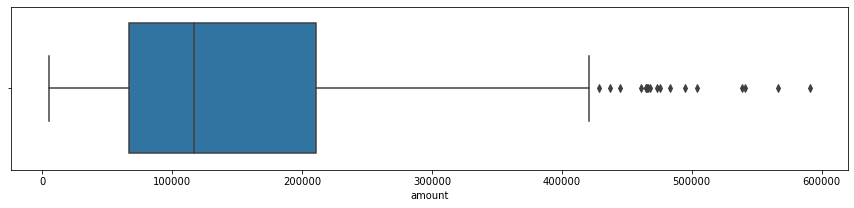

Feature amount : Mean = 151410.176, Median = 116928.0 and Inter-Quartile-Range (IQR) = 143922.0
There are 18 outliers (2.639 % of the data points) in amount feature and the values are [482940, 566640, 428784, 460980, 504000, 538500, 464520, 466608, 475680, 468060, 473280, 590820, 444864, 465072, 437460, 495180, 541200, 465504]
*****************************************************************************************************************************
******************************
Boxplot of A4 column : 
******************************


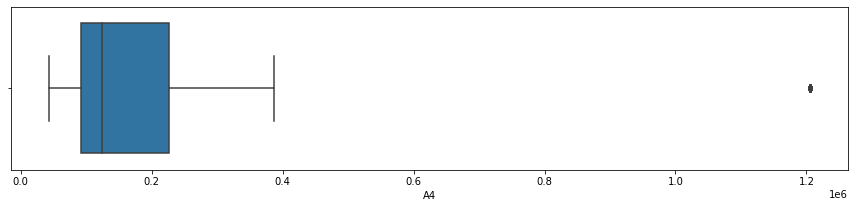

Feature A4 : Mean = 272052.236, Median = 124605.0 and Inter-Quartile-Range (IQR) = 134038.0
There are 84 outliers (12.317 % of the data points) in A4 feature and the values are [1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953]
******************************************************************

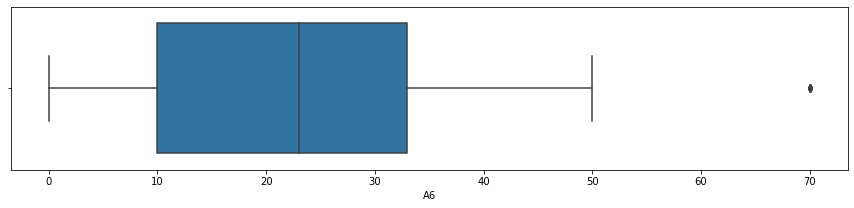

Feature A6 : Mean = 21.557, Median = 23.0 and Inter-Quartile-Range (IQR) = 23.0
There are 10 outliers (1.466 % of the data points) in A6 feature and the values are [70, 70, 70, 70, 70, 70, 70, 70, 70, 70]
*****************************************************************************************************************************
******************************
Boxplot of A7 column : 
******************************


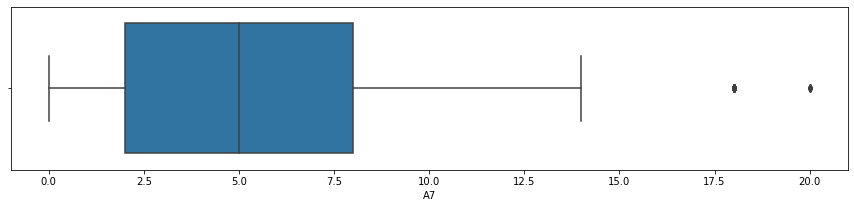

Feature A7 : Mean = 5.648, Median = 5.0 and Inter-Quartile-Range (IQR) = 6.0
There are 32 outliers (4.692 % of the data points) in A7 feature and the values are [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 20, 20, 20, 20, 20, 20, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
*****************************************************************************************************************************
******************************
Boxplot of A8 column : 
******************************


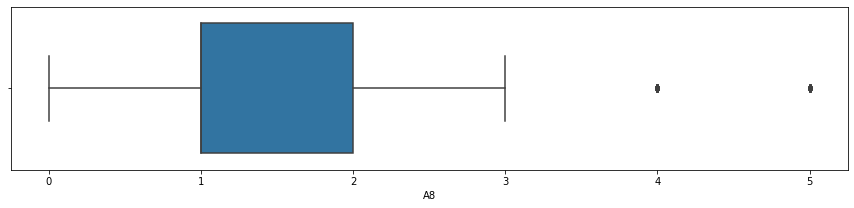

Feature A8 : Mean = 1.713, Median = 1.0 and Inter-Quartile-Range (IQR) = 1.0
There are 53 outliers (7.771 % of the data points) in A8 feature and the values are [4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
*****************************************************************************************************************************
******************************
Boxplot of A11 column : 
******************************


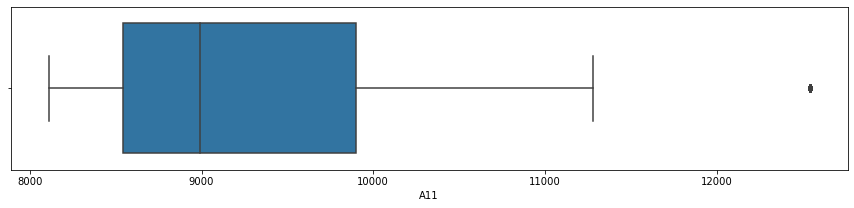

Feature A11 : Mean = 9502.987, Median = 8991.0 and Inter-Quartile-Range (IQR) = 1353.0
There are 84 outliers (12.317 % of the data points) in A11 feature and the values are [12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541]
*****************************************************************************************************************************
******************************
Boxplot of A13 column : 
******************************


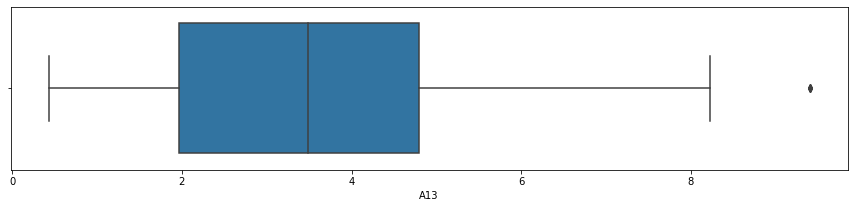

Feature A13 : Mean = 3.528, Median = 3.49 and Inter-Quartile-Range (IQR) = 2.83
There are 5 outliers (0.733 % of the data points) in A13 feature and the values are [9.4, 9.4, 9.4, 9.4, 9.4]
*****************************************************************************************************************************
******************************
Boxplot of A16 column : 
******************************


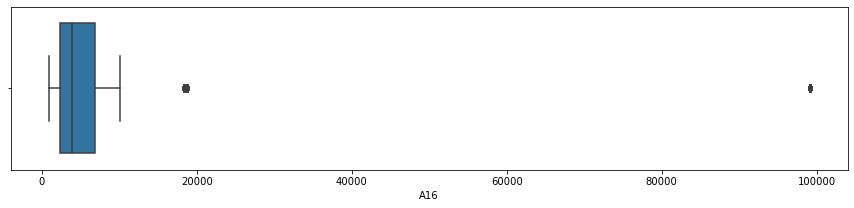

Feature A16 : Mean = 16390.818, Median = 3868.0 and Inter-Quartile-Range (IQR) = 4567.0
There are 128 outliers (18.768 % of the data points) in A16 feature and the values are [99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18347, 18347, 18347, 18347, 18347, 18347, 18347, 18347, 18347, 18347

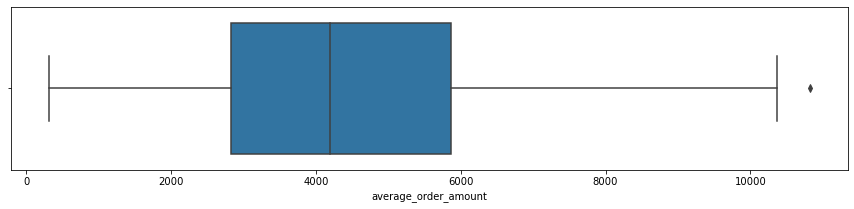

Feature average_order_amount : Mean = 4486.951, Median = 4193.617 and Inter-Quartile-Range (IQR) = 3039.533
There are 1 outliers (0.147 % of the data points) in average_order_amount feature and the values are [10817.0]
*****************************************************************************************************************************


Column Name        Mean     Median Lower Quartile  \
0   client_id              7120.573    6941.0     3582.25         
1   disp_id                7002.702    6941.0     3582.25         
2   account_id             5824.163    5738.5     2967.0          
3   district_id            37.49       39.0       13.0            
4   loan_id                6172.466    6176.5     5577.5          
5   amount                 151410.176  116928.0   66732.0         
6   duration               36.493      36.0       24.0            
7   payments               4190.664    3934.0     2477.0          
8   A4                     272052.236  124605.0   92084.0         
9   A5                     39.673      35.0       5.0             
10  A6                     21.557      23.0       10.0            
11  A7                     5.648       5.0        2.0             
12  A8                     1.713       1.0        1.0             
13  A9                     5.406       6.0        4.0             
14  A10                    68.213      62.1       52.0            
15  A11                    9502.987    8991.0     8544.0          
16  A13                    3.528       3.49       1.96            
17  A14                    121.218     116.0      106.0           
18  A16                    16390.818   3868.0     2305.0          
19  average_order_amount   4486.951    4193.617   2823.516667     
20  average_trans_amount   8460.847    8331.5     5490.913934     
21  average_trans_balance  44935.231   45614.333  34685.432672    
22  no_of_trans            280.874     250.5      173.25          
23  card_id                791.076     NaN        551.25          

   Upper Quartile        IQR No of Outliers Present Percentage of Outliers  \
0   10711.0        7128.75    0                      0.0 %                   
1   10403.0        6820.75    0                      0.0 %                   
2   8686.0         5719.0     0                      0.0 %                   
3   60.0           47.0       0                      0.0 %                   
4   6752.5         1175.0     0                      0.0 %                   
5   210654.0       143922.0   18                     2.639 %                 
6   48.0           24.0       0                      0.0 %                   
7   5813.5         3336.5     0                      0.0 %                   
8   226122.0       134038.0   84                     12.317 %                
9   65.0           60.0       0                      0.0 %                   
10  33.0           23.0       10                     1.466 %                 
11  8.0            6.0        32                     4.692 %                 
12  2.0            1.0        53                     7.771 %                 
13  7.0            3.0        0                      0.0 %                   
14  87.7           35.7       0                      0.0 %                   
15  9897.0         1353.0     84                     12.317 %                
16  4.79           2.83       5                      0.733 %                 
17  132.0          26.0       0                      0.0 %                   
18  6872.0         4567.0     128                    18.768 %                
19  5863.05        3039.533   1                      0.147 %                 
20  11346.152069   5855.238   0                      0.0 %                   
21  55426.138818   20740.706  0                      0.0 %                   
22  392.0          218.75     0                      0.0 %                   
23  1055.75        504.5      0                      0.0 %                   

                                                                                                                                                                                                                                                                                                                                                                                                   

In [398]:
showOutliers(main_df)

In [399]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   client_id              682 non-null    int64         
 1   disp_id                682 non-null    int64         
 2   account_id             682 non-null    int64         
 3   district_id            682 non-null    int64         
 4   loan_id                682 non-null    int64         
 5   date                   682 non-null    datetime64[ns]
 6   amount                 682 non-null    int64         
 7   duration               682 non-null    int64         
 8   payments               682 non-null    float64       
 9   status                 682 non-null    object        
 10  frequency              682 non-null    object        
 11  date_account           682 non-null    datetime64[ns]
 12  A2                     682 non-null    object        
 13  A3   

In [400]:
main_df.head().T

0                    1  \
client_id              13539                11126                 
disp_id                13231                10818                 
account_id             11013                9034                  
district_id            1                    1                     
loan_id                7240                 6820                  
date                   1993-09-06 00:00:00  1993-12-16 00:00:00   
amount                 274740               38148                 
duration               60                   12                    
payments               4579.0               3179.0                
status                 A                    A                     
frequency              POPLATEK TYDNE       POPLATEK MESICNE      
date_account           1993-02-14 00:00:00  1993-06-28 00:00:00   
A2                     Hl.m. Praha          Hl.m. Praha           
A3                     Prague               Prague                
A4                     1204953              1204953               
A5                     0                    0                     
A6                     0                    0                     
A7                     0                    0                     
A8                     1                    1                     
A9                     1                    1                     
A10                    100.0                100.0                 
A11                    12541                12541                 
A12                    0.29                 0.29                  
A13                    0.43                 0.43                  
A14                    167                  167                   
A15                    85677                85677                 
A16                    99107                99107                 
average_order_amount   4944.666667          4403.0                
average_trans_amount   11166.871804         5386.022259           
average_trans_balance  56912.551664         39267.009165          
no_of_trans            571                  611                   
card_id                1223.0               NaN                   
type                   junior               NaN                   
issued                 1995-05-02 00:00:00  NaT                   
date_of_birth          1978-09-07           1965-12-02            
gender                 M                    F                     

                                         2                    3  \
client_id              2                    9173                  
disp_id                2                    8865                  
account_id             2                    7401                  
district_id            1                    1                     
loan_id                4959                 6499                  
date                   1994-01-05 00:00:00  1994-01-05 00:00:00   
amount                 80952                80952                 
duration               24                   24                    
payments               3373.0               3373.0                
status                 A                    A                     
frequency              POPLATEK MESICNE     POPLATEK MESICNE      
date_account           1993-02-26 00:00:00  1993-02-26 00:00:00   
A2                     Hl.m. Praha          Hl.m. Praha           
A3                     Prague               Prague                
A4                     1204953              1204953               
A5                     0                    0                     
A6                     0                    0                     
A7                     0                    0                     
A8                     1                    1                     
A9                     1                    1                     
A10                    100.0                100.0                 
A11                    12541                12541                 
A12                 

In [401]:
#Checking unique values in each column/feature
def column_unique_values(pd_data):
    '''
    Use to find out unique values available in each column of the dataset
    
    Parameters
    ----------
    pd_data : Pandas dataframe to be checked on for unique values
    
    Returns
    ----------
    Unique values avilable on each column in the pandas dataframe passed
    '''
    df = pd.DataFrame(columns = ['Column Name', 'Number of Rows', 'Number of Unique Values', 'Unique Values'])
    for col in pd_data.columns:
        df = df.append({'Column Name' : col, 'Number of Rows': pd_data.shape[0], 'Number of Unique Values':pd_data[col].nunique(), 'Unique Values':pd_data[col].unique()}, ignore_index=True)
    return df

In [402]:
# setting column width to zero to get maximum column width
pd.set_option("display.max_colwidth",None)

# calling user defined function to find out unique values available on the dataset except 'descripton' column
unique_col_values = column_unique_values(main_df)
unique_col_values

Column Name Number of Rows Number of Unique Values  \
0               client_id            682                     682   
1                 disp_id            682                     682   
2              account_id            682                     682   
3             district_id            682                      77   
4                 loan_id            682                     682   
5                    date            682                     559   
6                  amount            682                     645   
7                duration            682                       5   
8                payments            682                     577   
9                  status            682                       4   
10              frequency            682                       3   
11           date_account            682                     557   
12                     A2            682                      77   
13                     A3            682                       8   
14                     A4            682                      77   
15                     A5            682                      53   
16                     A6            682                      36   
17                     A7            682                      17   
18                     A8            682                       6   
19                     A9            682                      11   
20                    A10            682                      70   
21                    A11            682                      76   
22                    A12            682                      71   
23                    A13            682                      73   
24                    A14            682                      44   
25                    A15            682                      76   
26                    A16            682                      76   
27   average_order_amount            682                     651   
28   average_trans_amount            682                     682   
29  average_trans_balance            682                     682   
30            no_of_trans            682                     356   
31                card_id            682                     170   
32                   type            682                       3   
33                 issued            682                     160   
34          date_of_birth            682                     655   
35                 gender            682                       2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [403]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   client_id              682 non-null    int64         
 1   disp_id                682 non-null    int64         
 2   account_id             682 non-null    int64         
 3   district_id            682 non-null    int64         
 4   loan_id                682 non-null    int64         
 5   date                   682 non-null    datetime64[ns]
 6   amount                 682 non-null    int64         
 7   duration               682 non-null    int64         
 8   payments               682 non-null    float64       
 9   status                 682 non-null    object        
 10  frequency              682 non-null    object        
 11  date_account           682 non-null    datetime64[ns]
 12  A2                     682 non-null    object        
 13  A3   

In [404]:
main_df['acct_to_loan_duration'] = main_df['date'] - main_df ['date_account']
main_df['acct_to_loan_duration'] = main_df['acct_to_loan_duration'].dt.days
main_df['age'] = pd.to_datetime('1998-01-01', format='%Y-%m-%d') - pd.to_datetime(main_df['date_of_birth'], format='%Y-%m-%d')
main_df['age'] = main_df['age'].dt.days/365
main_df.drop(columns=['date','date_account','date_of_birth','issued'],inplace=True)
# main_df = main_df.convert_dtypes()

In [405]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              682 non-null    int64  
 1   disp_id                682 non-null    int64  
 2   account_id             682 non-null    int64  
 3   district_id            682 non-null    int64  
 4   loan_id                682 non-null    int64  
 5   amount                 682 non-null    int64  
 6   duration               682 non-null    int64  
 7   payments               682 non-null    float64
 8   status                 682 non-null    object 
 9   frequency              682 non-null    object 
 10  A2                     682 non-null    object 
 11  A3                     682 non-null    object 
 12  A4                     682 non-null    int64  
 13  A5                     682 non-null    int64  
 14  A6                     682 non-null    int64  
 15  A7    

In [406]:
main_df['card_id'] = main_df['card_id'].fillna(0)
main_df['type'] = main_df['type'].fillna("NA")
main_df['A12'].replace("?", "0", inplace=True)
main_df['A12'] = main_df['A12'].astype(float)
main_df['A15'].replace("?", "0", inplace=True)
main_df['A15'] = main_df['A15'].astype(int)

In [407]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              682 non-null    int64  
 1   disp_id                682 non-null    int64  
 2   account_id             682 non-null    int64  
 3   district_id            682 non-null    int64  
 4   loan_id                682 non-null    int64  
 5   amount                 682 non-null    int64  
 6   duration               682 non-null    int64  
 7   payments               682 non-null    float64
 8   status                 682 non-null    object 
 9   frequency              682 non-null    object 
 10  A2                     682 non-null    object 
 11  A3                     682 non-null    object 
 12  A4                     682 non-null    int64  
 13  A5                     682 non-null    int64  
 14  A6                     682 non-null    int64  
 15  A7    

In [408]:
# This function returns the encoded columns
def get_one_hot_encoded_features(pdData,cols):
    '''
    One hot encoding using get_dummies function to encode Non Ordinal columns of pandas dataframe
    
    Parameters
    ----------
    pdData : Pandas dataframe to be used
    cols   : list of columns to be encoded using one hot encoding
    
    Returns
    ---------
    Pandas dataframe containing one hot encoded columns
    '''
    encd_data = pd.DataFrame()
    for col in cols:
        encd_data = pd.concat([encd_data,pd.get_dummies(pdData[col],drop_first=True,columns=[col])],axis=1)
    return encd_data

In [409]:
# list of Non-Ordinal columns to be encoded to one hot encoding
col_list = ['frequency', 'type', 'gender']
#calling user defined one hot encoding function
one_hot_encoded_features = get_one_hot_encoded_features(main_df,col_list)

In [410]:
main_df.drop(columns=['frequency', 'type', 'gender'],inplace=True)

In [411]:
def get_label_encoded_features(pdData,cols):
    '''
    Label encoding to encode columns of pandas dataframe
    
    Parameters
    ----------
    pdData : Pandas dataframe to be used
    cols   : Dictionary of columns and respective values to be label encode
    
    Returns
    ---------
    Pandas dataframe containing label encoded columns
    '''
    encd_df = pd.DataFrame()
    for col,val in cols.items():
        encd_df = pd.concat([encd_df,pdData[col].replace(val)],axis=1)
    return encd_df

In [412]:
# defining column dictionary to be encoded with respective values
label_encod_dict = {
                    'A2':{'Hl.m. Praha':0, 'Benesov':1 , 'Beroun':2, 'Kladno':3, 'Kolin':4, 'Kutna Hora':5, 'Melnik':6, 'Mlada Boleslav':7, 'Nymburk':8,
                          'Praha - vychod':9, 'Praha - zapad':10, 'Pribram':11, 'Rakovnik':12, 'Ceske Budejovice':13, 'Cesky Krumlov':14, 'Jindrichuv Hradec':15,
                          'Pelhrimov':16, 'Pisek':17, 'Prachatice':18, 'Strakonice':19, 'Tabor':20, 'Domazlice':21, 'Cheb':22, 'Karlovy Vary':23, 'Klatovy':24, 'Plzen - mesto':25,
                          'Plzen - jih':26, 'Plzen - sever':27, 'Rokycany':28, 'Sokolov':29, 'Tachov':30, 'Ceska Lipa':31, 'Decin':32, 'Chomutov':33, 'Jablonec n. Nisou':34,
                          'Liberec':35, 'Litomerice':36, 'Louny':37, 'Most':38, 'Teplice':39, 'Usti nad Labem':40, 'Havlickuv Brod':41, 'Hradec Kralove':42, 'Chrudim':43, 'Jicin':44,
                          'Nachod':45, 'Pardubice':46, 'Rychnov nad Kneznou':47, 'Semily':48, 'Svitavy':49, 'Trutnov':50, 'Usti nad Orlici':51, 'Blansko':52, 'Brno - mesto':53, 
                          'Brno - venkov':54, 'Breclav':55, 'Hodonin':56, 'Jihlava':57, 'Kromeriz':58, 'Prostejov':59, 'Trebic':60, 'Uherske Hradiste':61, 'Vyskov':62, 'Zlin':63, 'Znojmo':64,
                          'Zdar nad Sazavou':65, 'Bruntal':66, 'Frydek - Mistek':67, 'Jesenik':68, 'Karvina':69, 'Novy Jicin':70, 'Olomouc':71, 'Opava':72, 'Ostrava - mesto':73,
                          'Prerov':74, 'Sumperk':75, 'Vsetin':76},
                    'A3':{'Prague':0, 'central Bohemia':1, 'south Bohemia':2, 'west Bohemia':3, 'north Bohemia':4, 'east Bohemia':5, 'south Moravia':6, 'north Moravia':7},
                    'status': {'A':0,'B':1,'C':0,'D':1}
                   }

In [413]:
# calling user defined label encoder to label encode
label_encoded_features = get_label_encoded_features(main_df,label_encod_dict)

In [414]:
main_df.drop(columns=['A2', 'A3', 'status'],inplace=True)

In [415]:
# concatenating 'month','day','description' columns from main dataset with one hot encoded columns and label encoded columns to arrive final dataset
main_df = pd.concat([main_df,one_hot_encoded_features,label_encoded_features],axis=1)

In [416]:
main_df.head().T

0             1             2             3  \
client_id              1.353900e+04  1.112600e+04  2.000000e+00  9.173000e+03   
disp_id                1.323100e+04  1.081800e+04  2.000000e+00  8.865000e+03   
account_id             1.101300e+04  9.034000e+03  2.000000e+00  7.401000e+03   
district_id            1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
loan_id                7.240000e+03  6.820000e+03  4.959000e+03  6.499000e+03   
amount                 2.747400e+05  3.814800e+04  8.095200e+04  8.095200e+04   
duration               6.000000e+01  1.200000e+01  2.400000e+01  2.400000e+01   
payments               4.579000e+03  3.179000e+03  3.373000e+03  3.373000e+03   
A4                     1.204953e+06  1.204953e+06  1.204953e+06  1.204953e+06   
A5                     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
A6                     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
A7                     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
A8                     1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
A9                     1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
A10                    1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02   
A11                    1.254100e+04  1.254100e+04  1.254100e+04  1.254100e+04   
A12                    2.900000e-01  2.900000e-01  2.900000e-01  2.900000e-01   
A13                    4.300000e-01  4.300000e-01  4.300000e-01  4.300000e-01   
A14                    1.670000e+02  1.670000e+02  1.670000e+02  1.670000e+02   
A15                    8.567700e+04  8.567700e+04  8.567700e+04  8.567700e+04   
A16                    9.910700e+04  9.910700e+04  9.910700e+04  9.910700e+04   
average_order_amount   4.944667e+03  4.403000e+03  5.319350e+03  5.319350e+03   
average_trans_amount   1.116687e+04  5.386022e+03  6.593053e+03  6.605886e+03   
average_trans_balance  5.691255e+04  3.926701e+04  3.654070e+04  3.555750e+04   
no_of_trans            5.710000e+02  6.110000e+02  4.780000e+02  4.780000e+02   
card_id                1.223000e+03  0.000000e+00  0.000000e+00  0.000000e+00   
acct_to_loan_duration  2.040000e+02  1.710000e+02  3.130000e+02  3.130000e+02   
age                    1.933151e+01  3.210411e+01  5.294247e+01  5.294247e+01   
POPLATEK PO OBRATU     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
POPLATEK TYDNE         1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
classic                0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
gold                   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
junior                 1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
M                      1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
A2                     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
A3                     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
status                 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                                  4  
client_id              3.001000e+03  
disp_id                3.001000e+03  
account_id             2.486000e+03  
district_id            1.000000e+00  
loan_id                5.479000e+03  
amount                 2.451600e+04  
duration               1.200000e+01  
payments               2.043000e+03  
A4                     1.204953e+06  
A5                     0.000000e+00  
A6                     0.000000e+00  
A7                     0.000000e+00  
A8                     1.000000e+00  
A9                     1.000000e+00  
A10                    1.000000e+02  
A11                    1.254100e+04  
A12                    2.900000e-01  
A13                    4.300000e-01  
A14                    1.670000e+02  
A15                    8.567700e+04  
A16                    9.910700e+04  
average_order_amount   2.043000e+03  
average_trans_amount   1.294083e+04  
average_trans_balance  5.588548e+04  
no_of

In [417]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 0 to 681
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              682 non-null    int64  
 1   disp_id                682 non-null    int64  
 2   account_id             682 non-null    int64  
 3   district_id            682 non-null    int64  
 4   loan_id                682 non-null    int64  
 5   amount                 682 non-null    int64  
 6   duration               682 non-null    int64  
 7   payments               682 non-null    float64
 8   A4                     682 non-null    int64  
 9   A5                     682 non-null    int64  
 10  A6                     682 non-null    int64  
 11  A7                     682 non-null    int64  
 12  A8                     682 non-null    int64  
 13  A9                     682 non-null    int64  
 14  A10                    682 non-null    float64
 15  A11        

Text(0.5, 1.0, 'Correlation between attributes')

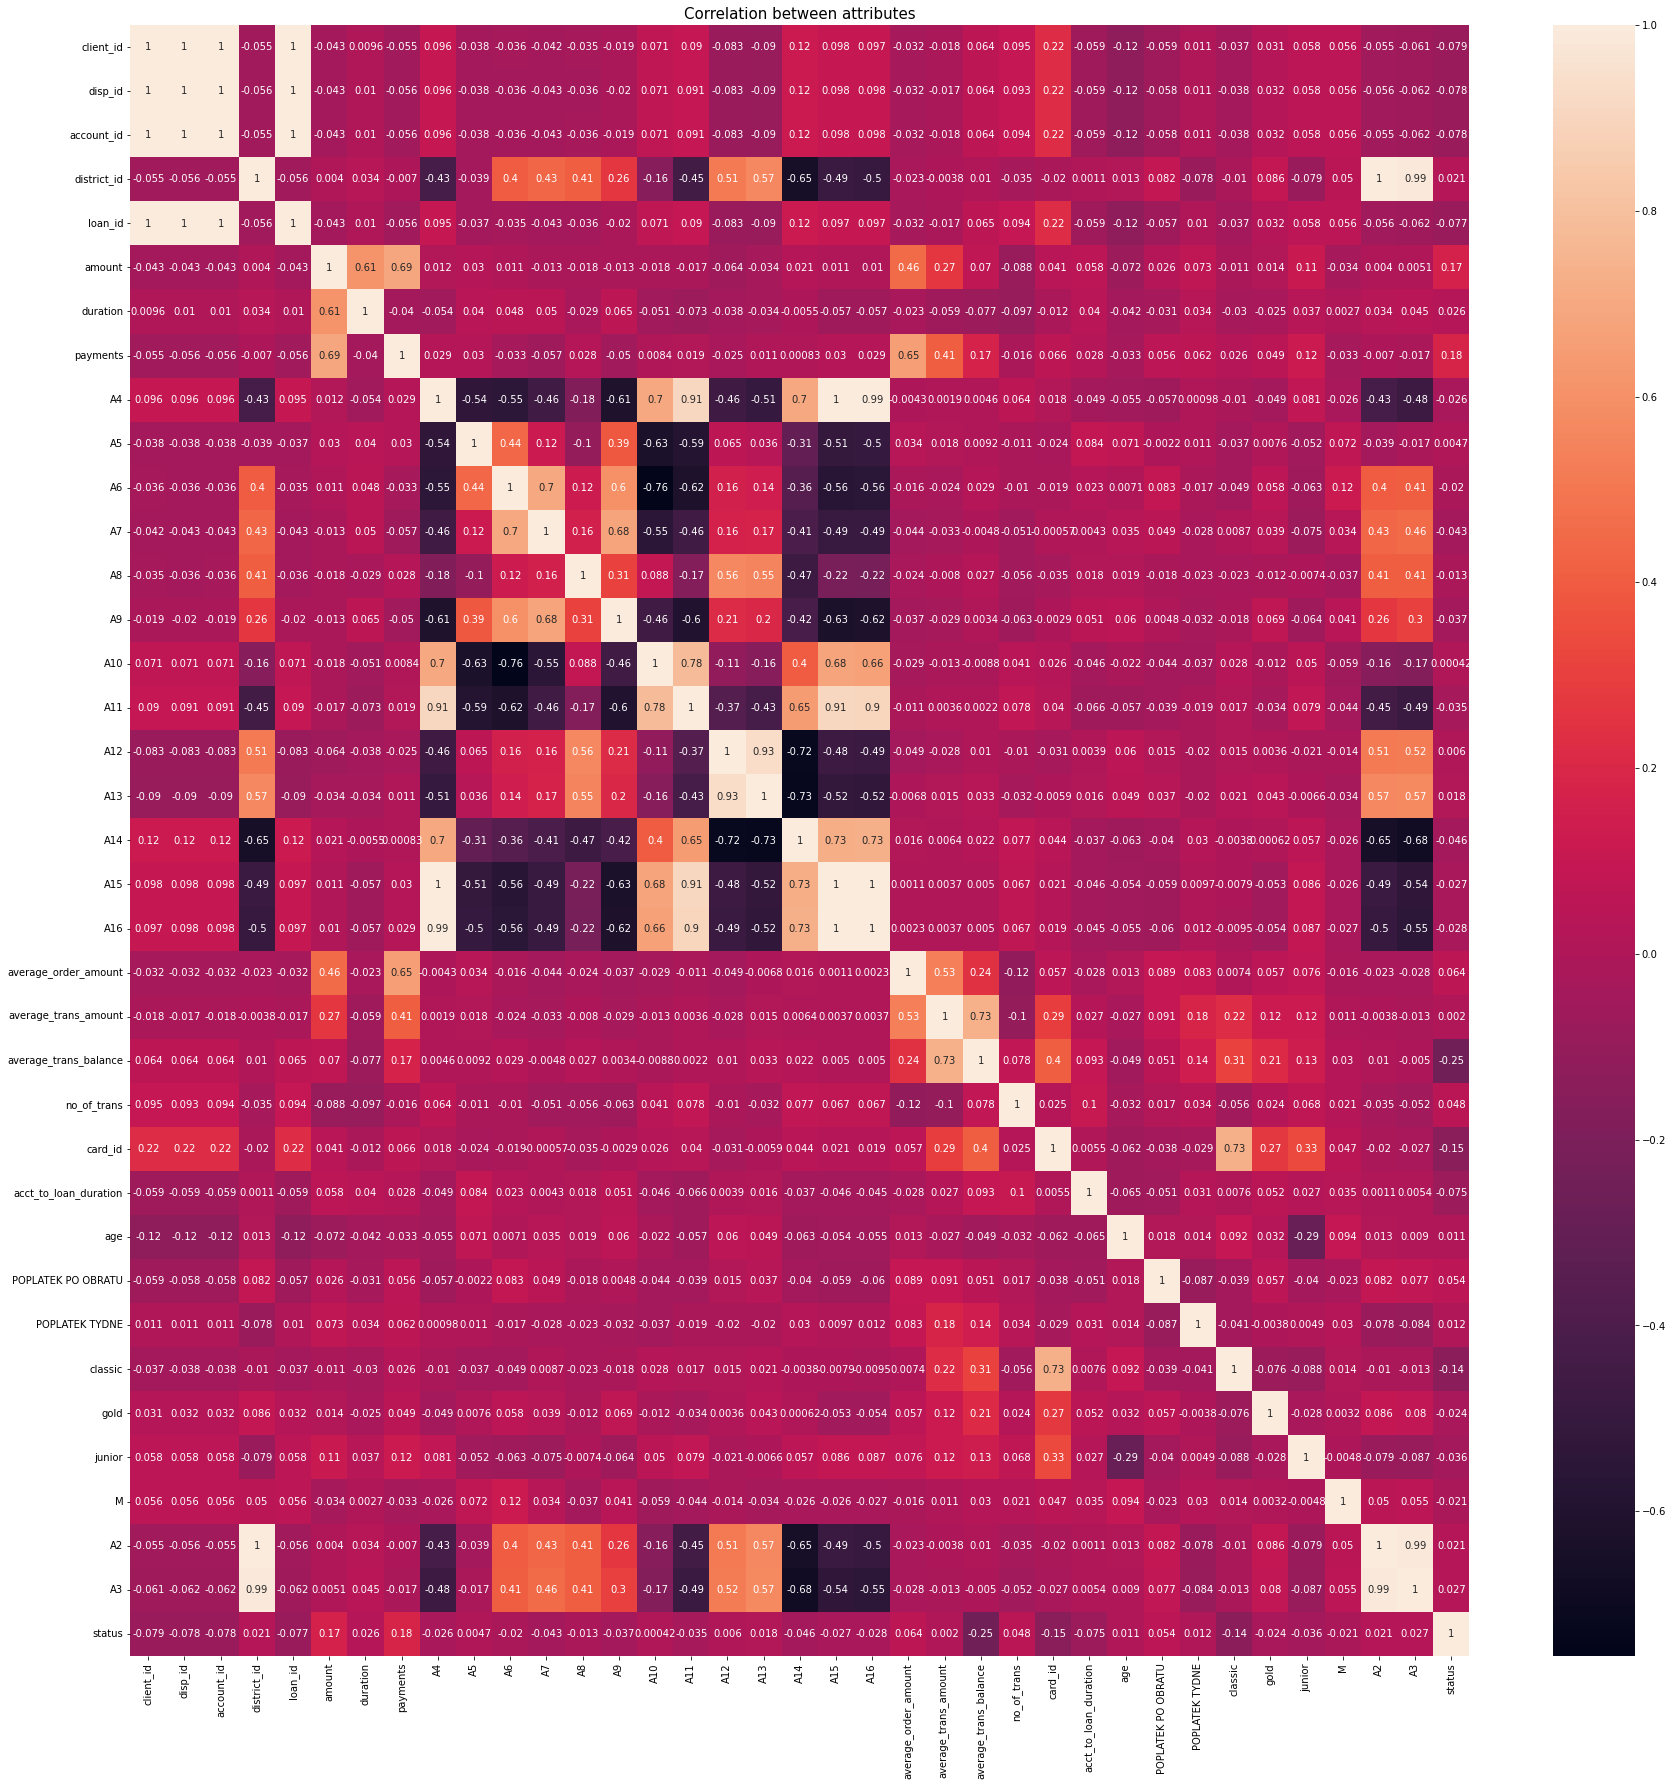

In [418]:
fig = plt.subplots(figsize=(30,30))
sns.heatmap(main_df.corr(), annot=True)
plt.title('Correlation between attributes', fontsize=15)

In [419]:
def showCorr(pdData,limit=0.80):
    colNames = []
    posIndex = []
    posCorr = []
    posCorrCnt = []
    negIndex = []
    negCorr = []
    negCorrCnt = []
    cols = pdData.columns
    corrs = pdData.corr()
    
    # to eliminate attibutes with self correlated values in the output
    np.fill_diagonal(corrs.values, 0)
    
    length = len(cols)
    for col in cols:
        posCorrVal = round(corrs[round(corrs[col],2) >= limit][col],2)
        negCorrVal = round(corrs[round(corrs[col],2) <= limit*-1][col],2)
        
        if((len(posCorrVal) > 0) | (len(negCorrVal) > 0)):
            colNames.append(col)

            posIndex.append(posCorrVal.index.tolist())
            posCorr.append(posCorrVal.tolist())
            posCorrCnt.append(len(posCorrVal))

            negIndex.append(negCorrVal.index.tolist())
            negCorr.append(negCorrVal.tolist())
            negCorrCnt.append(len(negCorrVal))
    data = [colNames, posCorrCnt, posIndex, posCorr, negCorrCnt, negIndex, negCorr]
    pd.set_option("display.max_colwidth", 0)
    corrPd = pd.DataFrame(data,index=['Attribute Name', 'Number of Attributes with +ve Correlation',
                                      'Attributes with +ve Correlation', 'Positively Correlated Value',
                                      'Number of Attributes with -ve Correlation',
                                      'Attributes with -ve Correlation', 'Negatively Correlated Value'])
    return corrPd.T       

In [420]:
showCorr(main_df, 0.7)

Attribute Name Number of Attributes with +ve Correlation  \
0   client_id              3                                          
1   disp_id                3                                          
2   account_id             3                                          
3   district_id            2                                          
4   loan_id                3                                          
5   A4                     5                                          
6   A6                     1                                          
7   A7                     1                                          
8   A10                    2                                          
9   A11                    4                                          
10  A12                    1                                          
11  A13                    1                                          
12  A14                    3                                          
13  A15                    4                                          
14  A16                    4                                          
15  average_trans_amount   1                                          
16  average_trans_balance  1                                          
17  card_id                1                                          
18  classic                1                                          
19  A2                     2                                          
20  A3                     2                                          

     Attributes with +ve Correlation  Positively Correlated Value  \
0   [disp_id, account_id, loan_id]    [1.0, 1.0, 1.0]               
1   [client_id, account_id, loan_id]  [1.0, 1.0, 1.0]               
2   [client_id, disp_id, loan_id]     [1.0, 1.0, 1.0]               
3   [A2, A3]                          [1.0, 0.99]                   
4   [client_id, disp_id, account_id]  [1.0, 1.0, 1.0]               
5   [A10, A11, A14, A15, A16]         [0.7, 0.91, 0.7, 1.0, 0.99]   
6   [A7]                              [0.7]                         
7   [A6]                              [0.7]                         
8   [A4, A11]                         [0.7, 0.78]                   
9   [A4, A10, A15, A16]               [0.91, 0.78, 0.91, 0.9]       
10  [A13]                             [0.93]                        
11  [A12]                             [0.93]                        
12  [A4, A15, A16]                    [0.7, 0.73, 0.73]             
13  [A4, A11, A14, A16]               [1.0, 0.91, 0.73, 1.0]        
14  [A4, A11, A14, A15]               [0.99, 0.9, 0.73, 1.0]        
15  [average_trans_balance]           [0.73]                        
16  [average_trans_amount]            [0.73]                        
17  [classic]                         [0.73]                        
18  [card_id]                         [0.73]                        
19  [district_id, A3]                 [1.0, 0.99]                   
20  [district_id, A2]                 [0.99, 0.99]                  

   Number of Attributes with -ve Correlation Attributes with -ve Correlation  \
0   0                                         []                               
1   0                                         []                               
2   0                                         []                               
3   0                                         []                               
4   0                                         []                               
5   0                                         []                               
6   1                                         [A10]                            
7   0                                         []                               
8   1                                         [A6]                             
9   0                                         []                               
10  1                                         [A1

In [421]:
# as nothing correlated with target column 'status', checking for minimum correlation 
showCorr(main_df, 0.1)

Attribute Name Number of Attributes with +ve Correlation  \
0   client_id              8                                          
1   disp_id                8                                          
2   account_id             8                                          
3   district_id            8                                          
4   loan_id                8                                          
5   amount                 6                                          
6   duration               1                                          
7   payments               6                                          
8   A4                     9                                          
9   A5                     3                                          
10  A6                     10                                         
11  A7                     9                                          
12  A8                     8                                          
13  A9                     9                                          
14  A10                    5                                          
15  A11                    5                                          
16  A12                    8                                          
17  A13                    8                                          
18  A14                    9                                          
19  A15                    9                                          
20  A16                    9                                          
21  average_order_amount   4                                          
22  average_trans_amount   9                                          
23  average_trans_balance  8                                          
24  no_of_trans            1                                          
25  card_id                9                                          
26  acct_to_loan_duration  1                                          
27  age                    0                                          
28  POPLATEK TYDNE         2                                          
29  classic                3                                          
30  gold                   3                                          
31  junior                 5                                          
32  M                      1                                          
33  A2                     8                                          
34  A3                     8                                          
35  status                 2                                          

                                                                                    Attributes with +ve Correlation  \
0   [disp_id, account_id, loan_id, A4, A14, A15, A16, card_id]                                                        
1   [client_id, account_id, loan_id, A4, A14, A15, A16, card_id]                                                      
2   [client_id, disp_id, loan_id, A4, A14, A15, A16, card_id]                                                         
3   [A6, A7, A8, A9, A12, A13, A2, A3]                                                                                
4   [client_id, disp_id, account_id, A4, A14, A15, A16, card_id]                                                      
5   [duration, payments, average_order_amount, average_trans_amount, junior, status]                                  
6   [amount]                                                                                                          
7   [amount, average_order_amount, average_trans_amount, average_trans_balance, junior, status]                       
8   [client_id, disp_id, account_id, loan_id, A10, A11, A14, A15, A16]                                                
9   [A6, A7, A9]                                                                                                      
10  [district_id, A5, A7, A8, A9, A12, A13, M, A2, A3]                    

In [422]:
featured_df = main_df[['client_id','district_id','A4','A6','A12','amount','payments','average_trans_amount','card_id','classic','status']]

In [423]:
featured_df

client_id  district_id       A4  A6   A12  amount  payments  \
0    13539      1            1204953  0   0.29  274740  4579.0     
1    11126      1            1204953  0   0.29  38148   3179.0     
2    2          1            1204953  0   0.29  80952   3373.0     
3    9173       1            1204953  0   0.29  80952   3373.0     
4    3001       1            1204953  0   0.29  24516   2043.0     
..    ...      ..                ... ..    ...    ...      ...     
677  6317       77           148545   35  4.01  173808  7242.0     
678  3616       77           148545   35  4.01  48744   1354.0     
679  5579       77           148545   35  4.01  87528   3647.0     
680  8667       77           148545   35  4.01  49872   4156.0     
681  5143       77           148545   35  4.01  41988   3499.0     

     average_trans_amount  card_id  classic  status  
0    11166.871804          1223.0   0        0       
1    5386.022259           0.0      0        0       
2    6593.052929           0.0      0        0       
3    6605.885774           0.0      0        0       
4    12940.828464          0.0      0        0       
..            ...          ...     ..       ..       
677  15677.367401          0.0      0        0       
678  6264.880660           569.0    1        0       
679  8315.958647           796.0    1        0       
680  6657.845270           0.0      0        0       
681  4460.517730           0.0      0        0       

[682 rows x 11 columns]

In [424]:
featured_df.to_csv('preprocessed_data.csv')

In [425]:
#Split the data into training and test set 
X = featured_df.drop(['status'],axis=1)
y = featured_df['status']

# split data into train subset and test subset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

# checking the dimensions of the train & test subset
# printing dimension of train set
print(X_train.shape)
# printing dimension of test set
print(X_test.shape)

(511, 10)
(171, 10)


In [426]:
def pickle_model(file_name, model):
    '''
    Used to pickle models
    
    Parameters
    ----------
    file_name : filename to be given for saving model
    model : model to be passed for saving
    '''
    with open(file_name, 'wb') as file:  
        pickle.dump(model, file)
    print(f"[INFO] Model pickle as {file_name}.")
    
def load_pickled_model(file_name,model_type=None):
    '''
    Used to load pickled model
    
    Parameters
    ----------
    file_name : filename of pickled model to be loaded
    
    Returns
    ----------
    Returns model loaded
    '''
    with open(file_name, 'rb') as file:  
        model = pickle.load(file)
    return model

In [427]:
RANDOM_STATE = 0
n_classes = 2
N_SPLITS = 10
CV = 2

In [428]:
# defining LogisticRegression model
model = LogisticRegression(penalty='l2',
                            dual=False,
                            tol=0.0001,
                            C=0.5,
                            fit_intercept=True,
                            intercept_scaling=1,
                            class_weight=None,
                            random_state=RANDOM_STATE,   
                            solver='liblinear',              #changed - multiclass supports lbfgs as solver
                            max_iter=100,
                            multi_class='auto',
                            verbose=0,
                            warm_start=False,
                            n_jobs=None,
                            l1_ratio=None,)

file_name = "pickled/LogisticRegression.pkl"
pickle_model(file_name,model)
del model

[INFO] Model pickle as pickled/LogisticRegression.pkl.


In [429]:
# defining KNeighborsClassifier model
model = KNeighborsClassifier(n_neighbors=5,
                                weights='uniform',
                                algorithm='auto',
                                leaf_size=30,
                                p=2,
                                metric='minkowski',
                                metric_params=None,
                                n_jobs=None)

file_name = "pickled/KNeighborsClassifier.pkl"
pickle_model(file_name,model)
del model

[INFO] Model pickle as pickled/KNeighborsClassifier.pkl.


In [430]:
# defining DecisionTreeClassifier model
model = DecisionTreeClassifier(criterion='gini',
                                                splitter='best',
                                                max_depth=None,
                                                min_samples_split=2,
                                                min_samples_leaf=1,
                                                min_weight_fraction_leaf=0.0,
                                                max_features=None,
                                                random_state=RANDOM_STATE,      #changed - RANDOM_STATE = 0
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                # min_impurity_split=None,
                                                class_weight='balanced',        #changed - balanced weights
                                                ccp_alpha=0.0)

file_name = "pickled/DecisionTreeClassifier.pkl"
pickle_model(file_name,model)
del model

[INFO] Model pickle as pickled/DecisionTreeClassifier.pkl.


In [431]:
# defining RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100,
                                                criterion='gini',
                                                max_depth=None,
                                                min_samples_split=2,
                                                min_samples_leaf=1,
                                                min_weight_fraction_leaf=0.0,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                # min_impurity_split=None,
                                                bootstrap=True,
                                                oob_score=False,
                                                n_jobs=None,
                                                random_state=RANDOM_STATE,      #changed - RANDOM_STATE = 0
                                                verbose=0,
                                                warm_start=False,
                                                class_weight='balanced',        #changed - balanced weights
                                                ccp_alpha=0.0,
                                                max_samples=None)

file_name = "pickled/RandomForestClassifier.pkl"
pickle_model(file_name,model)
del model

[INFO] Model pickle as pickled/RandomForestClassifier.pkl.


In [432]:
# defining ExtraTreesClassifier model
model = ExtraTreesClassifier(n_estimators=100,
                                                criterion='gini',
                                                max_depth=None,
                                                min_samples_split=2,
                                                min_samples_leaf=1,
                                                min_weight_fraction_leaf=0.0,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                # min_impurity_split=None,
                                                bootstrap=False,
                                                oob_score=False,
                                                n_jobs=None,
                                                random_state=RANDOM_STATE,      #changed - RANDOM_STATE = 0
                                                verbose=0,
                                                warm_start=False,
                                                class_weight='balanced',        #changed - balanced weights
                                                ccp_alpha=0.0,
                                                max_samples=None)

file_name = "pickled/ExtraTreesClassifier.pkl"
pickle_model(file_name,model)
del model

[INFO] Model pickle as pickled/ExtraTreesClassifier.pkl.


In [433]:
# defining GradientBoostingClassifier model
model = GradientBoostingClassifier(loss='deviance',
                                                    learning_rate=0.1,
                                                    n_estimators=100,
                                                    subsample=1.0,
                                                    criterion='friedman_mse',
                                                    min_samples_split=2,
                                                    min_samples_leaf=1,
                                                    min_weight_fraction_leaf=0.0,
                                                    max_depth=3,
                                                    min_impurity_decrease=0.0,
                                                    # min_impurity_split=None,
                                                    init=None,
                                                    random_state=RANDOM_STATE,      #changed - RANDOM_STATE = 0
                                                    max_features=None,
                                                    verbose=0,
                                                    max_leaf_nodes=None,
                                                    warm_start=False,
                                                    validation_fraction=0.1,
                                                    n_iter_no_change=None,
                                                    tol=0.0001,
                                                    ccp_alpha=0.0)

file_name = "pickled/GradientBoostingClassifier.pkl"
pickle_model(file_name,model)
del model

[INFO] Model pickle as pickled/GradientBoostingClassifier.pkl.


In [434]:
# defining AdaBoostClassifier model
model = AdaBoostClassifier(base_estimator=None,
                                            n_estimators=50,
                                            learning_rate=1.0,
                                            algorithm='SAMME.R',
                                            random_state=RANDOM_STATE)      #changed - RANDOM_STATE = 0

file_name = "pickled/AdaBoostClassifier.pkl"
pickle_model(file_name,model)
del model

[INFO] Model pickle as pickled/AdaBoostClassifier.pkl.


In [435]:
# defining LinearSVC model
model = LinearSVC(penalty='l2',
                                    loss='squared_hinge',
                                    dual=True,
                                    tol=0.0001,
                                    C=1.0,
                                    multi_class='ovr',
                                    fit_intercept=True,
                                    intercept_scaling=1,
                                    class_weight=None,
                                    verbose=0,
                                    random_state=RANDOM_STATE,      #changed - RANDOM_STATE = 0
                                    max_iter=1000)

file_name = "pickled/LinearSVC.pkl"
pickle_model(file_name,model)
del model

[INFO] Model pickle as pickled/LinearSVC.pkl.


In [436]:
# defining XGBClassifier model
model = XGBClassifier(objective='binary:logistic',
                                        # num_class=n_classes,
                                        # boosting='gbdt',
                                        learning_rate = 0.05,
                                        max_depth = 8,
                                        # num_leaves = 80,
                                        n_estimators = 400)
                                        # bagging_fraction = 0.8,
                                        # feature_fraction = 0.9)

file_name = "pickled/XGBClassifier.pkl"
pickle_model(file_name,model)
del model

[INFO] Model pickle as pickled/XGBClassifier.pkl.


In [437]:
# defining LGBMClassifier model
model = LGBMClassifier(objective='binary',
                       # num_class=n_classes,
                                            # boosting_type='gbdt',
                                            learning_rate = 0.05,
                                            max_depth = 8,
                                            # num_leaves = 31,
                                            n_estimators = 400)
                                            # bagging_fraction = 0.8,
                                            # feature_fraction = 0.9)

file_name = "pickled/LGBMClassifier.pkl"
pickle_model(file_name,model)
del model

[INFO] Model pickle as pickled/LGBMClassifier.pkl.


<div class="alert alert-block alert-info">
    <b>Defining function to produce classification report:</b>
</div>

In [438]:
def class_report(mod=None,y_test=None,Y_predicted=None):
    '''
    Provide confusion matrix, F1 Score and Classification report for given model
    
    Parameters
    ----------
    mod : model to be considered
    y_test : test label values
    Y_predicted : Predicated test values
    '''
    print(f"[INFO] Confusion Matrix of the {mod} model :")
    print()
    # creating confusion matrix
    # cm = confusion_matrix(y_test.argmax(axis=1), Y_predicted.argmax(axis=1))
    cm = confusion_matrix(y_test.ravel(), Y_predicted)
    # plotting confusion matrix using seaborn heatmap
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=['Good Predict','Bad Predict'],yticklabels=['Good Actuals','Bad Actuals'])
    plt.show()
    # getting F1 Score
    f1Score = f1_score(y_test, Y_predicted, average='micro')*100                           
    print(f"[INFO] f1-score of the {mod} model is {f1Score:.2f} %")
    print()
    # getting classification report
    classReport = classification_report(y_test, Y_predicted)                           
    print(f"[INFO] Detailed classification report for {mod} model is: \n\n {classReport}")  

<div class="alert alert-block alert-info">
    <b>Defining function to produce Precision vs Recall and ROC Curve:</b>
</div>

In [439]:
def precision_recall_n_roc_curve(mod=None,y_test=None,Y_predicted=None,n_classes=5):
    '''
    Provide Precision vs Recall and ROC Curve for given model
    
    Parameters
    ----------
    mod : model to be considered
    y_test : test label values
    Y_predicted : Predicated test values
    n_classes : no of classes for the model
    '''
    
    # defining variables
    precision = dict()
    recall = dict()
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # definging ax1 nd ax2
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))
    
    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    try:
        if(y_test.nunique()!= len(set(Y_predicted))):
            y_pred_dummies = pd.get_dummies(Y_predicted, drop_first=False,dummy_na=True).values
        else:
            y_pred_dummies = pd.get_dummies(Y_predicted, drop_first=False).values
    except:
        if(len(set(y_test))!= len(set(Y_predicted))):
            y_pred_dummies = pd.get_dummies(Y_predicted, drop_first=False,dummy_na=True).values
        else:
            y_pred_dummies = pd.get_dummies(Y_predicted, drop_first=False).values
    # running for loop for each label
    for i in range(n_classes):
        # getting precision, recall for the model
        precision[i], recall[i], _ = precision_recall_curve(y_test_dummies[:,i],y_pred_dummies[:,i])
        #plotting precision and recall
        ax1.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('recall')
    ax1.set_ylabel('precision')
    ax1.set_title(f'{mod}: precision vs. recall curve')
    ax1.grid(alpha=.4)

    # running for loop for each label
    for i in range(n_classes):
        # getting False Positive and True Positive for the model
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:,i], y_pred_dummies[:,i])
        # getting roc curve for the model
        roc_auc[i] = auc(fpr[i], tpr[i])
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'{mod} : ROC_CURVE')
    
    # running for loop for each label
    for i in range(n_classes):
        # plotting ROC Curve
        ax2.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax2.legend(loc='upper right', bbox_to_anchor=(2, 1))
    ax2.grid(alpha=.4)
    sns.despine()
    plt.show()

<div class="alert alert-block alert-info">
    <b>Defining function to work on Grid Search for hyper parameter tuning:</b>
</div>

In [440]:
def gridsearchFunc(model=None,mod=None,X_train=None,y_train=None,params=None,CV=10,random_state=None):
    '''
    Gridsearch for Machine Learning models
    
    Parameters
    ----------
    model : model to be considered
    mod : Model name to be passed
    X_train : Training data for model
    y_train : Training labels for model
    params : List of parameters for randomize search
    CV : deafult 10, Number of folds to be consider for KFold
    random_state : random state to make constant output
    
    Returns
    --------
    Returns best score and best paramter set for the model
    '''
    print(f"[INFO] {mod} model started GridSearch at :- {datetime.datetime.now() }.")
    print()
    # model_tunning = RandomizedSearchCV(model, param_distributions=params,cv=CV, verbose=1,random_state=random_state)
    model_tunning = GridSearchCV(model, param_grid=params,cv=CV, verbose=1)
    model_tunning.fit(X_train, y_train)
    best_score = model_tunning.best_score_
    best_params = model_tunning.best_params_
    print()
    print(f"[INFO] {mod} model having best accuracy of {best_score*100:.2f} using {best_params} parameters.")
    print()
    print(f"[INFO] {mod} model completed GridSearch at :- {datetime.datetime.now() } .") 
    return best_score,best_params

<div class="alert alert-block alert-info">
    <b>Defining function to run all the models passed on provide the summary report and graphs:</b>
</div>

In [441]:
def run_models(models=None,X_train=None,y_train=None,X_test=None,y_test=None,labels=None,n_classes=2,N_SPLITS=10, grid_search=False, CV=10, tabular=True, detailed=True, dataset_type='Normal', reset_output_pd=True,save_model=True):
    '''
    Used to run Machine Learning and Neural Network models. Provide detailed insight of the model process with Confusion matrix, F1 Score, Confusion Matrix
    Grid Search, Precision vs Recall and ROC Curve.
    
    Parameters
    ----------
    models : Dictionary of models withe model description and grid search params
            E.g  models = {
                      'LogisticRegression':['Linear Classifier',{"estimator__penalty":penalty,
                                                             "estimator__C":C,
                                                             "estimator__solver":solvers}]
                                                             }
    X_train : Training input
    y_train : Training labels
    X_test : Tesing input
    y_test : Testing labels
    labels : list of unique labels
    n_classes : Number of classes
    N_SPLITS : Number of splits
    grid_search : Deafult False , binary , True for activate grid search
    CV : Default 10 , Number of Kfold to be done on Grid search
    tabular : Tabular report output for model evaluation
    detailed : Deafult True, Detailed report of each model
    dataset_type : A text for identify the Data set type used
    reset_output_pd : Default True , True to create new output evaluation dataframe, False to continue with previous output evaluation dataframe
    save_model : Pickle model
    
    Returns:
    Deatiled walk through of the model process
    '''
    
    # if reset_output_pd donot create outputEvaluation dataframe
    if((reset_output_pd == False) and ('outputEvaluation' in globals())):
        pass
    else:
        #defining outputEvaluation as global variable
        global outputEvaluation
        # creating blank pandas dataframe
        outputEvaluation = pd.DataFrame(columns=['Model Name', 'Dataset', 'Train Accuracy', 'Test Accuracy', 'F1 Score', 'Precision', 'Recall',
                                                 'Support', 'Total Run Time (In Minutes)',
                                                 'Grid Search Best Accuracy', 'Grid Search Best Parameters'])
    # defining variable used in this function
    cnt = 1
    data = None
    best_score = 0
    best_params = None
    
    # iterate through all models avalable in dictionary
    for mod, modType in models.items():
        print("-"*70)
        print(f"\033[1m{cnt}. {mod} Model with {dataset_type} dataset is in process.\033[0m")
        print("-"*70)
        start_time = datetime.datetime.now() 
        print(f"[INFO] Start time:- {start_time}") 
        file_name = "pickled/"+mod+".pkl"
        model = load_pickled_model(file_name)
        print()
        print(f"[INFO] Model: {model}")
        print()
        print(f"[INFO] {mod} Model is defined.")
        print()
        print(f"[INFO] {mod} model fitting started at :- {datetime.datetime.now() }") 
        print()

        # fitting ML model
        model.fit(X_train, y_train)
        # evaluating train accuracy
        train_acc_score = model.score(X_train, y_train)*100
        print(f"[INFO] {mod} model fitting completed at :- {datetime.datetime.now() }") 

        if(grid_search):
            if(modType[1]!=""):
                print()
                # calling grid search function
                best_score, best_params = gridsearchFunc(model=model,mod=mod,X_train=X_train,y_train=y_train,params=modType[1],CV=CV,random_state=RANDOM_STATE)
            else:
                print()
                print(f"[INFO] {mod} model have no Grid Search hyperparameter mentioned.")
        print()
        # predict model
        Y_predicted = model.predict(X_test)
        print(f"[INFO] Train Accuracy of the {mod} model is {train_acc_score:.2f} %")
        print()
        # getting test accuracy
        test_acc_score = accuracy_score(y_test, Y_predicted)*100
        print(f"[INFO] Test Accuracy of the {mod} model is {test_acc_score:.2f} %")
        print()
        if(detailed):
            # calling class report function for Confusion matrix 
            class_report(mod=mod,y_test=y_test,Y_predicted=Y_predicted)
            # calling precision_recall_n_roc_curve function for Precision, recall and ROC curve
            precision_recall_n_roc_curve(mod=mod,y_test=y_test,Y_predicted=Y_predicted,n_classes=n_classes)
            
        print()        
        # getting precision,recall,fscore and support for the model
        precision,recall,fscore,support=precision_recall_fscore_support(y_test, Y_predicted)
        end_time = datetime.datetime.now()
        time_delta = (end_time - start_time)
        # calculating total time taken for the model to run
        total_minutes = time_delta.total_seconds()/60
        print(f"[INFO] End time:- {end_time}. Total time taken {total_minutes} minutes.") 
        print()
        print()
        
        # preparing data for inserting into outputEvaluation pandas dataframe
        data = {'Model Name': mod, 'Dataset':dataset_type, 'Train Accuracy':train_acc_score, 'Test Accuracy':test_acc_score,
                'F1 Score':fscore, 'Precision': precision, 'Recall':recall, 'Support':support, 'Total Run Time (In Minutes)':total_minutes,
               'Grid Search Best Accuracy': best_score*100 , 'Grid Search Best Parameters': best_params}
        outputEvaluation = outputEvaluation.append(data, ignore_index=True)
        
        #pickle model
        file_name = "trained_pickled/"+mod+"_trained.pkl"
        pickle_model(file_name,model)

        # deleting variables
        try:
            del model, history, train_acc_score,test_acc_score,fscore, precision,recall,support,total_minutes,best_score,best_params
        except:
            pass
        cnt += 1
    if(tabular):
        pd.set_option("display.max_colwidth",0)
        display(outputEvaluation)

<div class="alert alert-block alert-info">
    <b>Defining different variables for Grid Search hyper parameter params:</b>
</div>

In [442]:
# # defining grid search params for machine learning classifiers
penalty = ['l2', 'elasticnet']
C = np.arange(0.001, 2, 0.5)
solvers = ['liblinear', 'sag']
loss_linear = ['hinge', 'log', 'squared_hinge']
n_neighbors = np.arange(3, 11, 2)
leaf_size = np.arange(20, 50, 10)
p = [1,2]
metric = ['euclidean', 'manhattan', 'minkowski']
criterion = ['gini','entropy' ]
max_depth = np.append(None, np.arange(20, 50, 10))
min_samples_split = np.arange(2,10,2)
max_features = [None, 'auto', 'sqrt', 'log2']
n_estimators = [50,100,200]
oob_score = [True,False]
learning_rate_ensemble = np.arange(0.01,1,0.2)
criterion_ensemble = ['friedman_mse','mse','mae']
loss_ensemble = ['deviance', 'exponential']
max_depth_grad = np.arange(1, 5, 1)
algorithm = ['SAMME', 'SAMME.R']
learning_rate_xgb = np.arange(0.01,1,0.2)
max_depth_xgb = np.arange(1, 10, 2)
min_child_weight = np.arange(1, 10, 2)
gamma_xgb = np.arange(0.0, 0.5, 0.1)
boosting = ['gbdt','dart','goss','rf']
num_leaves = np.arange(30, 100, 20)
bagging_fraction = np.arange(0.6, 1.0, 0.1)
feature_fraction = np.arange(0.6, 1.0, 0.1)

<div class="alert alert-block alert-info">
    <b>Preparing models for passing on run_models function we created:</b>
</div>

In [443]:
# Structrue :  Model define ---- Model Name ---- Model GridSearch Params
models = {
          'LogisticRegression':['Linear Classifier',{"penalty":penalty,
                                                 "C":C,
                                                 "solver":solvers}],
          'KNeighborsClassifier':['Neighbors Classifier',{"n_neighbors":n_neighbors,
                                                         "leaf_size":leaf_size,
                                                         "p":p,
                                                         "metric":metric}],
          'DecisionTreeClassifier':['Tree Classifier',{"criterion":criterion,
                                                    "max_depth":max_depth,
                                                    "min_samples_split":min_samples_split,
                                                    "max_features":max_features}],
          'RandomForestClassifier':['Ensemble Classifier',{"n_estimators":n_estimators,
                                                            "criterion":criterion,
                                                            "max_depth":max_depth,
                                                            "min_samples_split":min_samples_split,
                                                            "max_features":max_features,
                                                            "oob_score":oob_score}],
          'ExtraTreesClassifier':['Ensemble Classifier',{"n_estimators":n_estimators,
                                                        "criterion":criterion,
                                                        "max_depth":max_depth,
                                                        "min_samples_split":min_samples_split,
                                                        "max_features":max_features,
                                                        "oob_score":oob_score}],
          'GradientBoostingClassifier':['Ensemble Classifier',{"loss":loss_ensemble,
                                                            "learning_rate":learning_rate_ensemble,
                                                            "n_estimators":n_estimators,
                                                            "criterion":criterion_ensemble,
                                                            "max_depth":max_depth_grad,
                                                            "min_samples_split":min_samples_split,
                                                            "max_features":max_features}],
          'AdaBoostClassifier':['Ensemble Classifier',{"learning_rate":learning_rate_ensemble,
                                                       "n_estimators":n_estimators,
                                                       "algorithm":algorithm}],
          'LinearSVC':['SVC',{"penalty":penalty,
                             "loss":loss_linear}],
          'XGBClassifier':['XgBoost Classifier',{"learning_rate":learning_rate_xgb,
                                                "max_depth":max_depth_xgb,
                                                "min_child_weight":min_child_weight,
                                                "gamma":gamma_xgb}],
                                                # "boosting":boosting,
                                                # "num_leaves":num_leaves,
                                                # "bagging_fraction":bagging_fraction,
                                                # "feature_fraction":feature_fraction}],
          'LGBMClassifier':['LightGBM Classifier',{"learning_rate":learning_rate_xgb,
                                                "max_depth":max_depth_xgb,
                                                "min_child_weight":min_child_weight}]
                                                # "gamma":gamma_xgb,
                                                # "boosting_type":boosting,
                                                # "num_leaves":num_leaves,
                                                # "bagging_fraction":bagging_fraction,
                                                # "feature_fraction":feature_fraction}]
         }


<div class="alert alert-block alert-info">
    <b> Now we will run all the Machine Learning Classifier defined earlier:</b>
</div>

----------------------------------------------------------------------
1. LogisticRegression Model with Normal dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 12:24:00.901528

[INFO] Model: LogisticRegression(C=0.5, random_state=0, solver='liblinear')

[INFO] LogisticRegression Model is defined.

[INFO] LogisticRegression model fitting started at :- 2021-11-28 12:24:00.903527

[INFO] LogisticRegression model fitting completed at :- 2021-11-28 12:24:00.915534

[INFO] LogisticRegression model started GridSearch at :- 2021-11-28 12:24:00.915534.

Fitting 2 folds for each of 16 candidates, totalling 32 fits

[INFO] LogisticRegression model having best accuracy of 88.85 using {'C': 0.001, 'penalty': 'l2', 'solver': 'sag'} parameters.

[INFO] LogisticRegression model completed GridSearch at :- 2021-11-28 12:24:01.291005 .

[INFO] Train Accuracy of the LogisticRegression model is 89.04 %

[INFO] Test Accuracy of the 

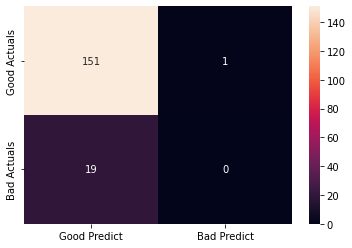

[INFO] f1-score of the LogisticRegression model is 88.30 %

[INFO] Detailed classification report for LogisticRegression model is: 

               precision    recall  f1-score   support

           0       0.89      0.99      0.94       152
           1       0.00      0.00      0.00        19

    accuracy                           0.88       171
   macro avg       0.44      0.50      0.47       171
weighted avg       0.79      0.88      0.83       171



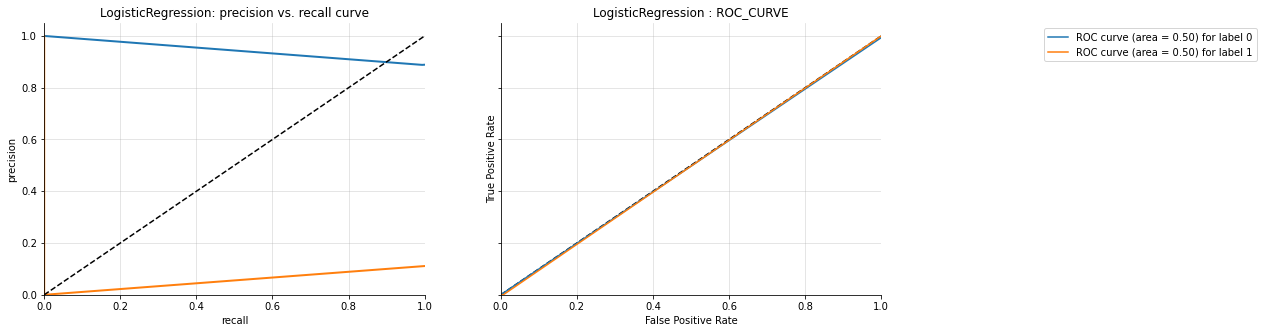


[INFO] End time:- 2021-11-28 12:24:02.511794. Total time taken 0.026837766666666665 minutes.


[INFO] Model pickle as trained_pickled/LogisticRegression_trained.pkl.
----------------------------------------------------------------------
2. KNeighborsClassifier Model with Normal dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 12:24:02.520827

[INFO] Model: KNeighborsClassifier()

[INFO] KNeighborsClassifier Model is defined.

[INFO] KNeighborsClassifier model fitting started at :- 2021-11-28 12:24:02.522841

[INFO] KNeighborsClassifier model fitting completed at :- 2021-11-28 12:24:02.568827

[INFO] KNeighborsClassifier model started GridSearch at :- 2021-11-28 12:24:02.568827.

Fitting 2 folds for each of 72 candidates, totalling 144 fits

[INFO] KNeighborsClassifier model having best accuracy of 88.65 using {'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 9, 'p': 1} parameters.

[INFO] KNeighborsClass

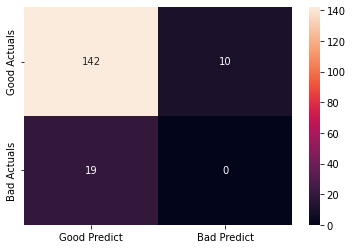

[INFO] f1-score of the KNeighborsClassifier model is 83.04 %

[INFO] Detailed classification report for KNeighborsClassifier model is: 

               precision    recall  f1-score   support

           0       0.88      0.93      0.91       152
           1       0.00      0.00      0.00        19

    accuracy                           0.83       171
   macro avg       0.44      0.47      0.45       171
weighted avg       0.78      0.83      0.81       171



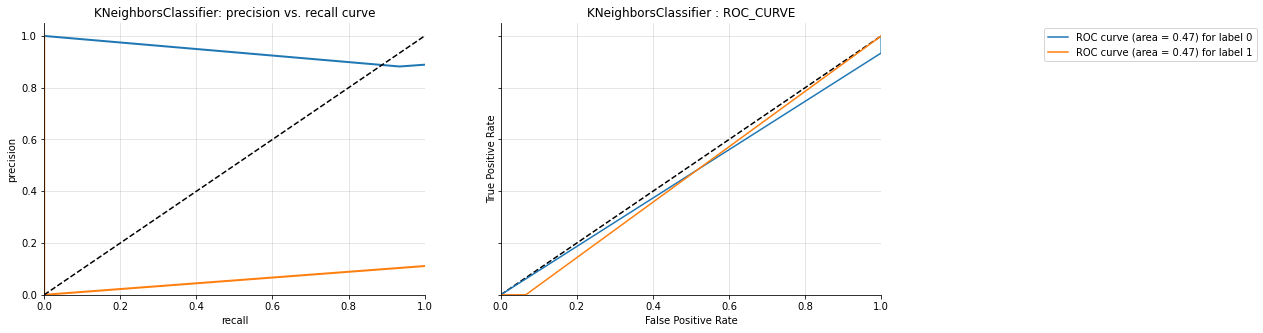


[INFO] End time:- 2021-11-28 12:24:07.680365. Total time taken 0.08599230000000001 minutes.


[INFO] Model pickle as trained_pickled/KNeighborsClassifier_trained.pkl.
----------------------------------------------------------------------
3. DecisionTreeClassifier Model with Normal dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 12:24:07.692361

[INFO] Model: DecisionTreeClassifier(class_weight='balanced', random_state=0)

[INFO] DecisionTreeClassifier Model is defined.

[INFO] DecisionTreeClassifier model fitting started at :- 2021-11-28 12:24:07.695362

[INFO] DecisionTreeClassifier model fitting completed at :- 2021-11-28 12:24:07.706368

[INFO] DecisionTreeClassifier model started GridSearch at :- 2021-11-28 12:24:07.706368.

Fitting 2 folds for each of 128 candidates, totalling 256 fits

[INFO] DecisionTreeClassifier model having best accuracy of 84.74 using {'criterion': 'gini', 'max_depth': None, 'max_f

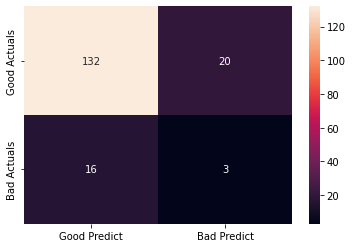

[INFO] f1-score of the DecisionTreeClassifier model is 78.95 %

[INFO] Detailed classification report for DecisionTreeClassifier model is: 

               precision    recall  f1-score   support

           0       0.89      0.87      0.88       152
           1       0.13      0.16      0.14        19

    accuracy                           0.79       171
   macro avg       0.51      0.51      0.51       171
weighted avg       0.81      0.79      0.80       171



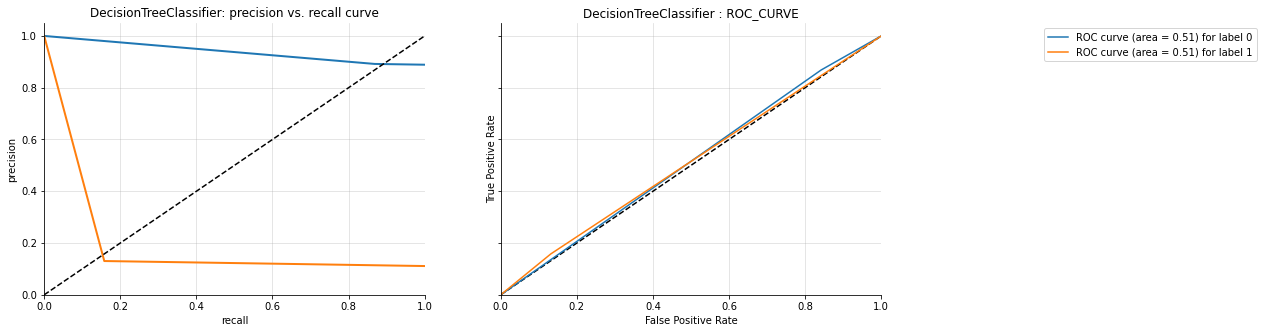


[INFO] End time:- 2021-11-28 12:24:11.042359. Total time taken 0.055833299999999995 minutes.


[INFO] Model pickle as trained_pickled/DecisionTreeClassifier_trained.pkl.
----------------------------------------------------------------------
4. RandomForestClassifier Model with Normal dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 12:24:11.049356

[INFO] Model: RandomForestClassifier(class_weight='balanced', random_state=0)

[INFO] RandomForestClassifier Model is defined.

[INFO] RandomForestClassifier model fitting started at :- 2021-11-28 12:24:11.052359

[INFO] RandomForestClassifier model fitting completed at :- 2021-11-28 12:24:11.247388

[INFO] RandomForestClassifier model started GridSearch at :- 2021-11-28 12:24:11.247388.

Fitting 2 folds for each of 768 candidates, totalling 1536 fits

[INFO] RandomForestClassifier model having best accuracy of 89.82 using {'criterion': 'gini', 'max_depth': None, 'm

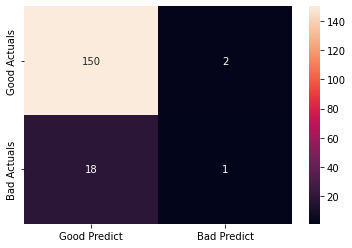

[INFO] f1-score of the RandomForestClassifier model is 88.30 %

[INFO] Detailed classification report for RandomForestClassifier model is: 

               precision    recall  f1-score   support

           0       0.89      0.99      0.94       152
           1       0.33      0.05      0.09        19

    accuracy                           0.88       171
   macro avg       0.61      0.52      0.51       171
weighted avg       0.83      0.88      0.84       171



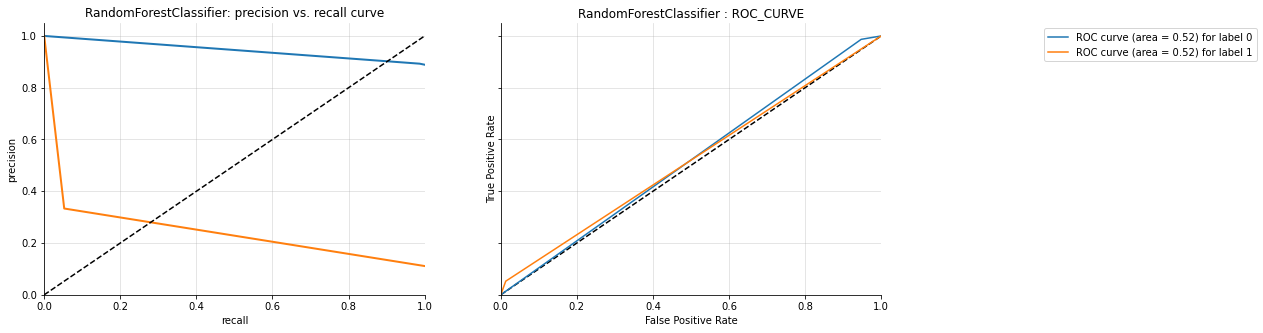


[INFO] End time:- 2021-11-28 12:34:50.435348. Total time taken 10.6564332 minutes.


[INFO] Model pickle as trained_pickled/RandomForestClassifier_trained.pkl.
----------------------------------------------------------------------
5. ExtraTreesClassifier Model with Normal dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 12:34:50.457348

[INFO] Model: ExtraTreesClassifier(class_weight='balanced', random_state=0)

[INFO] ExtraTreesClassifier Model is defined.

[INFO] ExtraTreesClassifier model fitting started at :- 2021-11-28 12:34:50.466528

[INFO] ExtraTreesClassifier model fitting completed at :- 2021-11-28 12:34:50.750403

[INFO] ExtraTreesClassifier model started GridSearch at :- 2021-11-28 12:34:50.750403.

Fitting 2 folds for each of 768 candidates, totalling 1536 fits

[INFO] ExtraTreesClassifier model having best accuracy of 89.04 using {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min

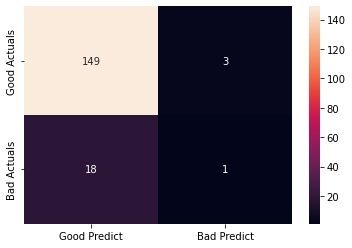

[INFO] f1-score of the ExtraTreesClassifier model is 87.72 %

[INFO] Detailed classification report for ExtraTreesClassifier model is: 

               precision    recall  f1-score   support

           0       0.89      0.98      0.93       152
           1       0.25      0.05      0.09        19

    accuracy                           0.88       171
   macro avg       0.57      0.52      0.51       171
weighted avg       0.82      0.88      0.84       171



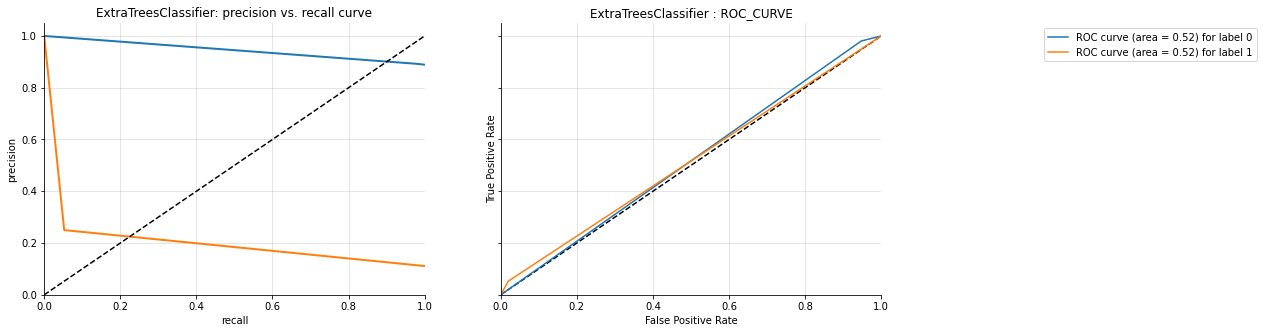


[INFO] End time:- 2021-11-28 12:39:05.701242. Total time taken 4.2540649 minutes.


[INFO] Model pickle as trained_pickled/ExtraTreesClassifier_trained.pkl.
----------------------------------------------------------------------
6. GradientBoostingClassifier Model with Normal dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 12:39:05.720408

[INFO] Model: GradientBoostingClassifier(random_state=0)

[INFO] GradientBoostingClassifier Model is defined.

[INFO] GradientBoostingClassifier model fitting started at :- 2021-11-28 12:39:05.730718

[INFO] GradientBoostingClassifier model fitting completed at :- 2021-11-28 12:39:05.947663

[INFO] GradientBoostingClassifier model started GridSearch at :- 2021-11-28 12:39:05.947663.

Fitting 2 folds for each of 5760 candidates, totalling 11520 fits

[INFO] GradientBoostingClassifier model having best accuracy of 89.63 using {'criterion': 'friedman_mse', 'learning_rate': 0.21

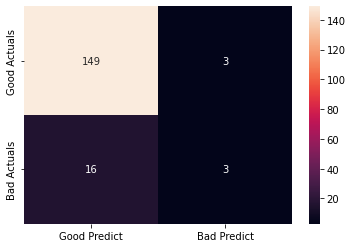

[INFO] f1-score of the GradientBoostingClassifier model is 88.89 %

[INFO] Detailed classification report for GradientBoostingClassifier model is: 

               precision    recall  f1-score   support

           0       0.90      0.98      0.94       152
           1       0.50      0.16      0.24        19

    accuracy                           0.89       171
   macro avg       0.70      0.57      0.59       171
weighted avg       0.86      0.89      0.86       171



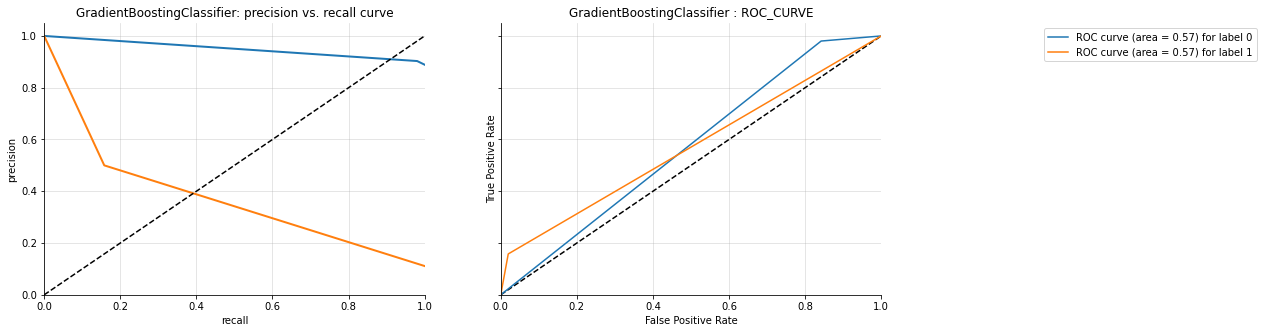


[INFO] End time:- 2021-11-28 13:33:38.977308. Total time taken 54.55428166666666 minutes.


[INFO] Model pickle as trained_pickled/GradientBoostingClassifier_trained.pkl.
----------------------------------------------------------------------
7. AdaBoostClassifier Model with Normal dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 13:33:38.985314

[INFO] Model: AdaBoostClassifier(random_state=0)

[INFO] AdaBoostClassifier Model is defined.

[INFO] AdaBoostClassifier model fitting started at :- 2021-11-28 13:33:38.993309

[INFO] AdaBoostClassifier model fitting completed at :- 2021-11-28 13:33:39.082349

[INFO] AdaBoostClassifier model started GridSearch at :- 2021-11-28 13:33:39.082349.

Fitting 2 folds for each of 30 candidates, totalling 60 fits

[INFO] AdaBoostClassifier model having best accuracy of 88.85 using {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 50} parameters.

[INFO] AdaBoostClas

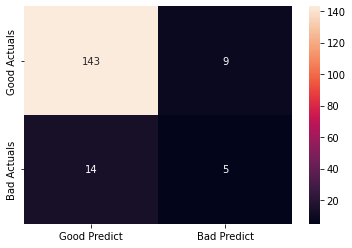

[INFO] f1-score of the AdaBoostClassifier model is 86.55 %

[INFO] Detailed classification report for AdaBoostClassifier model is: 

               precision    recall  f1-score   support

           0       0.91      0.94      0.93       152
           1       0.36      0.26      0.30        19

    accuracy                           0.87       171
   macro avg       0.63      0.60      0.61       171
weighted avg       0.85      0.87      0.86       171



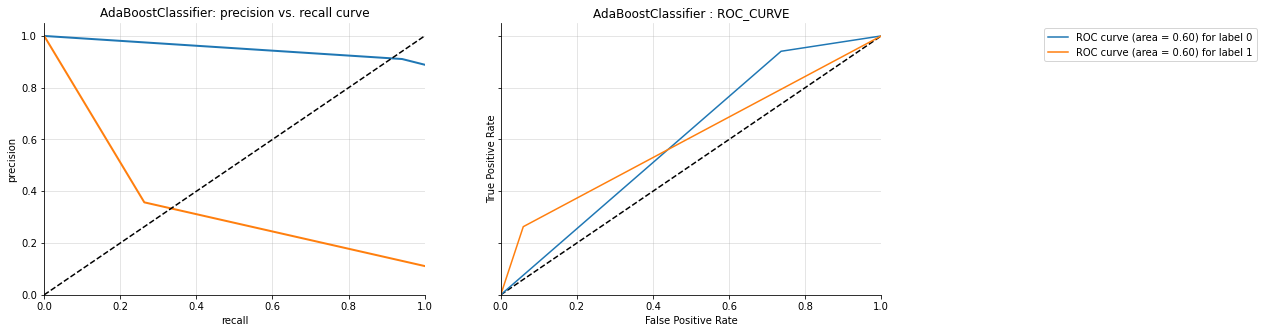


[INFO] End time:- 2021-11-28 13:33:49.035635. Total time taken 0.16750535 minutes.


[INFO] Model pickle as trained_pickled/AdaBoostClassifier_trained.pkl.
----------------------------------------------------------------------
8. LinearSVC Model with Normal dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 13:33:49.043639

[INFO] Model: LinearSVC(random_state=0)

[INFO] LinearSVC Model is defined.

[INFO] LinearSVC model fitting started at :- 2021-11-28 13:33:49.049642

[INFO] LinearSVC model fitting completed at :- 2021-11-28 13:33:49.069670

[INFO] LinearSVC model started GridSearch at :- 2021-11-28 13:33:49.069670.

Fitting 2 folds for each of 6 candidates, totalling 12 fits

[INFO] LinearSVC model having best accuracy of 88.85 using {'loss': 'hinge', 'penalty': 'l2'} parameters.

[INFO] LinearSVC model completed GridSearch at :- 2021-11-28 13:33:49.157410 .

[INFO] Train Accuracy of the LinearSVC model is 8

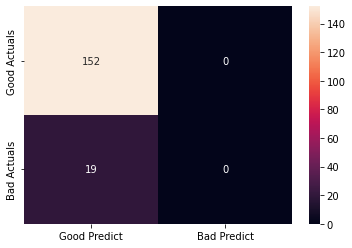

[INFO] f1-score of the LinearSVC model is 88.89 %

[INFO] Detailed classification report for LinearSVC model is: 

               precision    recall  f1-score   support

           0       0.89      1.00      0.94       152
           1       0.00      0.00      0.00        19

    accuracy                           0.89       171
   macro avg       0.44      0.50      0.47       171
weighted avg       0.79      0.89      0.84       171



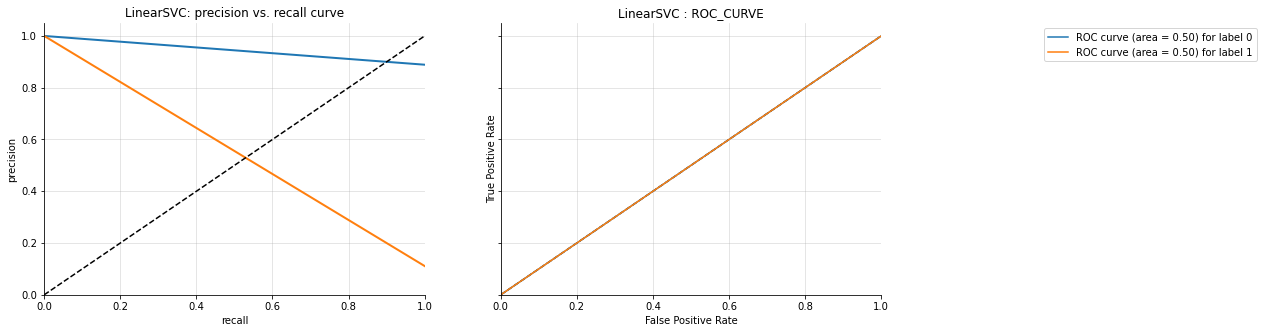


[INFO] End time:- 2021-11-28 13:33:49.789970. Total time taken 0.01243885 minutes.


[INFO] Model pickle as trained_pickled/LinearSVC_trained.pkl.
----------------------------------------------------------------------
9. XGBClassifier Model with Normal dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 13:33:49.795968

[INFO] Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_delta_step=None, max_depth=8,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=Non

[13:33:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:33:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:33:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:33:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:34:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:34:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:34:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:34:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:35:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:35:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:35:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:35:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:35:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:35:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:36:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:36:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:36:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:36:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:37:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:37:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:37:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:37:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:38:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:38:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:38:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:38:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:38:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:39:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:39:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:39:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:39:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:39:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:40:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:40:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:40:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:41:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:41:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:41:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:41:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:41:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:42:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:42:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

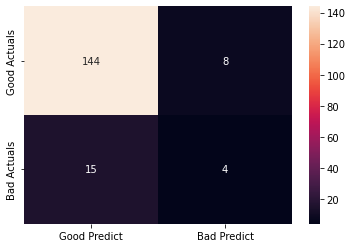

[INFO] f1-score of the XGBClassifier model is 86.55 %

[INFO] Detailed classification report for XGBClassifier model is: 

               precision    recall  f1-score   support

           0       0.91      0.95      0.93       152
           1       0.33      0.21      0.26        19

    accuracy                           0.87       171
   macro avg       0.62      0.58      0.59       171
weighted avg       0.84      0.87      0.85       171



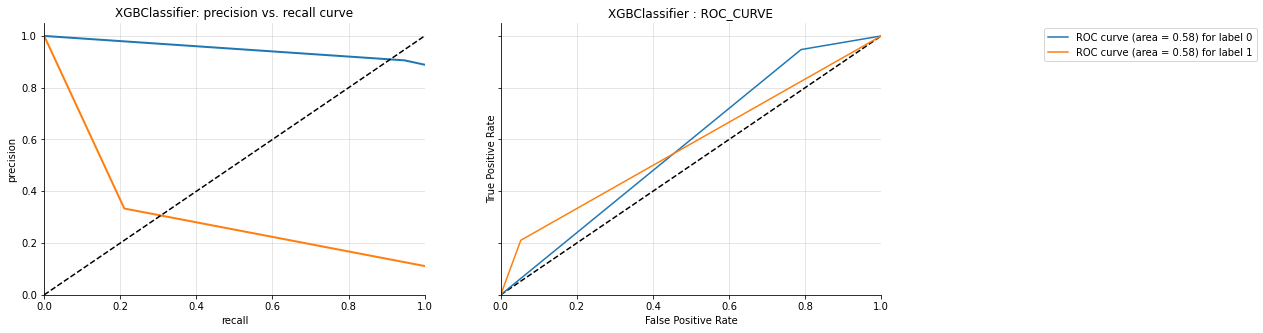


[INFO] End time:- 2021-11-28 13:42:05.708480. Total time taken 8.265208533333332 minutes.


[INFO] Model pickle as trained_pickled/XGBClassifier_trained.pkl.
----------------------------------------------------------------------
10. LGBMClassifier Model with Normal dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 13:42:05.745485

[INFO] Model: LGBMClassifier(learning_rate=0.05, max_depth=8, n_estimators=400,
               objective='binary')

[INFO] LGBMClassifier Model is defined.

[INFO] LGBMClassifier model fitting started at :- 2021-11-28 13:42:05.752514

[INFO] LGBMClassifier model fitting completed at :- 2021-11-28 13:42:05.959477

[INFO] LGBMClassifier model started GridSearch at :- 2021-11-28 13:42:05.960481.

Fitting 2 folds for each of 125 candidates, totalling 250 fits

[INFO] LGBMClassifier model having best accuracy of 89.43 using {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 7} par

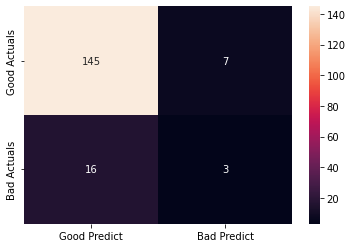

[INFO] f1-score of the LGBMClassifier model is 86.55 %

[INFO] Detailed classification report for LGBMClassifier model is: 

               precision    recall  f1-score   support

           0       0.90      0.95      0.93       152
           1       0.30      0.16      0.21        19

    accuracy                           0.87       171
   macro avg       0.60      0.56      0.57       171
weighted avg       0.83      0.87      0.85       171



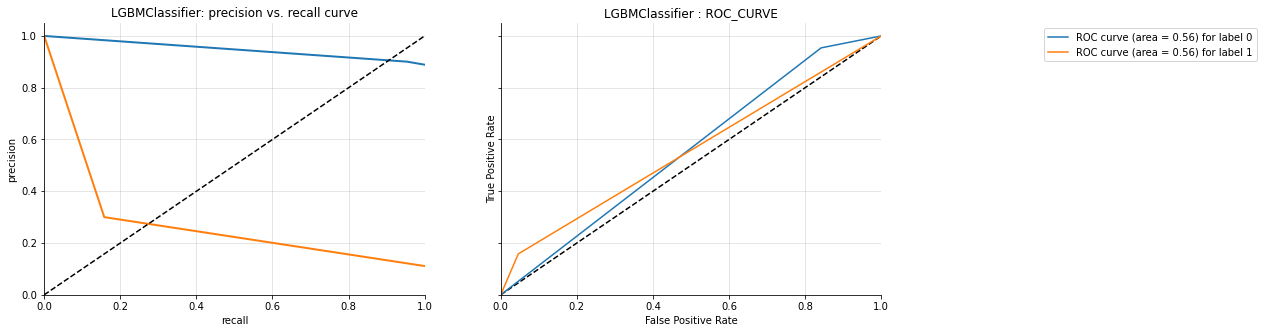


[INFO] End time:- 2021-11-28 13:42:22.354478. Total time taken 0.27681655000000005 minutes.


[INFO] Model pickle as trained_pickled/LGBMClassifier_trained.pkl.


Model Name Dataset  Train Accuracy  Test Accuracy  \
0  LogisticRegression          Normal  89.041096       88.304094       
1  KNeighborsClassifier        Normal  89.236791       83.040936       
2  DecisionTreeClassifier      Normal  100.000000      78.947368       
3  RandomForestClassifier      Normal  100.000000      88.304094       
4  ExtraTreesClassifier        Normal  100.000000      87.719298       
5  GradientBoostingClassifier  Normal  98.434442       88.888889       
6  AdaBoostClassifier          Normal  93.346380       86.549708       
7  LinearSVC                   Normal  88.845401       88.888889       
8  XGBClassifier               Normal  100.000000      86.549708       
9  LGBMClassifier              Normal  100.000000      86.549708       

                                    F1 Score  \
0  [0.937888198757764, 0.0]                    
1  [0.9073482428115016, 0.0]                   
2  [0.88, 0.14285714285714288]                 
3  [0.9375, 0.09090909090909091]               
4  [0.9341692789968651, 0.08695652173913043]   
5  [0.9400630914826498, 0.23999999999999996]   
6  [0.9255663430420712, 0.30303030303030304]   
7  [0.9411764705882353, 0.0]                   
8  [0.9260450160771704, 0.2580645161290323]    
9  [0.9265175718849841, 0.20689655172413793]   

                                   Precision  \
0  [0.888235294117647, 0.0]                    
1  [0.8819875776397516, 0.0]                   
2  [0.8918918918918919, 0.13043478260869565]   
3  [0.8928571428571429, 0.3333333333333333]    
4  [0.8922155688622755, 0.25]                  
5  [0.9030303030303031, 0.5]                   
6  [0.910828025477707, 0.35714285714285715]    
7  [0.8888888888888888, 0.0]                   
8  [0.9056603773584906, 0.3333333333333333]    
9  [0.9006211180124224, 0.3]                   

                                      Recall    Support  \
0  [0.993421052631579, 0.0]                   [152, 19]   
1  [0.9342105263157895, 0.0]                  [152, 19]   
2  [0.868421052631579, 0.15789473684210525]   [152, 19]   
3  [0.9868421052631579, 0.05263157894736842]  [152, 19]   
4  [0.9802631578947368, 0.05263157894736842]  [152, 19]   
5  [0.9802631578947368, 0.15789473684210525]  [152, 19]   
6  [0.9407894736842105, 0.2631578947368421]   [152, 19]   
7  [1.0, 0.0]                                 [152, 19]   
8  [0.9473684210526315, 0.21052631578947367]  [152, 19]   
9  [0.9539473684210527, 0.15789473684210525]  [152, 19]   

   Total Run Time (In Minutes)  Grid Search Best Accuracy  \
0  0.026838                     88.845741                   
1  0.085992                     88.650429                   
2  0.055833                     84.736520                   
3  10.656433                    89.823836                   
4  4.254065                     89.041820                   
5  54.554282                    89.626991                   
6  0.167505                     88.845741                   
7  0.012439                     88.845741                   
8  8.265209                     89.431679                   
9  0.276817                     89.432445                   

                                                                                                                                                  Grid Search Best Parameters  
0  {'C': 0.001, 'penalty': 'l2', 'solver': 'sag'}                                                                                                                              
1  {'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 9, 'p': 1}                                                                                                          
2  {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2}                                                                                    
3  {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}           

In [444]:
run_models(models=models,
           X_train=X_train,
           y_train=y_train,
           X_test=X_test,
           y_test=y_test,
           n_classes=n_classes,
           N_SPLITS=N_SPLITS,
           grid_search=True,
           CV=CV,
           tabular=True,
           detailed=True,
           reset_output_pd=True)

In [445]:
# Let us scale train as well as test data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

----------------------------------------------------------------------
1. LogisticRegression Model with Normalized dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 13:42:22.485483

[INFO] Model: LogisticRegression(C=0.5, random_state=0, solver='liblinear')

[INFO] LogisticRegression Model is defined.

[INFO] LogisticRegression model fitting started at :- 2021-11-28 13:42:22.496481

[INFO] LogisticRegression model fitting completed at :- 2021-11-28 13:42:22.500479

[INFO] LogisticRegression model started GridSearch at :- 2021-11-28 13:42:22.500479.

Fitting 2 folds for each of 16 candidates, totalling 32 fits

[INFO] LogisticRegression model having best accuracy of 88.85 using {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'} parameters.

[INFO] LogisticRegression model completed GridSearch at :- 2021-11-28 13:42:22.581479 .

[INFO] Train Accuracy of the LogisticRegression model is 88.85 %

[INFO] Test Accura

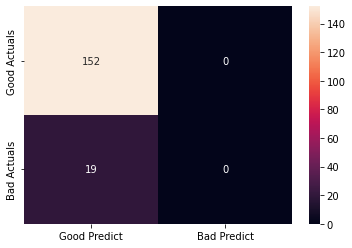

[INFO] f1-score of the LogisticRegression model is 88.89 %

[INFO] Detailed classification report for LogisticRegression model is: 

               precision    recall  f1-score   support

           0       0.89      1.00      0.94       152
           1       0.00      0.00      0.00        19

    accuracy                           0.89       171
   macro avg       0.44      0.50      0.47       171
weighted avg       0.79      0.89      0.84       171



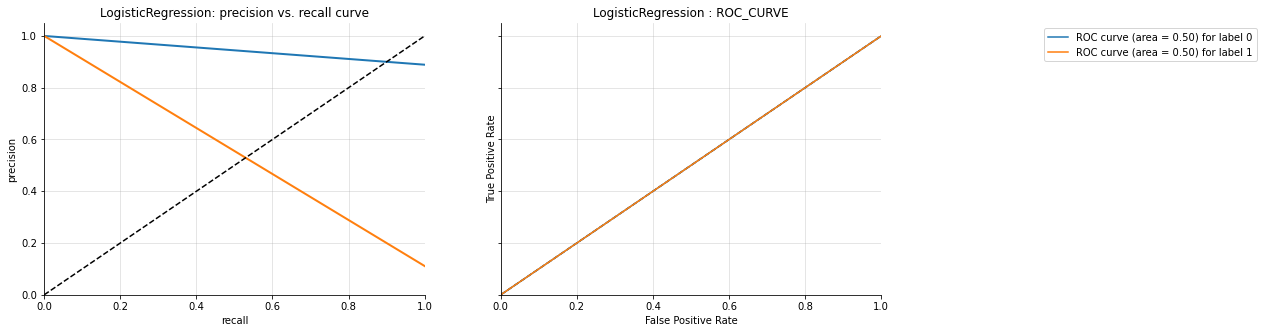


[INFO] End time:- 2021-11-28 13:42:22.981267. Total time taken 0.008263066666666668 minutes.


[INFO] Model pickle as trained_pickled/LogisticRegression_trained.pkl.
----------------------------------------------------------------------
2. KNeighborsClassifier Model with Normalized dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 13:42:22.987269

[INFO] Model: KNeighborsClassifier()

[INFO] KNeighborsClassifier Model is defined.

[INFO] KNeighborsClassifier model fitting started at :- 2021-11-28 13:42:22.992269

[INFO] KNeighborsClassifier model fitting completed at :- 2021-11-28 13:42:23.013267

[INFO] KNeighborsClassifier model started GridSearch at :- 2021-11-28 13:42:23.013267.

Fitting 2 folds for each of 72 candidates, totalling 144 fits

[INFO] KNeighborsClassifier model having best accuracy of 88.26 using {'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1} parameters.

[INFO] KNeighborsC

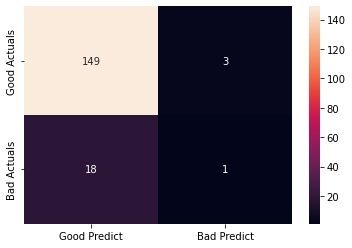

[INFO] f1-score of the KNeighborsClassifier model is 87.72 %

[INFO] Detailed classification report for KNeighborsClassifier model is: 

               precision    recall  f1-score   support

           0       0.89      0.98      0.93       152
           1       0.25      0.05      0.09        19

    accuracy                           0.88       171
   macro avg       0.57      0.52      0.51       171
weighted avg       0.82      0.88      0.84       171



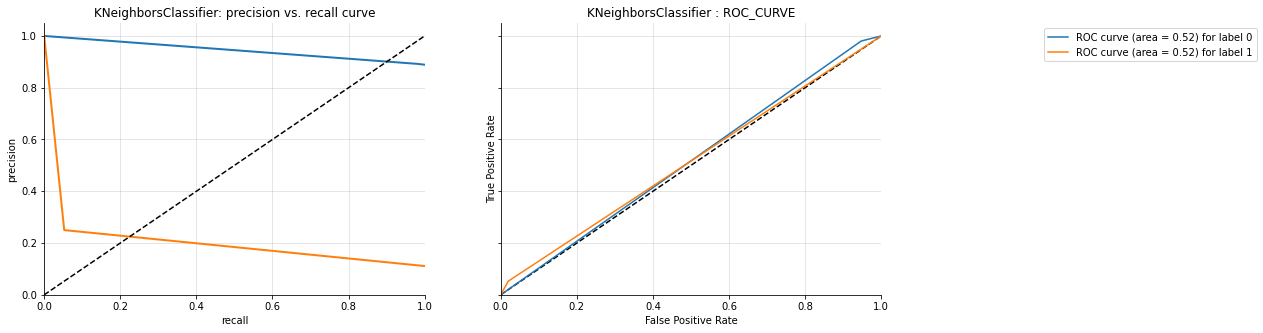


[INFO] End time:- 2021-11-28 13:42:24.895269. Total time taken 0.0318 minutes.


[INFO] Model pickle as trained_pickled/KNeighborsClassifier_trained.pkl.
----------------------------------------------------------------------
3. DecisionTreeClassifier Model with Normalized dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 13:42:24.902267

[INFO] Model: DecisionTreeClassifier(class_weight='balanced', random_state=0)

[INFO] DecisionTreeClassifier Model is defined.

[INFO] DecisionTreeClassifier model fitting started at :- 2021-11-28 13:42:24.907266

[INFO] DecisionTreeClassifier model fitting completed at :- 2021-11-28 13:42:24.910264

[INFO] DecisionTreeClassifier model started GridSearch at :- 2021-11-28 13:42:24.910264.

Fitting 2 folds for each of 128 candidates, totalling 256 fits

[INFO] DecisionTreeClassifier model having best accuracy of 84.74 using {'criterion': 'gini', 'max_depth': None, 'max_features':

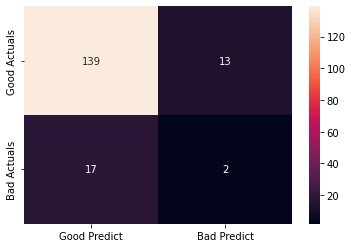

[INFO] f1-score of the DecisionTreeClassifier model is 82.46 %

[INFO] Detailed classification report for DecisionTreeClassifier model is: 

               precision    recall  f1-score   support

           0       0.89      0.91      0.90       152
           1       0.13      0.11      0.12        19

    accuracy                           0.82       171
   macro avg       0.51      0.51      0.51       171
weighted avg       0.81      0.82      0.82       171



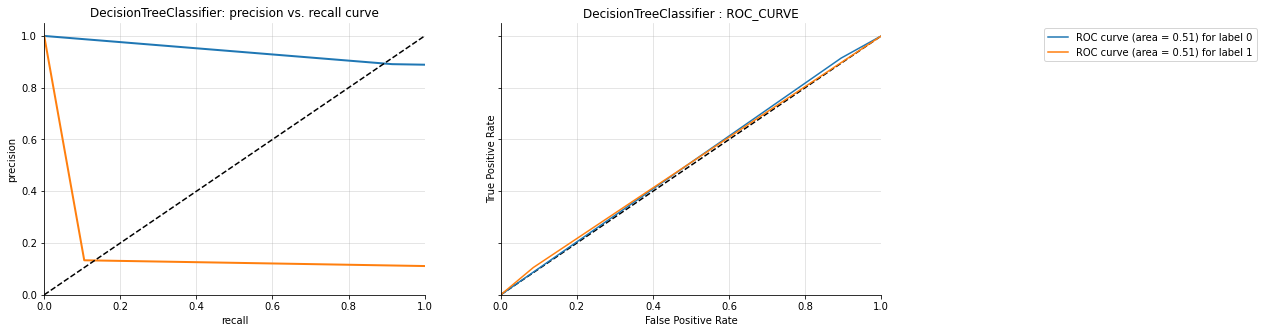


[INFO] End time:- 2021-11-28 13:42:25.921265. Total time taken 0.0169833 minutes.


[INFO] Model pickle as trained_pickled/DecisionTreeClassifier_trained.pkl.
----------------------------------------------------------------------
4. RandomForestClassifier Model with Normalized dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 13:42:25.926275

[INFO] Model: RandomForestClassifier(class_weight='balanced', random_state=0)

[INFO] RandomForestClassifier Model is defined.

[INFO] RandomForestClassifier model fitting started at :- 2021-11-28 13:42:25.932266

[INFO] RandomForestClassifier model fitting completed at :- 2021-11-28 13:42:26.089269

[INFO] RandomForestClassifier model started GridSearch at :- 2021-11-28 13:42:26.089269.

Fitting 2 folds for each of 768 candidates, totalling 1536 fits

[INFO] RandomForestClassifier model having best accuracy of 89.82 using {'criterion': 'gini', 'max_depth': None, 'max_feat

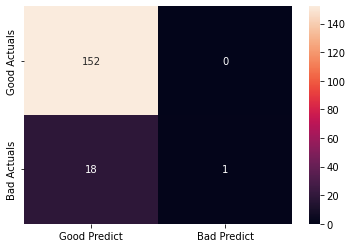

[INFO] f1-score of the RandomForestClassifier model is 89.47 %

[INFO] Detailed classification report for RandomForestClassifier model is: 

               precision    recall  f1-score   support

           0       0.89      1.00      0.94       152
           1       1.00      0.05      0.10        19

    accuracy                           0.89       171
   macro avg       0.95      0.53      0.52       171
weighted avg       0.91      0.89      0.85       171



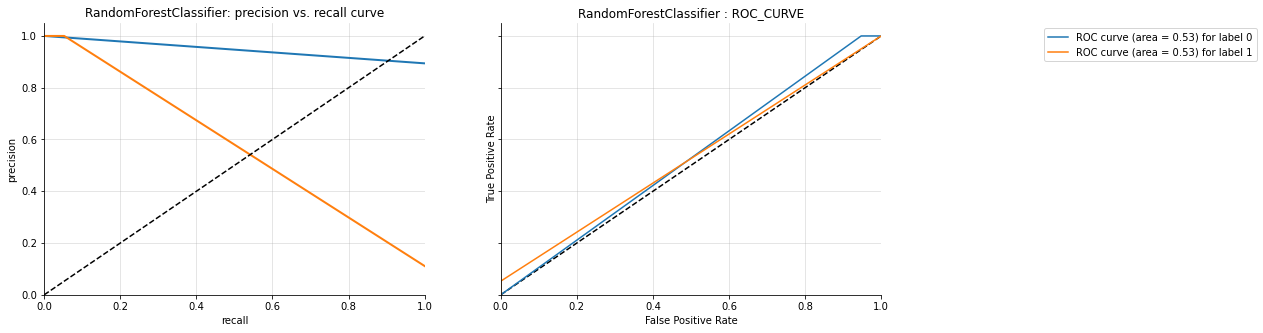


[INFO] End time:- 2021-11-28 13:47:12.297843. Total time taken 4.7728594666666675 minutes.


[INFO] Model pickle as trained_pickled/RandomForestClassifier_trained.pkl.
----------------------------------------------------------------------
5. ExtraTreesClassifier Model with Normalized dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 13:47:12.306844

[INFO] Model: ExtraTreesClassifier(class_weight='balanced', random_state=0)

[INFO] ExtraTreesClassifier Model is defined.

[INFO] ExtraTreesClassifier model fitting started at :- 2021-11-28 13:47:12.307845

[INFO] ExtraTreesClassifier model fitting completed at :- 2021-11-28 13:47:12.437843

[INFO] ExtraTreesClassifier model started GridSearch at :- 2021-11-28 13:47:12.437843.

Fitting 2 folds for each of 768 candidates, totalling 1536 fits

[INFO] ExtraTreesClassifier model having best accuracy of 89.04 using {'criterion': 'gini', 'max_depth': None, 'max_features'

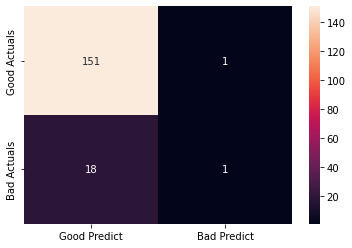

[INFO] f1-score of the ExtraTreesClassifier model is 88.89 %

[INFO] Detailed classification report for ExtraTreesClassifier model is: 

               precision    recall  f1-score   support

           0       0.89      0.99      0.94       152
           1       0.50      0.05      0.10        19

    accuracy                           0.89       171
   macro avg       0.70      0.52      0.52       171
weighted avg       0.85      0.89      0.85       171



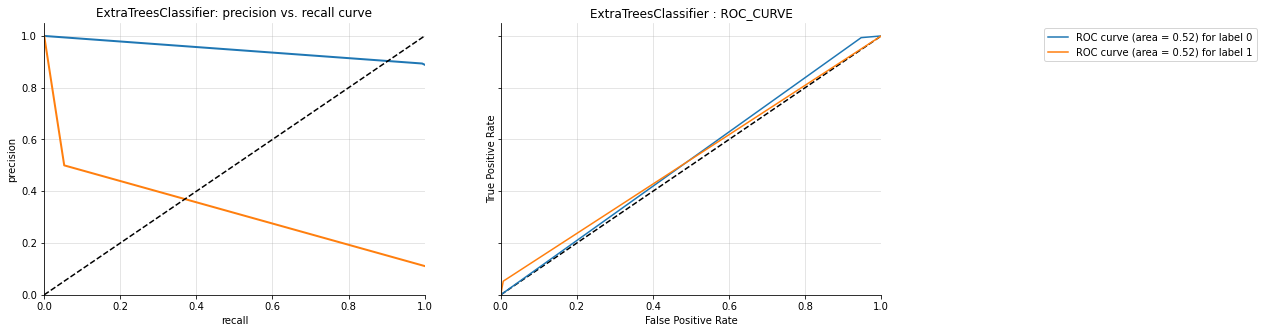


[INFO] End time:- 2021-11-28 13:48:53.679185. Total time taken 1.6895390166666668 minutes.


[INFO] Model pickle as trained_pickled/ExtraTreesClassifier_trained.pkl.
----------------------------------------------------------------------
6. GradientBoostingClassifier Model with Normalized dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 13:48:53.690222

[INFO] Model: GradientBoostingClassifier(random_state=0)

[INFO] GradientBoostingClassifier Model is defined.

[INFO] GradientBoostingClassifier model fitting started at :- 2021-11-28 13:48:53.692189

[INFO] GradientBoostingClassifier model fitting completed at :- 2021-11-28 13:48:53.809227

[INFO] GradientBoostingClassifier model started GridSearch at :- 2021-11-28 13:48:53.809227.

Fitting 2 folds for each of 5760 candidates, totalling 11520 fits

[INFO] GradientBoostingClassifier model having best accuracy of 89.63 using {'criterion': 'friedman_mse', 'learnin

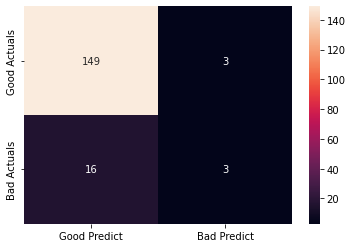

[INFO] f1-score of the GradientBoostingClassifier model is 88.89 %

[INFO] Detailed classification report for GradientBoostingClassifier model is: 

               precision    recall  f1-score   support

           0       0.90      0.98      0.94       152
           1       0.50      0.16      0.24        19

    accuracy                           0.89       171
   macro avg       0.70      0.57      0.59       171
weighted avg       0.86      0.89      0.86       171



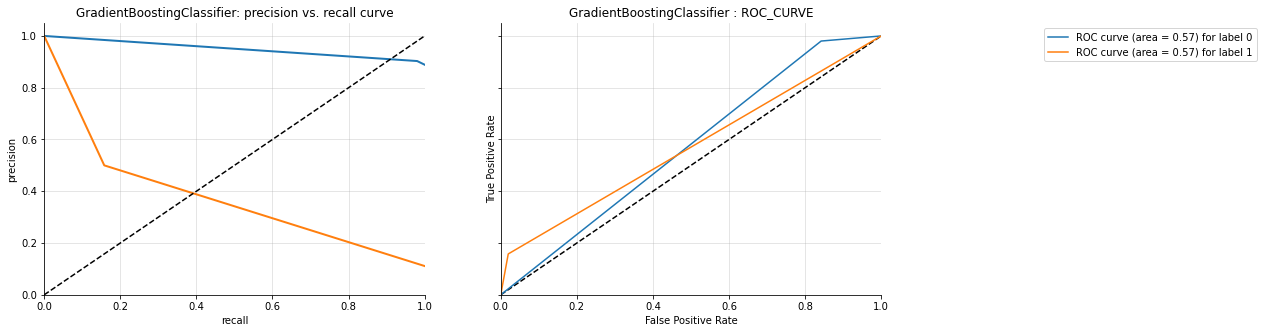


[INFO] End time:- 2021-11-28 14:14:04.019876. Total time taken 25.172160899999998 minutes.


[INFO] Model pickle as trained_pickled/GradientBoostingClassifier_trained.pkl.
----------------------------------------------------------------------
7. AdaBoostClassifier Model with Normalized dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 14:14:04.028875

[INFO] Model: AdaBoostClassifier(random_state=0)

[INFO] AdaBoostClassifier Model is defined.

[INFO] AdaBoostClassifier model fitting started at :- 2021-11-28 14:14:04.029881

[INFO] AdaBoostClassifier model fitting completed at :- 2021-11-28 14:14:04.109914

[INFO] AdaBoostClassifier model started GridSearch at :- 2021-11-28 14:14:04.109914.

Fitting 2 folds for each of 30 candidates, totalling 60 fits

[INFO] AdaBoostClassifier model having best accuracy of 88.85 using {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 50} parameters.

[INFO] AdaBoos

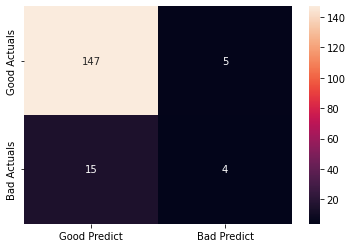

[INFO] f1-score of the AdaBoostClassifier model is 88.30 %

[INFO] Detailed classification report for AdaBoostClassifier model is: 

               precision    recall  f1-score   support

           0       0.91      0.97      0.94       152
           1       0.44      0.21      0.29        19

    accuracy                           0.88       171
   macro avg       0.68      0.59      0.61       171
weighted avg       0.86      0.88      0.86       171



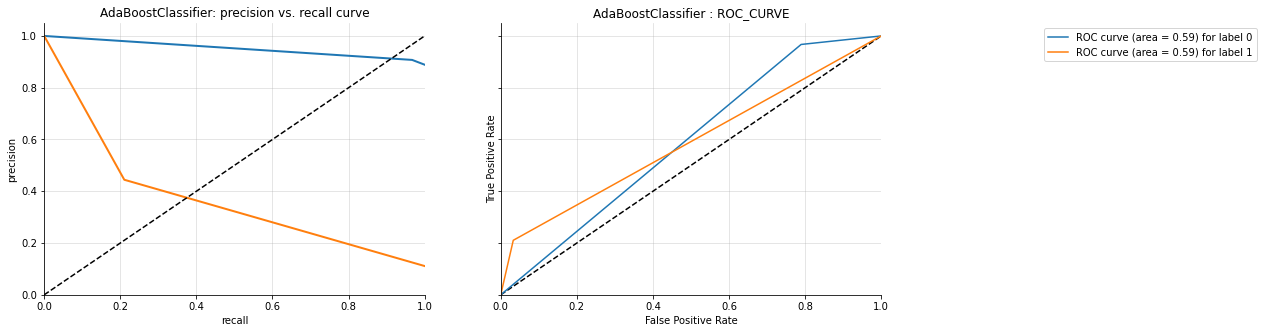


[INFO] End time:- 2021-11-28 14:14:13.632878. Total time taken 0.16006671666666666 minutes.


[INFO] Model pickle as trained_pickled/AdaBoostClassifier_trained.pkl.
----------------------------------------------------------------------
8. LinearSVC Model with Normalized dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 14:14:13.639876

[INFO] Model: LinearSVC(random_state=0)

[INFO] LinearSVC Model is defined.

[INFO] LinearSVC model fitting started at :- 2021-11-28 14:14:13.640875

[INFO] LinearSVC model fitting completed at :- 2021-11-28 14:14:13.644875

[INFO] LinearSVC model started GridSearch at :- 2021-11-28 14:14:13.644875.

Fitting 2 folds for each of 6 candidates, totalling 12 fits

[INFO] LinearSVC model having best accuracy of 88.85 using {'loss': 'hinge', 'penalty': 'l2'} parameters.

[INFO] LinearSVC model completed GridSearch at :- 2021-11-28 14:14:13.667910 .

[INFO] Train Accuracy of the LinearS

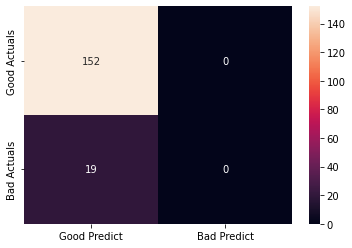

[INFO] f1-score of the LinearSVC model is 88.89 %

[INFO] Detailed classification report for LinearSVC model is: 

               precision    recall  f1-score   support

           0       0.89      1.00      0.94       152
           1       0.00      0.00      0.00        19

    accuracy                           0.89       171
   macro avg       0.44      0.50      0.47       171
weighted avg       0.79      0.89      0.84       171



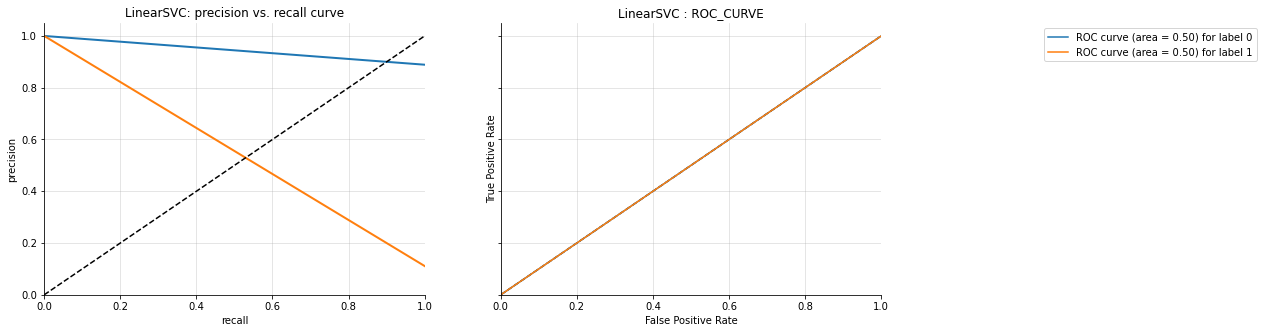


[INFO] End time:- 2021-11-28 14:14:14.034878. Total time taken 0.006583366666666667 minutes.


[INFO] Model pickle as trained_pickled/LinearSVC_trained.pkl.
----------------------------------------------------------------------
9. XGBClassifier Model with Normalized dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 14:14:14.040878

[INFO] Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_delta_step=None, max_depth=8,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_

[14:14:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:14:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:14:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:15:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:15:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:15:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:15:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:15:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:16:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:16:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:17:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:17:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:17:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:17:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:17:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:18:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:18:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:18:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:18:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:19:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:19:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:19:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:19:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:20:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:20:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:20:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:20:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:20:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:21:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:21:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:21:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:21:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:23:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:23:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:24:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

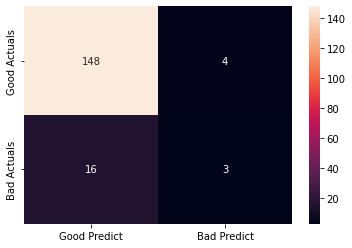

[INFO] f1-score of the XGBClassifier model is 88.30 %

[INFO] Detailed classification report for XGBClassifier model is: 

               precision    recall  f1-score   support

           0       0.90      0.97      0.94       152
           1       0.43      0.16      0.23        19

    accuracy                           0.88       171
   macro avg       0.67      0.57      0.58       171
weighted avg       0.85      0.88      0.86       171



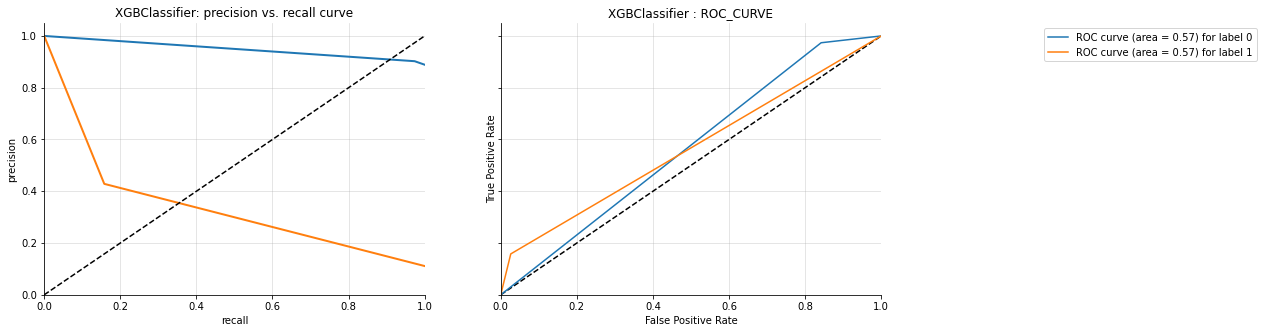


[INFO] End time:- 2021-11-28 14:24:21.347906. Total time taken 10.1217838 minutes.


[INFO] Model pickle as trained_pickled/XGBClassifier_trained.pkl.
----------------------------------------------------------------------
10. LGBMClassifier Model with Normalized dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 14:24:21.387909

[INFO] Model: LGBMClassifier(learning_rate=0.05, max_depth=8, n_estimators=400,
               objective='binary')

[INFO] LGBMClassifier Model is defined.

[INFO] LGBMClassifier model fitting started at :- 2021-11-28 14:24:21.389904

[INFO] LGBMClassifier model fitting completed at :- 2021-11-28 14:24:21.583902

[INFO] LGBMClassifier model started GridSearch at :- 2021-11-28 14:24:21.584904.

Fitting 2 folds for each of 125 candidates, totalling 250 fits

[INFO] LGBMClassifier model having best accuracy of 89.43 using {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 7} parame

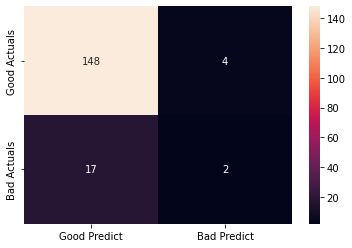

[INFO] f1-score of the LGBMClassifier model is 87.72 %

[INFO] Detailed classification report for LGBMClassifier model is: 

               precision    recall  f1-score   support

           0       0.90      0.97      0.93       152
           1       0.33      0.11      0.16        19

    accuracy                           0.88       171
   macro avg       0.62      0.54      0.55       171
weighted avg       0.83      0.88      0.85       171



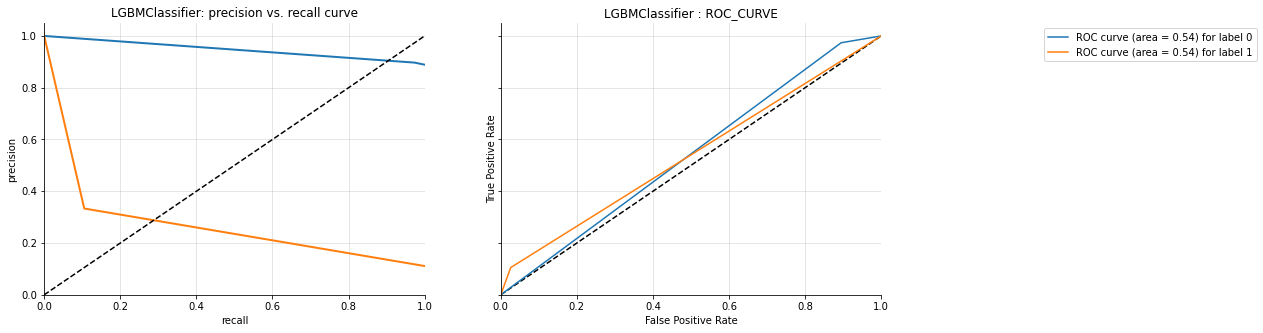


[INFO] End time:- 2021-11-28 14:24:36.234416. Total time taken 0.24744178333333336 minutes.


[INFO] Model pickle as trained_pickled/LGBMClassifier_trained.pkl.


Model Name     Dataset  Train Accuracy  Test Accuracy  \
0   LogisticRegression          Normal      89.041096       88.304094       
1   KNeighborsClassifier        Normal      89.236791       83.040936       
2   DecisionTreeClassifier      Normal      100.000000      78.947368       
3   RandomForestClassifier      Normal      100.000000      88.304094       
4   ExtraTreesClassifier        Normal      100.000000      87.719298       
5   GradientBoostingClassifier  Normal      98.434442       88.888889       
6   AdaBoostClassifier          Normal      93.346380       86.549708       
7   LinearSVC                   Normal      88.845401       88.888889       
8   XGBClassifier               Normal      100.000000      86.549708       
9   LGBMClassifier              Normal      100.000000      86.549708       
10  LogisticRegression          Normalized  88.845401       88.888889       
11  KNeighborsClassifier        Normalized  90.215264       87.719298       
12  DecisionTreeClassifier      Normalized  100.000000      82.456140       
13  RandomForestClassifier      Normalized  100.000000      89.473684       
14  ExtraTreesClassifier        Normalized  100.000000      88.888889       
15  GradientBoostingClassifier  Normalized  98.434442       88.888889       
16  AdaBoostClassifier          Normalized  93.346380       88.304094       
17  LinearSVC                   Normalized  88.845401       88.888889       
18  XGBClassifier               Normalized  100.000000      88.304094       
19  LGBMClassifier              Normalized  100.000000      87.719298       

                                     F1 Score  \
0   [0.937888198757764, 0.0]                    
1   [0.9073482428115016, 0.0]                   
2   [0.88, 0.14285714285714288]                 
3   [0.9375, 0.09090909090909091]               
4   [0.9341692789968651, 0.08695652173913043]   
5   [0.9400630914826498, 0.23999999999999996]   
6   [0.9255663430420712, 0.30303030303030304]   
7   [0.9411764705882353, 0.0]                   
8   [0.9260450160771704, 0.2580645161290323]    
9   [0.9265175718849841, 0.20689655172413793]   
10  [0.9411764705882353, 0.0]                   
11  [0.9341692789968651, 0.08695652173913043]   
12  [0.9025974025974026, 0.11764705882352941]   
13  [0.9440993788819877, 0.1]                   
14  [0.940809968847352, 0.09523809523809525]    
15  [0.9400630914826498, 0.23999999999999996]   
16  [0.9363057324840764, 0.2857142857142857]    
17  [0.9411764705882353, 0.0]                   
18  [0.9367088607594938, 0.23076923076923078]   
19  [0.9337539432176656, 0.16]                  

                                    Precision  \
0   [0.888235294117647, 0.0]                    
1   [0.8819875776397516, 0.0]                   
2   [0.8918918918918919, 0.13043478260869565]   
3   [0.8928571428571429, 0.3333333333333333]    
4   [0.8922155688622755, 0.25]                  
5   [0.9030303030303031, 0.5]                   
6   [0.910828025477707, 0.35714285714285715]    
7   [0.8888888888888888, 0.0]                   
8   [0.9056603773584906, 0.3333333333333333]    
9   [0.9006211180124224, 0.3]                   
10  [0.8888888888888888, 0.0]                   
11  [0.8922155688622755, 0.25]                  
12  [0.8910256410256411, 0.13333333333333333]   
13  [0.8941176470588236, 1.0]                   
14  [0.893491124260355, 0.5]                    
15  [0.9030303030303031, 0.5]                   
16  [0.9074074074074074, 0.4444444444444444]    
17  [0.8888888888888888, 0.0]                   
18  [0.9024390243902439, 0.42857142857142855]   
19  [0.896969696969697, 0.3333333333333333]     

                                       Recall    Support  \
0   [0.993421052631579, 0.0]                   [152, 19]   
1   [0.9342105263157895, 0.0]                  [152, 19]   
2   [0.868421052631579, 0.15789473684210525]   [152, 19]   
3   [0.9868421052631579, 0.05263157894736842]  [152, 19]   
4   [0.9802631578947368, 0.052631578947368

In [446]:
run_models(models=models,
           X_train=X_train_scaled,
           y_train=y_train,
           X_test=X_test_scaled,
           y_test=y_test,
           n_classes=n_classes,
           N_SPLITS=N_SPLITS,
           grid_search=True,
           CV=CV,
           tabular=True,
           detailed=True,
           dataset_type='Normalized',
           reset_output_pd=False)

In [447]:
# initializing SMOTE
smote_sampler = SMOTE(sampling_strategy='auto',
                random_state=1,
                k_neighbors=2,
                n_jobs=None,)
# fitting X and y with SMOTE
X,y = smote_sampler.fit_resample(np.array(X),y.ravel())

In [453]:
# split data into train subset and test subset
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

# checking the dimensions of the train & test subset
# printing dimension of train set
print(X_train_smote.shape)
# printing dimension of test set
print(X_test_smote.shape)

(909, 10)
(303, 10)


----------------------------------------------------------------------
1. LogisticRegression Model with Normal with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 14:29:52.833265

[INFO] Model: LogisticRegression(C=0.5, random_state=0, solver='liblinear')

[INFO] LogisticRegression Model is defined.

[INFO] LogisticRegression model fitting started at :- 2021-11-28 14:29:52.836269

[INFO] LogisticRegression model fitting completed at :- 2021-11-28 14:29:52.846266

[INFO] LogisticRegression model started GridSearch at :- 2021-11-28 14:29:52.846266.

Fitting 2 folds for each of 16 candidates, totalling 32 fits

[INFO] LogisticRegression model having best accuracy of 64.47 using {'C': 1.001, 'penalty': 'l2', 'solver': 'liblinear'} parameters.

[INFO] LogisticRegression model completed GridSearch at :- 2021-11-28 14:29:53.094234 .

[INFO] Train Accuracy of the LogisticRegression model is 63.48 %

[INFO] Test

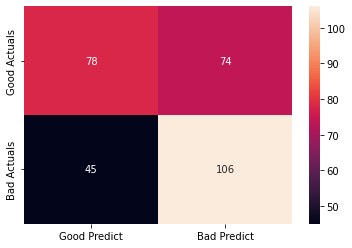

[INFO] f1-score of the LogisticRegression model is 60.73 %

[INFO] Detailed classification report for LogisticRegression model is: 

               precision    recall  f1-score   support

           0       0.63      0.51      0.57       152
           1       0.59      0.70      0.64       151

    accuracy                           0.61       303
   macro avg       0.61      0.61      0.60       303
weighted avg       0.61      0.61      0.60       303



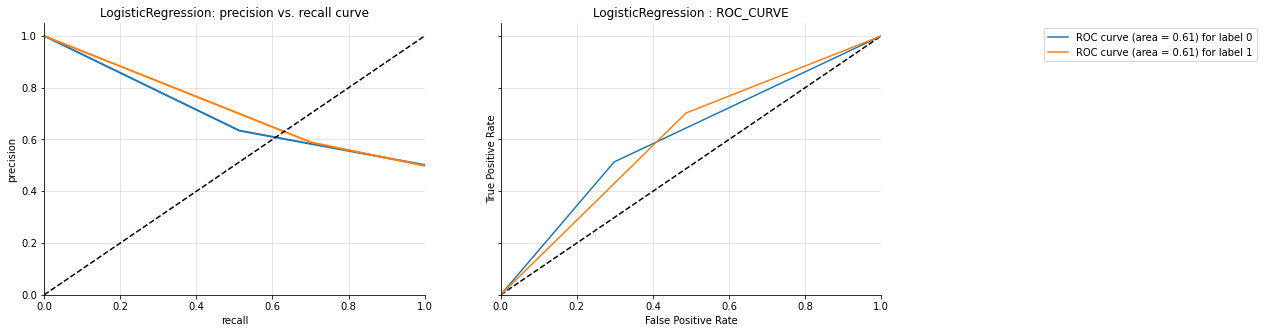


[INFO] End time:- 2021-11-28 14:29:54.046608. Total time taken 0.020222383333333333 minutes.


[INFO] Model pickle as trained_pickled/LogisticRegression_trained.pkl.
----------------------------------------------------------------------
2. KNeighborsClassifier Model with Normal with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 14:29:54.058004

[INFO] Model: KNeighborsClassifier()

[INFO] KNeighborsClassifier Model is defined.

[INFO] KNeighborsClassifier model fitting started at :- 2021-11-28 14:29:54.060005

[INFO] KNeighborsClassifier model fitting completed at :- 2021-11-28 14:29:54.133060

[INFO] KNeighborsClassifier model started GridSearch at :- 2021-11-28 14:29:54.134067.

Fitting 2 folds for each of 72 candidates, totalling 144 fits

[INFO] KNeighborsClassifier model having best accuracy of 77.34 using {'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 3, 'p': 1} parameters.

[INFO] KNei

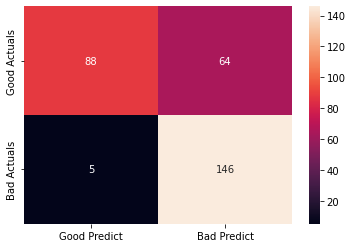

[INFO] f1-score of the KNeighborsClassifier model is 77.23 %

[INFO] Detailed classification report for KNeighborsClassifier model is: 

               precision    recall  f1-score   support

           0       0.95      0.58      0.72       152
           1       0.70      0.97      0.81       151

    accuracy                           0.77       303
   macro avg       0.82      0.77      0.76       303
weighted avg       0.82      0.77      0.76       303



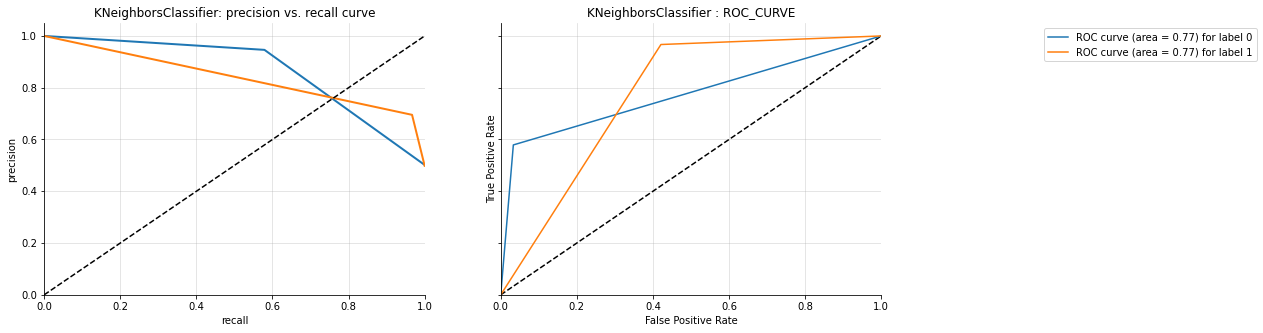


[INFO] End time:- 2021-11-28 14:29:59.818891. Total time taken 0.09601478333333334 minutes.


[INFO] Model pickle as trained_pickled/KNeighborsClassifier_trained.pkl.
----------------------------------------------------------------------
3. DecisionTreeClassifier Model with Normal with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 14:29:59.826819

[INFO] Model: DecisionTreeClassifier(class_weight='balanced', random_state=0)

[INFO] DecisionTreeClassifier Model is defined.

[INFO] DecisionTreeClassifier model fitting started at :- 2021-11-28 14:29:59.827819

[INFO] DecisionTreeClassifier model fitting completed at :- 2021-11-28 14:29:59.835824

[INFO] DecisionTreeClassifier model started GridSearch at :- 2021-11-28 14:29:59.835824.

Fitting 2 folds for each of 128 candidates, totalling 256 fits

[INFO] DecisionTreeClassifier model having best accuracy of 80.97 using {'criterion': 'entropy', 'max_depth'

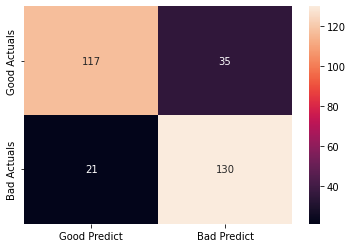

[INFO] f1-score of the DecisionTreeClassifier model is 81.52 %

[INFO] Detailed classification report for DecisionTreeClassifier model is: 

               precision    recall  f1-score   support

           0       0.85      0.77      0.81       152
           1       0.79      0.86      0.82       151

    accuracy                           0.82       303
   macro avg       0.82      0.82      0.81       303
weighted avg       0.82      0.82      0.81       303



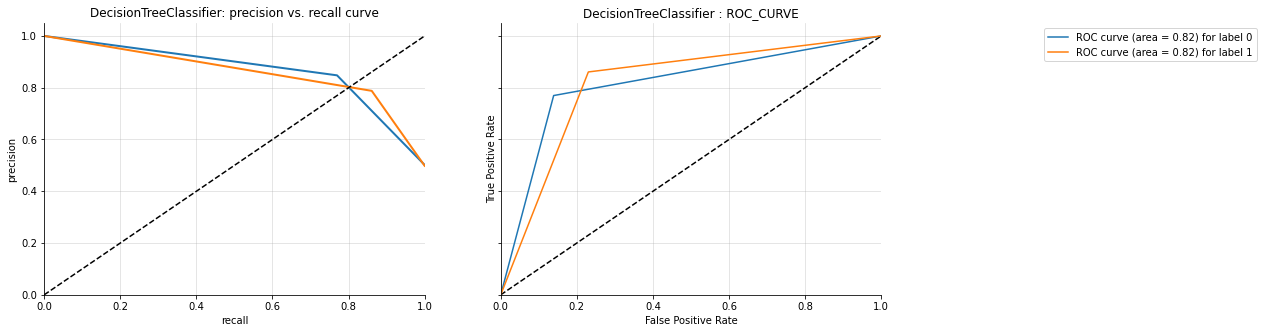


[INFO] End time:- 2021-11-28 14:30:01.889078. Total time taken 0.034370983333333334 minutes.


[INFO] Model pickle as trained_pickled/DecisionTreeClassifier_trained.pkl.
----------------------------------------------------------------------
4. RandomForestClassifier Model with Normal with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 14:30:01.896079

[INFO] Model: RandomForestClassifier(class_weight='balanced', random_state=0)

[INFO] RandomForestClassifier Model is defined.

[INFO] RandomForestClassifier model fitting started at :- 2021-11-28 14:30:01.898080

[INFO] RandomForestClassifier model fitting completed at :- 2021-11-28 14:30:02.261197

[INFO] RandomForestClassifier model started GridSearch at :- 2021-11-28 14:30:02.261468.

Fitting 2 folds for each of 768 candidates, totalling 1536 fits

[INFO] RandomForestClassifier model having best accuracy of 87.13 using {'criterion': 'entropy', 'max_de

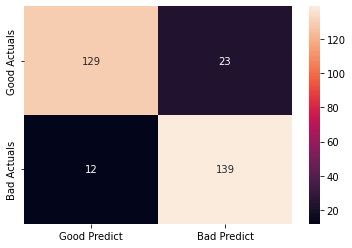

[INFO] f1-score of the RandomForestClassifier model is 88.45 %

[INFO] Detailed classification report for RandomForestClassifier model is: 

               precision    recall  f1-score   support

           0       0.91      0.85      0.88       152
           1       0.86      0.92      0.89       151

    accuracy                           0.88       303
   macro avg       0.89      0.88      0.88       303
weighted avg       0.89      0.88      0.88       303



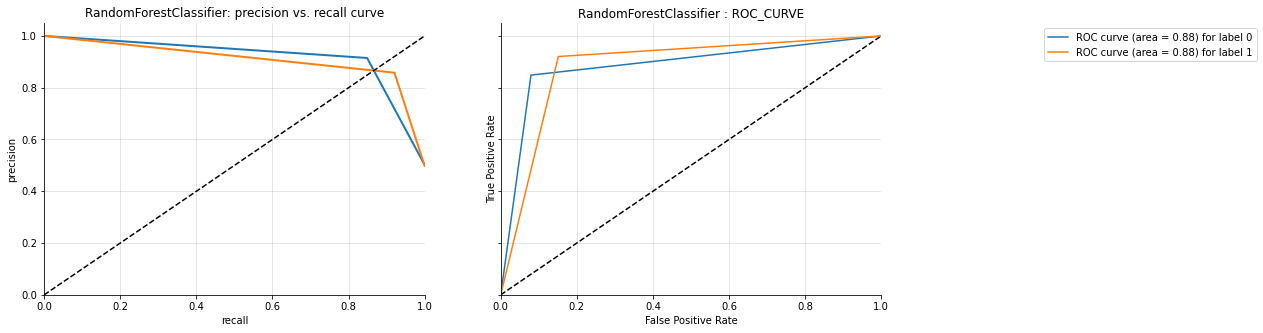


[INFO] End time:- 2021-11-28 14:46:56.959199. Total time taken 16.917718666666666 minutes.


[INFO] Model pickle as trained_pickled/RandomForestClassifier_trained.pkl.
----------------------------------------------------------------------
5. ExtraTreesClassifier Model with Normal with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 14:46:56.994346

[INFO] Model: ExtraTreesClassifier(class_weight='balanced', random_state=0)

[INFO] ExtraTreesClassifier Model is defined.

[INFO] ExtraTreesClassifier model fitting started at :- 2021-11-28 14:46:56.998395

[INFO] ExtraTreesClassifier model fitting completed at :- 2021-11-28 14:46:57.522368

[INFO] ExtraTreesClassifier model started GridSearch at :- 2021-11-28 14:46:57.522368.

Fitting 2 folds for each of 768 candidates, totalling 1536 fits

[INFO] ExtraTreesClassifier model having best accuracy of 89.99 using {'criterion': 'entropy', 'max_depth': 20, 'max_f

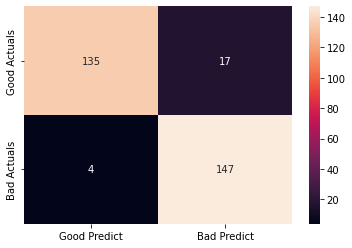

[INFO] f1-score of the ExtraTreesClassifier model is 93.07 %

[INFO] Detailed classification report for ExtraTreesClassifier model is: 

               precision    recall  f1-score   support

           0       0.97      0.89      0.93       152
           1       0.90      0.97      0.93       151

    accuracy                           0.93       303
   macro avg       0.93      0.93      0.93       303
weighted avg       0.93      0.93      0.93       303



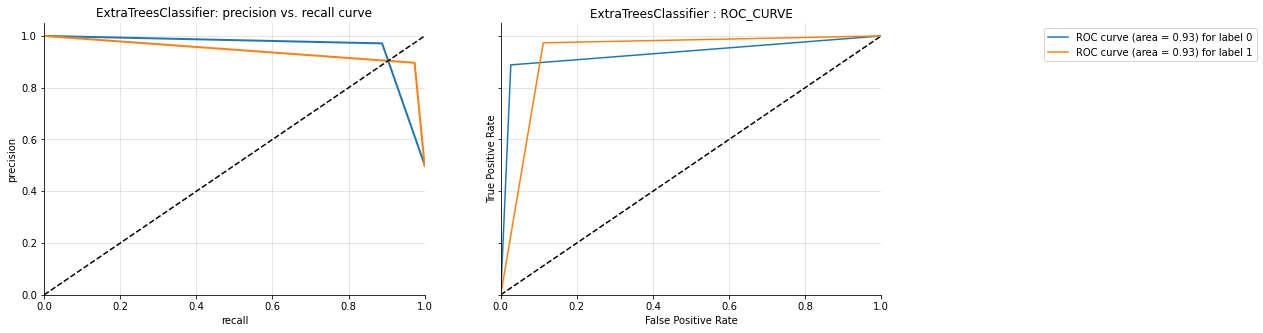


[INFO] End time:- 2021-11-28 14:52:20.954845. Total time taken 5.39934165 minutes.


[INFO] Model pickle as trained_pickled/ExtraTreesClassifier_trained.pkl.
----------------------------------------------------------------------
6. GradientBoostingClassifier Model with Normal with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 14:52:20.983263

[INFO] Model: GradientBoostingClassifier(random_state=0)

[INFO] GradientBoostingClassifier Model is defined.

[INFO] GradientBoostingClassifier model fitting started at :- 2021-11-28 14:52:20.985262

[INFO] GradientBoostingClassifier model fitting completed at :- 2021-11-28 14:52:21.709979

[INFO] GradientBoostingClassifier model started GridSearch at :- 2021-11-28 14:52:21.710824.

Fitting 2 folds for each of 5760 candidates, totalling 11520 fits

[INFO] GradientBoostingClassifier model having best accuracy of 88.23 using {'criterion': 'friedman_mse', 'learning

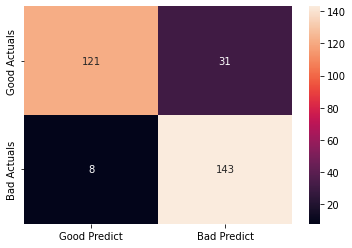

[INFO] f1-score of the GradientBoostingClassifier model is 87.13 %

[INFO] Detailed classification report for GradientBoostingClassifier model is: 

               precision    recall  f1-score   support

           0       0.94      0.80      0.86       152
           1       0.82      0.95      0.88       151

    accuracy                           0.87       303
   macro avg       0.88      0.87      0.87       303
weighted avg       0.88      0.87      0.87       303



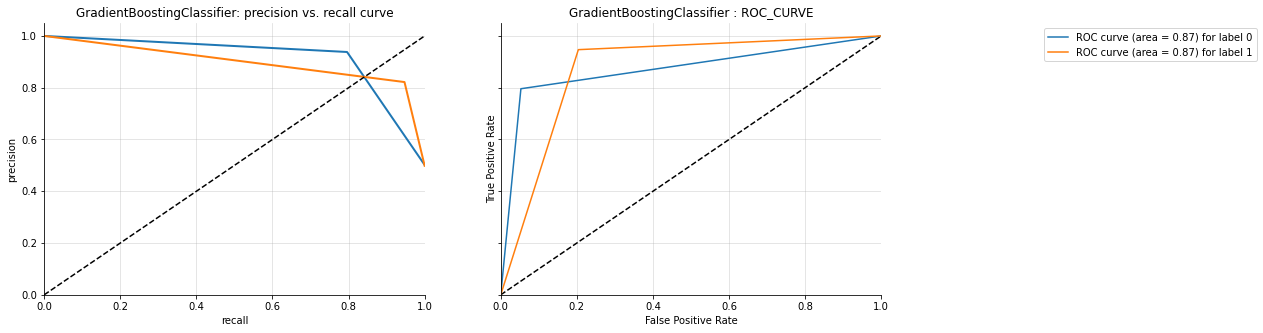


[INFO] End time:- 2021-11-28 16:55:18.304810. Total time taken 122.95535911666666 minutes.


[INFO] Model pickle as trained_pickled/GradientBoostingClassifier_trained.pkl.
----------------------------------------------------------------------
7. AdaBoostClassifier Model with Normal with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 16:55:18.321833

[INFO] Model: AdaBoostClassifier(random_state=0)

[INFO] AdaBoostClassifier Model is defined.

[INFO] AdaBoostClassifier model fitting started at :- 2021-11-28 16:55:18.324835

[INFO] AdaBoostClassifier model fitting completed at :- 2021-11-28 16:55:18.556833

[INFO] AdaBoostClassifier model started GridSearch at :- 2021-11-28 16:55:18.556833.

Fitting 2 folds for each of 30 candidates, totalling 60 fits

[INFO] AdaBoostClassifier model having best accuracy of 81.19 using {'algorithm': 'SAMME.R', 'learning_rate': 0.81, 'n_estimators': 200} parameters.

[INF

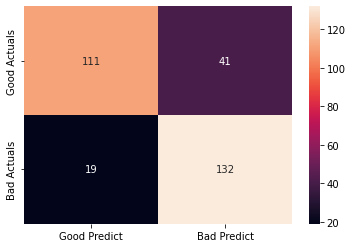

[INFO] f1-score of the AdaBoostClassifier model is 80.20 %

[INFO] Detailed classification report for AdaBoostClassifier model is: 

               precision    recall  f1-score   support

           0       0.85      0.73      0.79       152
           1       0.76      0.87      0.81       151

    accuracy                           0.80       303
   macro avg       0.81      0.80      0.80       303
weighted avg       0.81      0.80      0.80       303



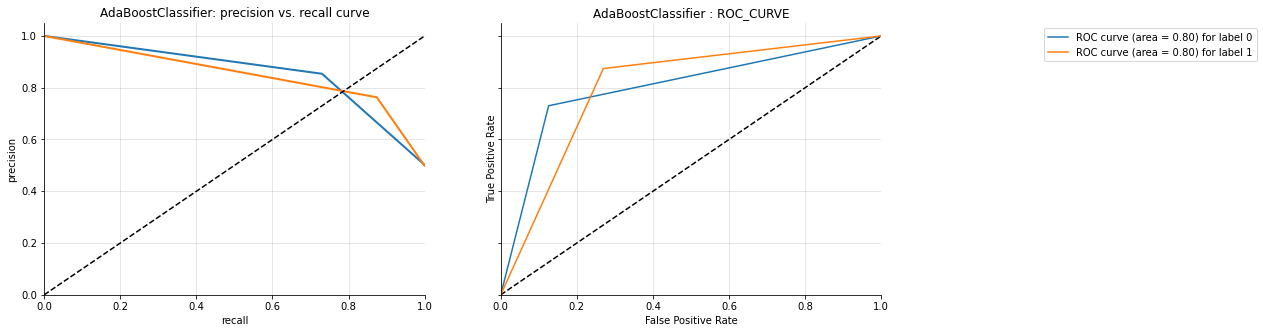


[INFO] End time:- 2021-11-28 16:55:43.369271. Total time taken 0.4174573 minutes.


[INFO] Model pickle as trained_pickled/AdaBoostClassifier_trained.pkl.
----------------------------------------------------------------------
8. LinearSVC Model with Normal with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 16:55:43.385356

[INFO] Model: LinearSVC(random_state=0)

[INFO] LinearSVC Model is defined.

[INFO] LinearSVC model fitting started at :- 2021-11-28 16:55:43.388356

[INFO] LinearSVC model fitting completed at :- 2021-11-28 16:55:43.463416

[INFO] LinearSVC model started GridSearch at :- 2021-11-28 16:55:43.463416.

Fitting 2 folds for each of 6 candidates, totalling 12 fits

[INFO] LinearSVC model having best accuracy of 59.62 using {'loss': 'hinge', 'penalty': 'l2'} parameters.

[INFO] LinearSVC model completed GridSearch at :- 2021-11-28 16:55:43.767000 .

[INFO] Train Accuracy of the LinearSVC 

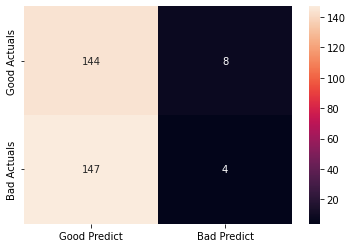

[INFO] f1-score of the LinearSVC model is 48.84 %

[INFO] Detailed classification report for LinearSVC model is: 

               precision    recall  f1-score   support

           0       0.49      0.95      0.65       152
           1       0.33      0.03      0.05       151

    accuracy                           0.49       303
   macro avg       0.41      0.49      0.35       303
weighted avg       0.41      0.49      0.35       303



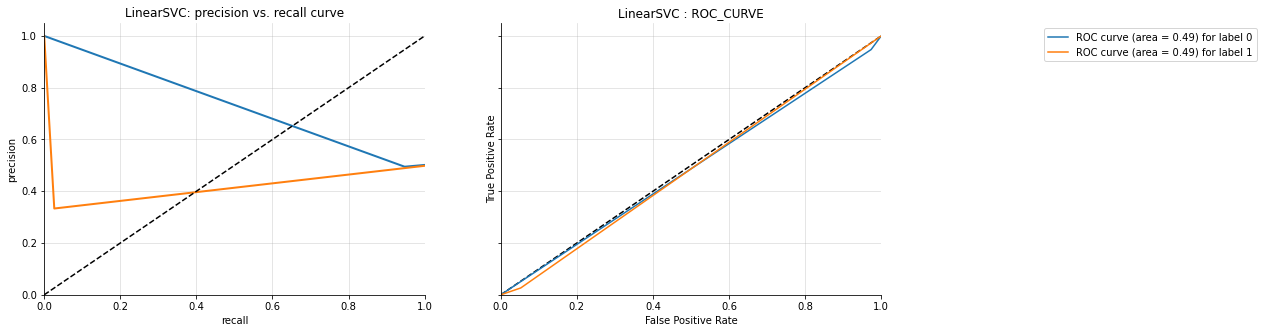


[INFO] End time:- 2021-11-28 16:55:44.595179. Total time taken 0.020163716666666668 minutes.


[INFO] Model pickle as trained_pickled/LinearSVC_trained.pkl.
----------------------------------------------------------------------
9. XGBClassifier Model with Normal with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 16:55:44.606179

[INFO] Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_delta_step=None, max_depth=8,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None,

[16:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:56:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:56:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:56:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:56:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:56:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:56:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:57:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:57:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:58:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:58:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:58:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:59:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:59:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:00:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:00:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:00:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:00:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:00:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:01:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:02:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:02:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:03:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:03:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:04:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:04:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:04:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:04:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:04:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:04:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:04:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:04:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:05:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:05:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:05:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:05:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:06:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:06:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:06:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:06:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:07:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:07:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:07:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:07:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:08:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:08:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:08:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:08:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:08:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:09:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:09:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:09:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:09:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:09:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:09:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:09:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:09:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:09:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:09:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:09:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:09:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:09:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:09:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:09:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:09:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:10:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:10:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:10:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:10:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:11:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:11:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:11:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:11:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:11:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:11:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:11:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:11:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:11:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:11:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:11:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

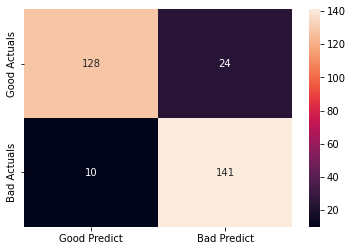

[INFO] f1-score of the XGBClassifier model is 88.78 %

[INFO] Detailed classification report for XGBClassifier model is: 

               precision    recall  f1-score   support

           0       0.93      0.84      0.88       152
           1       0.85      0.93      0.89       151

    accuracy                           0.89       303
   macro avg       0.89      0.89      0.89       303
weighted avg       0.89      0.89      0.89       303



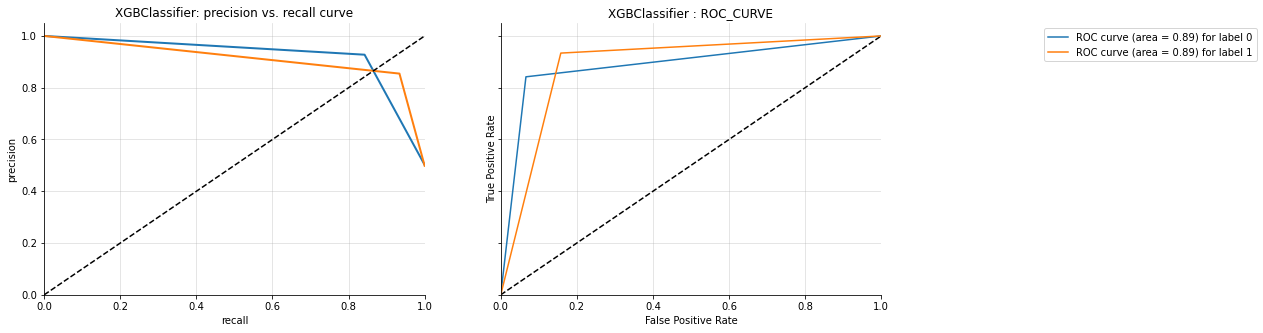


[INFO] End time:- 2021-11-28 17:11:44.534051. Total time taken 15.998797866666667 minutes.


[INFO] Model pickle as trained_pickled/XGBClassifier_trained.pkl.
----------------------------------------------------------------------
10. LGBMClassifier Model with Normal with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 17:11:44.586019

[INFO] Model: LGBMClassifier(learning_rate=0.05, max_depth=8, n_estimators=400,
               objective='binary')

[INFO] LGBMClassifier Model is defined.

[INFO] LGBMClassifier model fitting started at :- 2021-11-28 17:11:44.587021

[INFO] LGBMClassifier model fitting completed at :- 2021-11-28 17:11:44.894019

[INFO] LGBMClassifier model started GridSearch at :- 2021-11-28 17:11:44.894019.

Fitting 2 folds for each of 125 candidates, totalling 250 fits

[INFO] LGBMClassifier model having best accuracy of 86.14 using {'learning_rate': 0.21000000000000002, 'max_depth': 7,

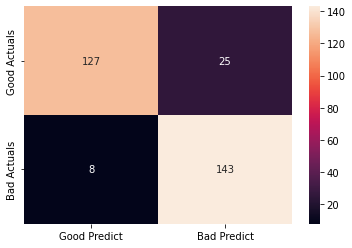

[INFO] f1-score of the LGBMClassifier model is 89.11 %

[INFO] Detailed classification report for LGBMClassifier model is: 

               precision    recall  f1-score   support

           0       0.94      0.84      0.89       152
           1       0.85      0.95      0.90       151

    accuracy                           0.89       303
   macro avg       0.90      0.89      0.89       303
weighted avg       0.90      0.89      0.89       303



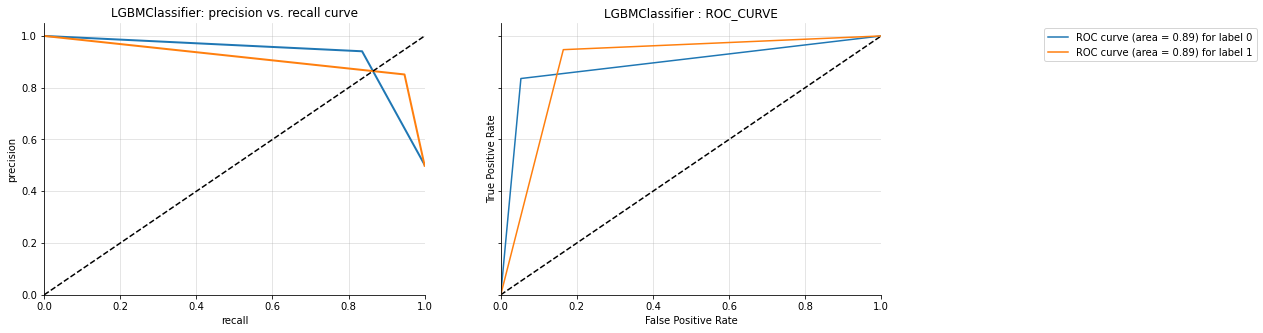


[INFO] End time:- 2021-11-28 17:12:04.652945. Total time taken 0.3344487666666666 minutes.


[INFO] Model pickle as trained_pickled/LGBMClassifier_trained.pkl.


Model Name            Dataset  Train Accuracy  \
0   LogisticRegression          Normal             89.041096        
1   KNeighborsClassifier        Normal             89.236791        
2   DecisionTreeClassifier      Normal             100.000000       
3   RandomForestClassifier      Normal             100.000000       
4   ExtraTreesClassifier        Normal             100.000000       
5   GradientBoostingClassifier  Normal             98.434442        
6   AdaBoostClassifier          Normal             93.346380        
7   LinearSVC                   Normal             88.845401        
8   XGBClassifier               Normal             100.000000       
9   LGBMClassifier              Normal             100.000000       
10  LogisticRegression          Normalized         88.845401        
11  KNeighborsClassifier        Normalized         90.215264        
12  DecisionTreeClassifier      Normalized         100.000000       
13  RandomForestClassifier      Normalized         100.000000       
14  ExtraTreesClassifier        Normalized         100.000000       
15  GradientBoostingClassifier  Normalized         98.434442        
16  AdaBoostClassifier          Normalized         93.346380        
17  LinearSVC                   Normalized         88.845401        
18  XGBClassifier               Normalized         100.000000       
19  LGBMClassifier              Normalized         100.000000       
20  LogisticRegression          Normal with SMOTE  63.054696        
21  KNeighborsClassifier        Normal with SMOTE  85.758514        
22  DecisionTreeClassifier      Normal with SMOTE  100.000000       
23  LogisticRegression          Normal with SMOTE  63.476348        
24  KNeighborsClassifier        Normal with SMOTE  85.148515        
25  DecisionTreeClassifier      Normal with SMOTE  100.000000       
26  RandomForestClassifier      Normal with SMOTE  100.000000       
27  ExtraTreesClassifier        Normal with SMOTE  100.000000       
28  GradientBoostingClassifier  Normal with SMOTE  96.369637        
29  AdaBoostClassifier          Normal with SMOTE  88.118812        
30  LinearSVC                   Normal with SMOTE  49.064906        
31  XGBClassifier               Normal with SMOTE  100.000000       
32  LGBMClassifier              Normal with SMOTE  100.000000       

    Test Accuracy                                    F1 Score  \
0   88.304094      [0.937888198757764, 0.0]                     
1   83.040936      [0.9073482428115016, 0.0]                    
2   78.947368      [0.88, 0.14285714285714288]                  
3   88.304094      [0.9375, 0.09090909090909091]                
4   87.719298      [0.9341692789968651, 0.08695652173913043]    
5   88.888889      [0.9400630914826498, 0.23999999999999996]    
6   86.549708      [0.9255663430420712, 0.30303030303030304]    
7   88.888889      [0.9411764705882353, 0.0]                    
8   86.549708      [0.9260450160771704, 0.2580645161290323]     
9   86.549708      [0.9265175718849841, 0.20689655172413793]    
10  88.888889      [0.9411764705882353, 0.0]                    
11  87.719298      [0.9341692789968651, 0.08695652173913043]    
12  82.456140      [0.9025974025974026, 0.11764705882352941]    
13  89.473684      [0.9440993788819877, 0.1]                    
14  88.888889      [0.940809968847352, 0.09523809523809525]     
15  88.888889      [0.9400630914826498, 0.23999999999999996]    
16  88.304094      [0.9363057324840764, 0.2857142857142857]     
17  88.888889      [0.9411764705882353, 0.0]                    
18  88.304094      [0.9367088607594938, 0.23076923076923078]    
19  87.719298      [0.9337539432176656, 0.16]                   
20  60.905350      [0.5922746781115881, 0.6245059288537549]     
21  79.423868      [0.7619047619047619, 0.818840579710145]      
22  84.773663      [0.8412017167381973, 0.8537549407114624]     
23  60.726073      [0.5672727272727273, 0.6404833836858005]     
24  77.227723      [0.7183673469387756, 0.808864

In [454]:
run_models(models=models,
           X_train=X_train_smote,
           y_train=y_train_smote,
           X_test=X_test_smote,
           y_test=y_test_smote,
           n_classes=n_classes,
           N_SPLITS=N_SPLITS,
           grid_search=True,
           CV=CV,
           tabular=True,
           detailed=True,
           dataset_type='Normal with SMOTE',
           reset_output_pd=False)

In [455]:
# Let us scale train as well as test data using MinMaxScaler
scaler = MinMaxScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_smote_scaled = scaler.fit_transform(X_test_smote)

----------------------------------------------------------------------
1. LogisticRegression Model with Normalized with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 17:20:48.212222

[INFO] Model: LogisticRegression(C=0.5, random_state=0, solver='liblinear')

[INFO] LogisticRegression Model is defined.

[INFO] LogisticRegression model fitting started at :- 2021-11-28 17:20:48.214187

[INFO] LogisticRegression model fitting completed at :- 2021-11-28 17:20:48.219187

[INFO] LogisticRegression model started GridSearch at :- 2021-11-28 17:20:48.219187.

Fitting 2 folds for each of 16 candidates, totalling 32 fits

[INFO] LogisticRegression model having best accuracy of 64.68 using {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'} parameters.

[INFO] LogisticRegression model completed GridSearch at :- 2021-11-28 17:20:48.307188 .

[INFO] Train Accuracy of the LogisticRegression model is 64.80 %

[INFO] 

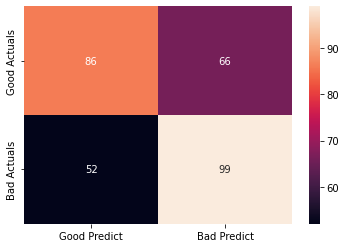

[INFO] f1-score of the LogisticRegression model is 61.06 %

[INFO] Detailed classification report for LogisticRegression model is: 

               precision    recall  f1-score   support

           0       0.62      0.57      0.59       152
           1       0.60      0.66      0.63       151

    accuracy                           0.61       303
   macro avg       0.61      0.61      0.61       303
weighted avg       0.61      0.61      0.61       303



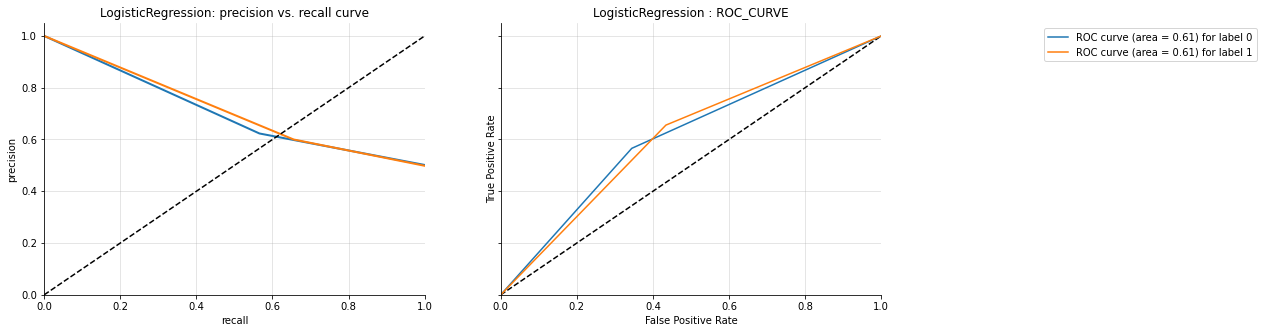


[INFO] End time:- 2021-11-28 17:20:48.702097. Total time taken 0.008164583333333333 minutes.


[INFO] Model pickle as trained_pickled/LogisticRegression_trained.pkl.
----------------------------------------------------------------------
2. KNeighborsClassifier Model with Normalized with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 17:20:48.707096

[INFO] Model: KNeighborsClassifier()

[INFO] KNeighborsClassifier Model is defined.

[INFO] KNeighborsClassifier model fitting started at :- 2021-11-28 17:20:48.708097

[INFO] KNeighborsClassifier model fitting completed at :- 2021-11-28 17:20:48.748090

[INFO] KNeighborsClassifier model started GridSearch at :- 2021-11-28 17:20:48.748090.

Fitting 2 folds for each of 72 candidates, totalling 144 fits

[INFO] KNeighborsClassifier model having best accuracy of 80.31 using {'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 3, 'p': 1} parameters.

[INFO] 

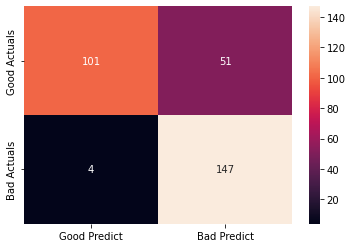

[INFO] f1-score of the KNeighborsClassifier model is 81.85 %

[INFO] Detailed classification report for KNeighborsClassifier model is: 

               precision    recall  f1-score   support

           0       0.96      0.66      0.79       152
           1       0.74      0.97      0.84       151

    accuracy                           0.82       303
   macro avg       0.85      0.82      0.81       303
weighted avg       0.85      0.82      0.81       303



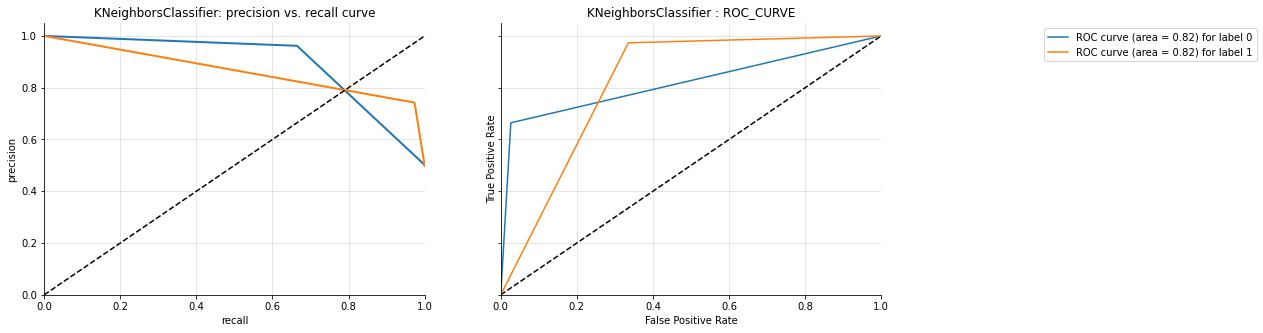


[INFO] End time:- 2021-11-28 17:20:52.246315. Total time taken 0.05898698333333333 minutes.


[INFO] Model pickle as trained_pickled/KNeighborsClassifier_trained.pkl.
----------------------------------------------------------------------
3. DecisionTreeClassifier Model with Normalized with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 17:20:52.251320

[INFO] Model: DecisionTreeClassifier(class_weight='balanced', random_state=0)

[INFO] DecisionTreeClassifier Model is defined.

[INFO] DecisionTreeClassifier model fitting started at :- 2021-11-28 17:20:52.253321

[INFO] DecisionTreeClassifier model fitting completed at :- 2021-11-28 17:20:52.261320

[INFO] DecisionTreeClassifier model started GridSearch at :- 2021-11-28 17:20:52.261320.

Fitting 2 folds for each of 128 candidates, totalling 256 fits

[INFO] DecisionTreeClassifier model having best accuracy of 80.97 using {'criterion': 'entropy', 'max_de

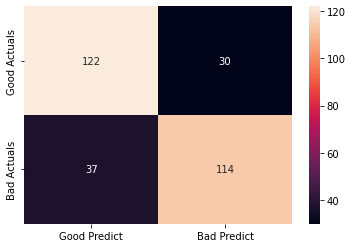

[INFO] f1-score of the DecisionTreeClassifier model is 77.89 %

[INFO] Detailed classification report for DecisionTreeClassifier model is: 

               precision    recall  f1-score   support

           0       0.77      0.80      0.78       152
           1       0.79      0.75      0.77       151

    accuracy                           0.78       303
   macro avg       0.78      0.78      0.78       303
weighted avg       0.78      0.78      0.78       303



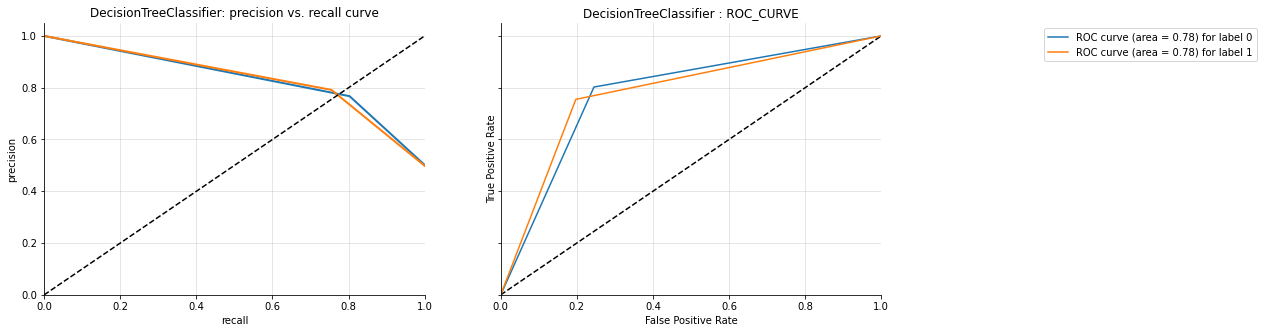


[INFO] End time:- 2021-11-28 17:20:53.492317. Total time taken 0.020683283333333333 minutes.


[INFO] Model pickle as trained_pickled/DecisionTreeClassifier_trained.pkl.
----------------------------------------------------------------------
4. RandomForestClassifier Model with Normalized with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 17:20:53.500318

[INFO] Model: RandomForestClassifier(class_weight='balanced', random_state=0)

[INFO] RandomForestClassifier Model is defined.

[INFO] RandomForestClassifier model fitting started at :- 2021-11-28 17:20:53.501320

[INFO] RandomForestClassifier model fitting completed at :- 2021-11-28 17:20:53.772316

[INFO] RandomForestClassifier model started GridSearch at :- 2021-11-28 17:20:53.772316.

Fitting 2 folds for each of 768 candidates, totalling 1536 fits

[INFO] RandomForestClassifier model having best accuracy of 87.13 using {'criterion': 'entropy', 'ma

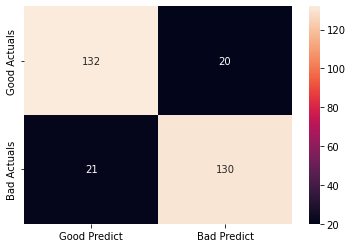

[INFO] f1-score of the RandomForestClassifier model is 86.47 %

[INFO] Detailed classification report for RandomForestClassifier model is: 

               precision    recall  f1-score   support

           0       0.86      0.87      0.87       152
           1       0.87      0.86      0.86       151

    accuracy                           0.86       303
   macro avg       0.86      0.86      0.86       303
weighted avg       0.86      0.86      0.86       303



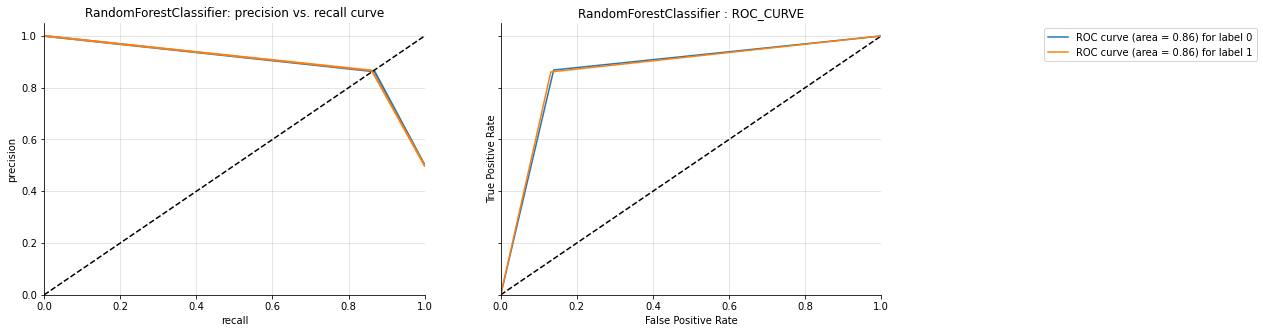


[INFO] End time:- 2021-11-28 17:28:21.801739. Total time taken 7.47169035 minutes.


[INFO] Model pickle as trained_pickled/RandomForestClassifier_trained.pkl.
----------------------------------------------------------------------
5. ExtraTreesClassifier Model with Normalized with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 17:28:21.811737

[INFO] Model: ExtraTreesClassifier(class_weight='balanced', random_state=0)

[INFO] ExtraTreesClassifier Model is defined.

[INFO] ExtraTreesClassifier model fitting started at :- 2021-11-28 17:28:21.818738

[INFO] ExtraTreesClassifier model fitting completed at :- 2021-11-28 17:28:21.978737

[INFO] ExtraTreesClassifier model started GridSearch at :- 2021-11-28 17:28:21.979737.

Fitting 2 folds for each of 768 candidates, totalling 1536 fits

[INFO] ExtraTreesClassifier model having best accuracy of 89.99 using {'criterion': 'entropy', 'max_depth': 20, 'max_featu

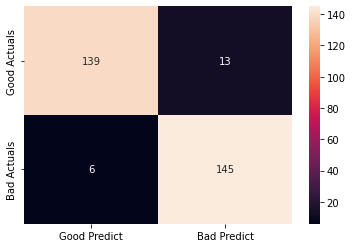

[INFO] f1-score of the ExtraTreesClassifier model is 93.73 %

[INFO] Detailed classification report for ExtraTreesClassifier model is: 

               precision    recall  f1-score   support

           0       0.96      0.91      0.94       152
           1       0.92      0.96      0.94       151

    accuracy                           0.94       303
   macro avg       0.94      0.94      0.94       303
weighted avg       0.94      0.94      0.94       303



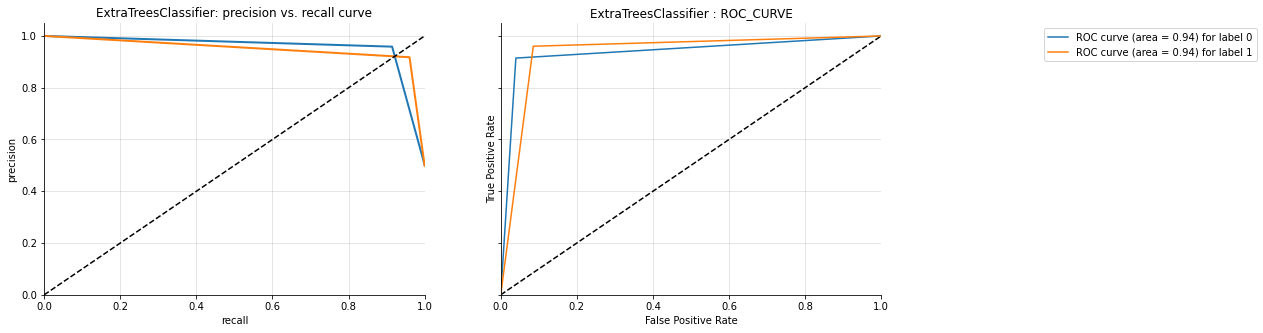


[INFO] End time:- 2021-11-28 17:30:33.274568. Total time taken 2.191047183333333 minutes.


[INFO] Model pickle as trained_pickled/ExtraTreesClassifier_trained.pkl.
----------------------------------------------------------------------
6. GradientBoostingClassifier Model with Normalized with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 17:30:33.289539

[INFO] Model: GradientBoostingClassifier(random_state=0)

[INFO] GradientBoostingClassifier Model is defined.

[INFO] GradientBoostingClassifier model fitting started at :- 2021-11-28 17:30:33.294550

[INFO] GradientBoostingClassifier model fitting completed at :- 2021-11-28 17:30:33.511547

[INFO] GradientBoostingClassifier model started GridSearch at :- 2021-11-28 17:30:33.511547.

Fitting 2 folds for each of 5760 candidates, totalling 11520 fits

[INFO] GradientBoostingClassifier model having best accuracy of 88.23 using {'criterion': 'friedman_mse'

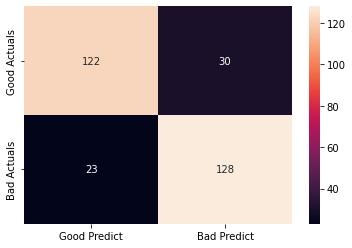

[INFO] f1-score of the GradientBoostingClassifier model is 82.51 %

[INFO] Detailed classification report for GradientBoostingClassifier model is: 

               precision    recall  f1-score   support

           0       0.84      0.80      0.82       152
           1       0.81      0.85      0.83       151

    accuracy                           0.83       303
   macro avg       0.83      0.83      0.83       303
weighted avg       0.83      0.83      0.83       303



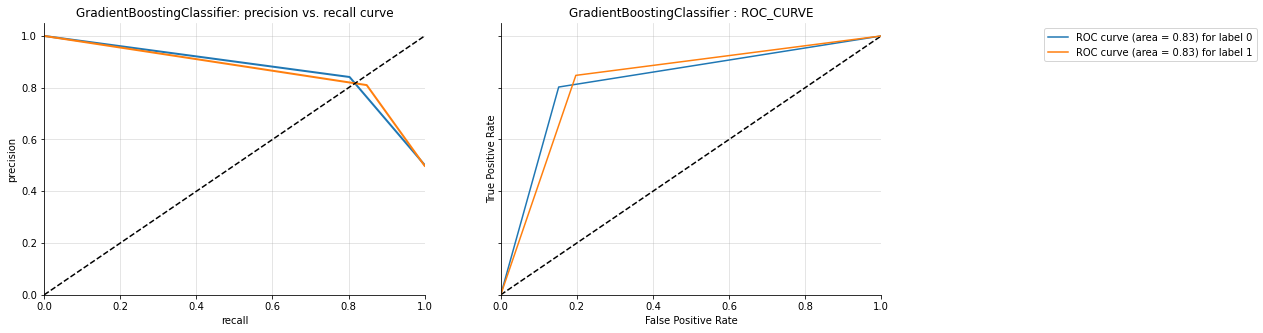


[INFO] End time:- 2021-11-28 18:27:30.818230. Total time taken 56.958811516666664 minutes.


[INFO] Model pickle as trained_pickled/GradientBoostingClassifier_trained.pkl.
----------------------------------------------------------------------
7. AdaBoostClassifier Model with Normalized with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 18:27:30.826233

[INFO] Model: AdaBoostClassifier(random_state=0)

[INFO] AdaBoostClassifier Model is defined.

[INFO] AdaBoostClassifier model fitting started at :- 2021-11-28 18:27:30.833229

[INFO] AdaBoostClassifier model fitting completed at :- 2021-11-28 18:27:30.938269

[INFO] AdaBoostClassifier model started GridSearch at :- 2021-11-28 18:27:30.938269.

Fitting 2 folds for each of 30 candidates, totalling 60 fits

[INFO] AdaBoostClassifier model having best accuracy of 81.19 using {'algorithm': 'SAMME.R', 'learning_rate': 0.81, 'n_estimators': 200} parameters.



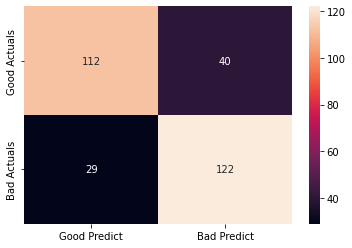

[INFO] f1-score of the AdaBoostClassifier model is 77.23 %

[INFO] Detailed classification report for AdaBoostClassifier model is: 

               precision    recall  f1-score   support

           0       0.79      0.74      0.76       152
           1       0.75      0.81      0.78       151

    accuracy                           0.77       303
   macro avg       0.77      0.77      0.77       303
weighted avg       0.77      0.77      0.77       303



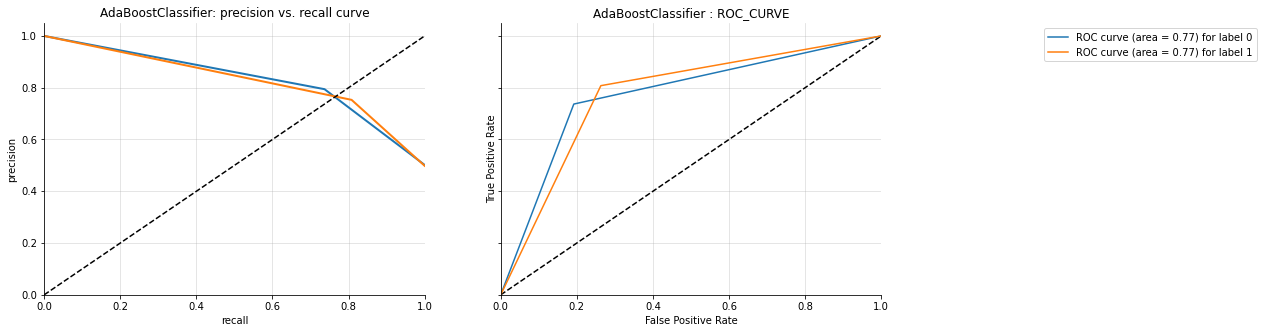


[INFO] End time:- 2021-11-28 18:27:42.878246. Total time taken 0.20086688333333333 minutes.


[INFO] Model pickle as trained_pickled/AdaBoostClassifier_trained.pkl.
----------------------------------------------------------------------
8. LinearSVC Model with Normalized with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 18:27:42.884241

[INFO] Model: LinearSVC(random_state=0)

[INFO] LinearSVC Model is defined.

[INFO] LinearSVC model fitting started at :- 2021-11-28 18:27:42.890243

[INFO] LinearSVC model fitting completed at :- 2021-11-28 18:27:42.896290

[INFO] LinearSVC model started GridSearch at :- 2021-11-28 18:27:42.896290.

Fitting 2 folds for each of 6 candidates, totalling 12 fits

[INFO] LinearSVC model having best accuracy of 64.47 using {'loss': 'squared_hinge', 'penalty': 'l2'} parameters.

[INFO] LinearSVC model completed GridSearch at :- 2021-11-28 18:27:42.927241 .

[INFO] Train Accu

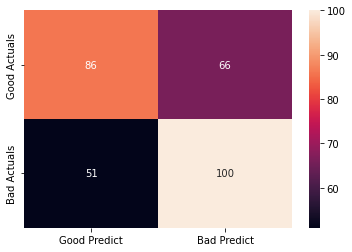

[INFO] f1-score of the LinearSVC model is 61.39 %

[INFO] Detailed classification report for LinearSVC model is: 

               precision    recall  f1-score   support

           0       0.63      0.57      0.60       152
           1       0.60      0.66      0.63       151

    accuracy                           0.61       303
   macro avg       0.62      0.61      0.61       303
weighted avg       0.62      0.61      0.61       303



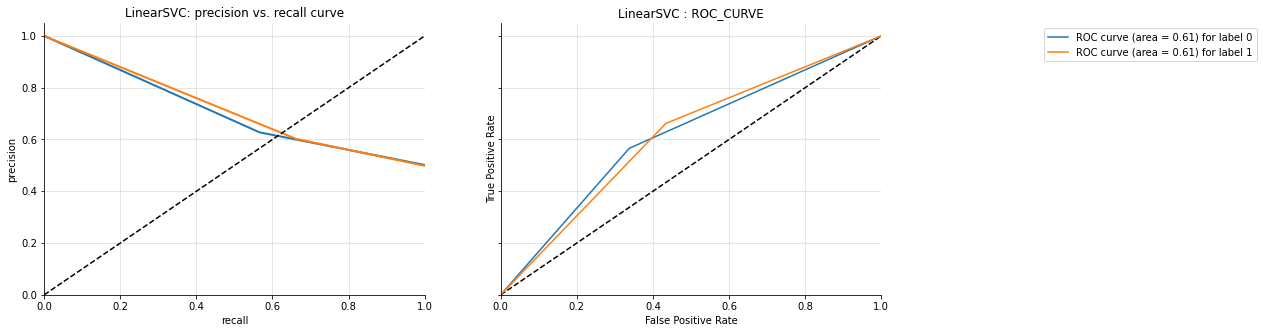


[INFO] End time:- 2021-11-28 18:27:43.325240. Total time taken 0.007349983333333333 minutes.


[INFO] Model pickle as trained_pickled/LinearSVC_trained.pkl.
----------------------------------------------------------------------
9. XGBClassifier Model with Normalized with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 18:27:43.330240

[INFO] Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_delta_step=None, max_depth=8,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=N

[18:27:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:28:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:28:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:28:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:29:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:29:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:30:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:30:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:30:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:31:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:31:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:31:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:31:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:32:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:32:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:33:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:33:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:33:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:34:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:34:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:34:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:34:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:35:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:35:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:35:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:35:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:36:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:36:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:36:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:37:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:37:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:37:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:37:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:37:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:37:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:37:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:37:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:37:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:37:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:37:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:37:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:37:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:38:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:38:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:38:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:39:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:39:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

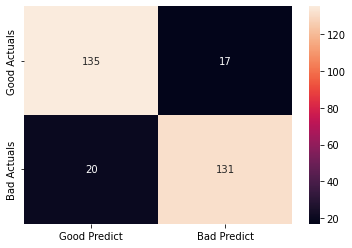

[INFO] f1-score of the XGBClassifier model is 87.79 %

[INFO] Detailed classification report for XGBClassifier model is: 

               precision    recall  f1-score   support

           0       0.87      0.89      0.88       152
           1       0.89      0.87      0.88       151

    accuracy                           0.88       303
   macro avg       0.88      0.88      0.88       303
weighted avg       0.88      0.88      0.88       303



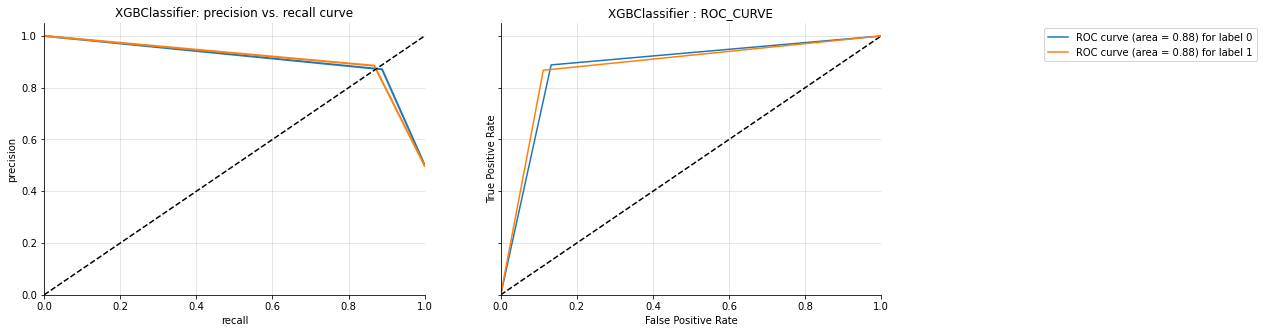


[INFO] End time:- 2021-11-28 18:39:38.727888. Total time taken 11.923294133333334 minutes.


[INFO] Model pickle as trained_pickled/XGBClassifier_trained.pkl.
----------------------------------------------------------------------
10. LGBMClassifier Model with Normalized with SMOTE dataset is in process.
----------------------------------------------------------------------
[INFO] Start time:- 2021-11-28 18:39:38.782889

[INFO] Model: LGBMClassifier(learning_rate=0.05, max_depth=8, n_estimators=400,
               objective='binary')

[INFO] LGBMClassifier Model is defined.

[INFO] LGBMClassifier model fitting started at :- 2021-11-28 18:39:38.788889

[INFO] LGBMClassifier model fitting completed at :- 2021-11-28 18:39:39.102889

[INFO] LGBMClassifier model started GridSearch at :- 2021-11-28 18:39:39.102889.

Fitting 2 folds for each of 125 candidates, totalling 250 fits

[INFO] LGBMClassifier model having best accuracy of 86.58 using {'learning_rate': 0.21000000000000002, 'max_depth'

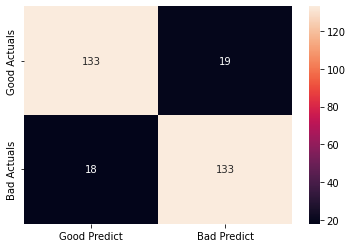

[INFO] f1-score of the LGBMClassifier model is 87.79 %

[INFO] Detailed classification report for LGBMClassifier model is: 

               precision    recall  f1-score   support

           0       0.88      0.88      0.88       152
           1       0.88      0.88      0.88       151

    accuracy                           0.88       303
   macro avg       0.88      0.88      0.88       303
weighted avg       0.88      0.88      0.88       303



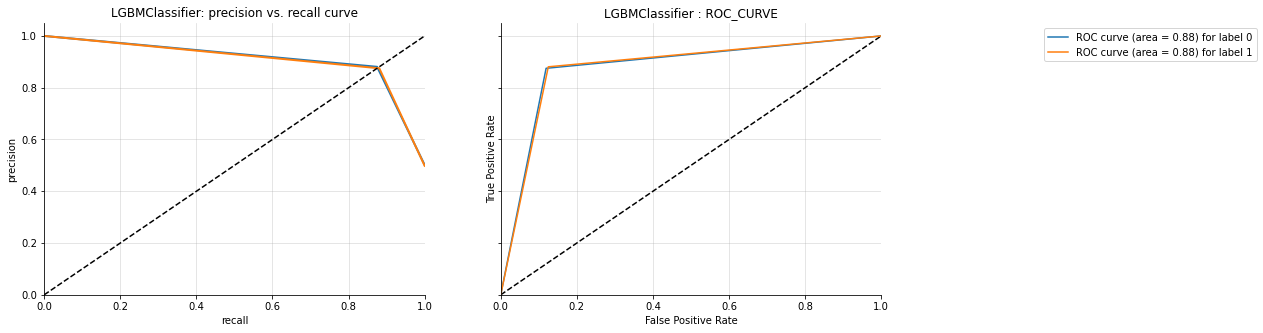


[INFO] End time:- 2021-11-28 18:40:01.811401. Total time taken 0.3838085333333333 minutes.


[INFO] Model pickle as trained_pickled/LGBMClassifier_trained.pkl.


Model Name                Dataset  Train Accuracy  \
0   LogisticRegression          Normal                 89.041096        
1   KNeighborsClassifier        Normal                 89.236791        
2   DecisionTreeClassifier      Normal                 100.000000       
3   RandomForestClassifier      Normal                 100.000000       
4   ExtraTreesClassifier        Normal                 100.000000       
5   GradientBoostingClassifier  Normal                 98.434442        
6   AdaBoostClassifier          Normal                 93.346380        
7   LinearSVC                   Normal                 88.845401        
8   XGBClassifier               Normal                 100.000000       
9   LGBMClassifier              Normal                 100.000000       
10  LogisticRegression          Normalized             88.845401        
11  KNeighborsClassifier        Normalized             90.215264        
12  DecisionTreeClassifier      Normalized             100.000000       
13  RandomForestClassifier      Normalized             100.000000       
14  ExtraTreesClassifier        Normalized             100.000000       
15  GradientBoostingClassifier  Normalized             98.434442        
16  AdaBoostClassifier          Normalized             93.346380        
17  LinearSVC                   Normalized             88.845401        
18  XGBClassifier               Normalized             100.000000       
19  LGBMClassifier              Normalized             100.000000       
20  LogisticRegression          Normal with SMOTE      63.054696        
21  KNeighborsClassifier        Normal with SMOTE      85.758514        
22  DecisionTreeClassifier      Normal with SMOTE      100.000000       
23  LogisticRegression          Normal with SMOTE      63.476348        
24  KNeighborsClassifier        Normal with SMOTE      85.148515        
25  DecisionTreeClassifier      Normal with SMOTE      100.000000       
26  RandomForestClassifier      Normal with SMOTE      100.000000       
27  ExtraTreesClassifier        Normal with SMOTE      100.000000       
28  GradientBoostingClassifier  Normal with SMOTE      96.369637        
29  AdaBoostClassifier          Normal with SMOTE      88.118812        
30  LinearSVC                   Normal with SMOTE      49.064906        
31  XGBClassifier               Normal with SMOTE      100.000000       
32  LGBMClassifier              Normal with SMOTE      100.000000       
33  LogisticRegression          Normalized with SMOTE  64.796480        
34  KNeighborsClassifier        Normalized with SMOTE  87.898790        
35  DecisionTreeClassifier      Normalized with SMOTE  100.000000       
36  RandomForestClassifier      Normalized with SMOTE  100.000000       
37  ExtraTreesClassifier        Normalized with SMOTE  100.000000       
38  GradientBoostingClassifier  Normalized with SMOTE  96.369637        
39  AdaBoostClassifier          Normalized with SMOTE  88.118812        
40  LinearSVC                   Normalized with SMOTE  64.686469        
41  XGBClassifier               Normalized with SMOTE  100.000000       
42  LGBMClassifier              Normalized with SMOTE  100.000000       

    Test Accuracy                                    F1 Score  \
0   88.304094      [0.937888198757764, 0.0]                     
1   83.040936      [0.9073482428115016, 0.0]                    
2   78.947368      [0.88, 0.14285714285714288]                  
3   88.304094      [0.9375, 0.09090909090909091]                
4   87.719298      [0.9341692789968651, 0.08695652173913043]    
5   88.888889      [0.9400630914826498, 0.23999999999999996]    
6   86.549708      [0.9255663430420712, 0.30303030303030304]    
7   88.888889      [0.9411764705882353, 0.0]                    
8   86.549708      [0.9260450160771704, 0.2580645161290323]     
9   86.549708      [0.9265175718849841, 0.20689655172413793]    
10  88.888889      [0.9411764705882353, 0.0]                    
11  87.719298      [0.93416

In [456]:
run_models(models=models,
           X_train=X_train_smote_scaled,
           y_train=y_train_smote,
           X_test=X_test_smote_scaled,
           y_test=y_test_smote,
           n_classes=n_classes,
           N_SPLITS=N_SPLITS,
           grid_search=True,
           CV=CV,
           tabular=True,
           detailed=True,
           dataset_type='Normalized with SMOTE',
           reset_output_pd=False)